# Analytics

#### Date: 2021/01

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM: SysArq

##### Semester: 2021/01
##### Professor: Hilmer Neri

##### Members:

- Joao Gabriel Rossi
- Paulo Vitor Coelho
- Joao Matheus
- Ivan Diniz Dobbin
- Gabriel Marcolino
- Carlos Eduardo Roriz
- Lorenzo Santos

### LIBRARIES

In [1]:
# Deal with data
import pandas as pd
import numpy as np
import json
from glob import glob
import os

# Deal with API request
import urllib3
from urllib3 import request

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Datetime
from datetime import datetime

### GRAPH SETTINGS

In [2]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [3]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

### SonarCloud

##### Path to the folder with all your jsons

In [4]:
jsons = glob('../analytics-raw-data/*.json') # add the path here

In [5]:
def read_json(json_path):
    
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
        
    return json_obj

def create_base_component_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        base_component = read_json(i)

        base_component_data = base_component['baseComponent']['measures']

        base_component_df = pd.DataFrame(base_component_data)

        base_component_df['filename'] = os.path.basename(i)

        df = df.append(base_component_df, ignore_index=True)
        
    aux_df = df['filename'].str.split(r"PC-GO1-(.*?)-*-(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[2]
    
    df = df.sort_values(by=['repository', 'version'])
        
    return df

#### Create base component dataframe

In [6]:
base_component_df = create_base_component_df(jsons)

In [7]:
base_component_df.head(10)

,metric,value,bestValue,filename,repository,version
36,duplicated_lines_density,0.0,True,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
37,functions,41,NaN,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
38,security_rating,1.0,True,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
39,files,16,NaN,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
40,complexity,42,NaN,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
41,ncloc,878,NaN,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
42,coverage,97.3,False,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
43,reliability_rating,1.0,True,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
44,comment_lines_density,7.7,False,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
99,duplicated_lines_density,0.0,True,fga-eps-mds-2021_1-PC-GO1-Archives-03-11-2021-...,Archives,03-11-2021-02-10


#### Create dataframe per file

In [8]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'security_rating',
               'tests',
               'test_success_density',
               'test_execution_time',
               'reliability_rating']

len(metric_list)

12

In [9]:
def metric_per_file(json):
    
    file_json = []
    
    for component in json['components']:
        if component['qualifier'] == 'FIL':
            file_json.append(component)
            
    return file_json

def generate_file_dataframe_per_release(metric_list, json, language_extension):
    
    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns, dtype=object)
    
    for file in json:
        try:
            if file['language'] == language_extension:
                for measure in file['measures']:
                    df.at[file['path'], measure['metric']] = measure['value']
        except:
            pass
        
    df.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    return df

def create_file_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        file_component = read_json(i)
        
        file_component_data = metric_per_file(file_component)
        
        file_component_df_py = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'py')
        file_component_df_js = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'js')

        file_component_df_py['filename'] = os.path.basename(i)
        file_component_df_js['filename'] = os.path.basename(i)

        df = df.append(file_component_df_js, ignore_index=True)
        df = df.append(file_component_df_py, ignore_index=True)
          
    aux_df = df['filename'].str.split(r"PC-GO1-(.*?)-(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[2]
    
    df = df.sort_values(by=['repository', 'version'])
        
    return df

In [10]:
file_component_df = create_file_df(jsons)

In [11]:
file_component_df.head(10)

,path,functions,complexity,comment_lines_density,duplicated_lines_density,coverage,ncloc,security_rating,tests,test_success_density,test_execution_time,reliability_rating,filename,repository,version
307,archives_app/migrations/0001_initial.py,0,0,1.2,0.0,0.0,85,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
308,archives_app/__init__.py,0,0,NaN,0.0,NaN,0,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
309,archives_app/migrations/__init__.py,0,0,NaN,0.0,NaN,0,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
310,project/__init__.py,0,0,NaN,0.0,NaN,0,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
311,archives_app/admin.py,0,0,NaN,0.0,NaN,0,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
312,archives_app/apps.py,0,0,0.0,0.0,100.0,3,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
313,project/asgi.py,0,0,66.7,0.0,NaN,4,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
314,manage.py,1,2,16.7,0.0,NaN,15,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
315,archives_app/models.py,0,0,0.0,0.0,100.0,39,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47
316,archives_app/serializers.py,0,0,0.0,0.0,100.0,65,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021_1-PC-GO1-Archives-03-10-2021-...,Archives,03-10-2021-15-47


#### Create dataframe per repository

In [12]:
archives_df = file_component_df[file_component_df['repository'] == 'Archives']
profile_df = file_component_df[file_component_df['repository'] == 'Profile']
frontend_df = file_component_df[file_component_df['repository'] == 'Frontend']

In [13]:
def _ncloc(df):
    ncloc = 0
    for each in df['ncloc']:
        ncloc += int(each)
    
    return ncloc

### Measure calculations accordng to Q-Rapids quality model

# Quality Aspect - Maintainability

## Factor - Code Quality 

### Metric calculations

##### COMPLEXITY

In [14]:
def m1(df):
    """
    Is better to have more functions than less functions but more complex ones with greater number of paths
    m1 = 1 is the best possible result
    """
    density_non_complex_files = len(df[((df['complexity'].astype(float)/df['functions'].astype(float)) < 10) | (df['functions'].astype(int) == 0).all()])/len(df)
    
    return density_non_complex_files

##### COMMENTS

In [15]:
def m2(df):
    
    density_comment_files = len(df[(df['comment_lines_density'].astype(float) > 10) & (df['comment_lines_density'].astype(float) < 30)])/len(df)
    
    return density_comment_files

##### DUPLICATIONS

In [16]:
def m3(df):
    """
    Is better to have less duplicated lines
    m3 = 1 is the best possible result
    """
    duplication = len(df[(df['duplicated_lines_density'].astype(float) < 5)])/len(df)
    
    return duplication

# Quality Aspect - Reliability

## Factor - Testing Status

##### Passed tests

In [17]:
def m4(df):
    """
    m4 = 1 is the optimal result
    """
    passed_tests = df['test_success_density'].astype(float).median() / 100

    return passed_tests

#### Fast test builds

In [18]:
def m5(df):
    """
    m5 = 1 is the optimal result
    """
    density_fast_test_builds = len(df[(df['test_execution_time'].astype(float)) < 300]) / sum(df['tests'].astype(float))

    return density_fast_test_builds

#### Test coverage

In [19]:
def m6(df):
    """
    m6 = 1 is the optimal result
    """
    density_test_coverage = len(df[(df['coverage'].astype(float) > 60)]) / len(df)

    return density_test_coverage


### Calculate m1, m2, m3, m4, m5 and m6 for each repository

In [20]:
def drop_unnecessary_files(df):
    new_df = df[~df['path'].str.contains('test')]
    new_df = new_df[~new_df['path'].str.contains('init')]
    new_df = new_df[~new_df['path'].str.contains('manage')]
    new_df = new_df[~new_df['path'].str.contains('asgi')]
    new_df = new_df[~new_df['path'].str.contains('wsgi')]
    new_df = new_df[~new_df['path'].str.contains('admin')]
    new_df = new_df[~new_df['path'].str.contains('models')]
    new_df = new_df[~new_df['path'].str.contains('models')]
    new_df = new_df[~new_df['path'].str.contains('reportWebVitals')]
    new_df = new_df[~new_df['path'].str.contains('setupTests')]
    new_df = new_df[~new_df['path'].str.contains('Home')]
    return new_df

In [21]:
new_archives_df = drop_unnecessary_files(archives_df)
new_frontend_df = drop_unnecessary_files(frontend_df)
new_profile_df = drop_unnecessary_files(profile_df)

In [22]:
def create_metrics_df(df):
    
    version_vec = df['version'].unique()
    
    m1_list = []
    m2_list = []
    m3_list = []
    m4_list = []
    m5_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []
    
    metrics_df = pd.DataFrame()
    
    for version in version_vec:

        version_df = df[df['version'] == version]

        m1_list.append(m1(version_df))
        m2_list.append(m2(version_df))
        m3_list.append(m3(version_df))
        m4_list.append(m4(version_df))
        m6_list.append(m6(version_df))

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)
        
    metrics_df = pd.DataFrame({'m1': m1_list,
                               'm2': m2_list,
                               'm3': m3_list,
                               'm4': m4_list,
                               'm6': m6_list,
                               'repository': repository_list, 
                               'version': version_list,
                               'ncloc': ncloc_list})
        
    return metrics_df

In [23]:
archives_metrics = create_metrics_df(new_archives_df)
profile_metrics = create_metrics_df(new_profile_df)
frontend_metrics = create_metrics_df(new_frontend_df)

### Data visualization

- You must do this for each of your repositories

# ARCHIVES

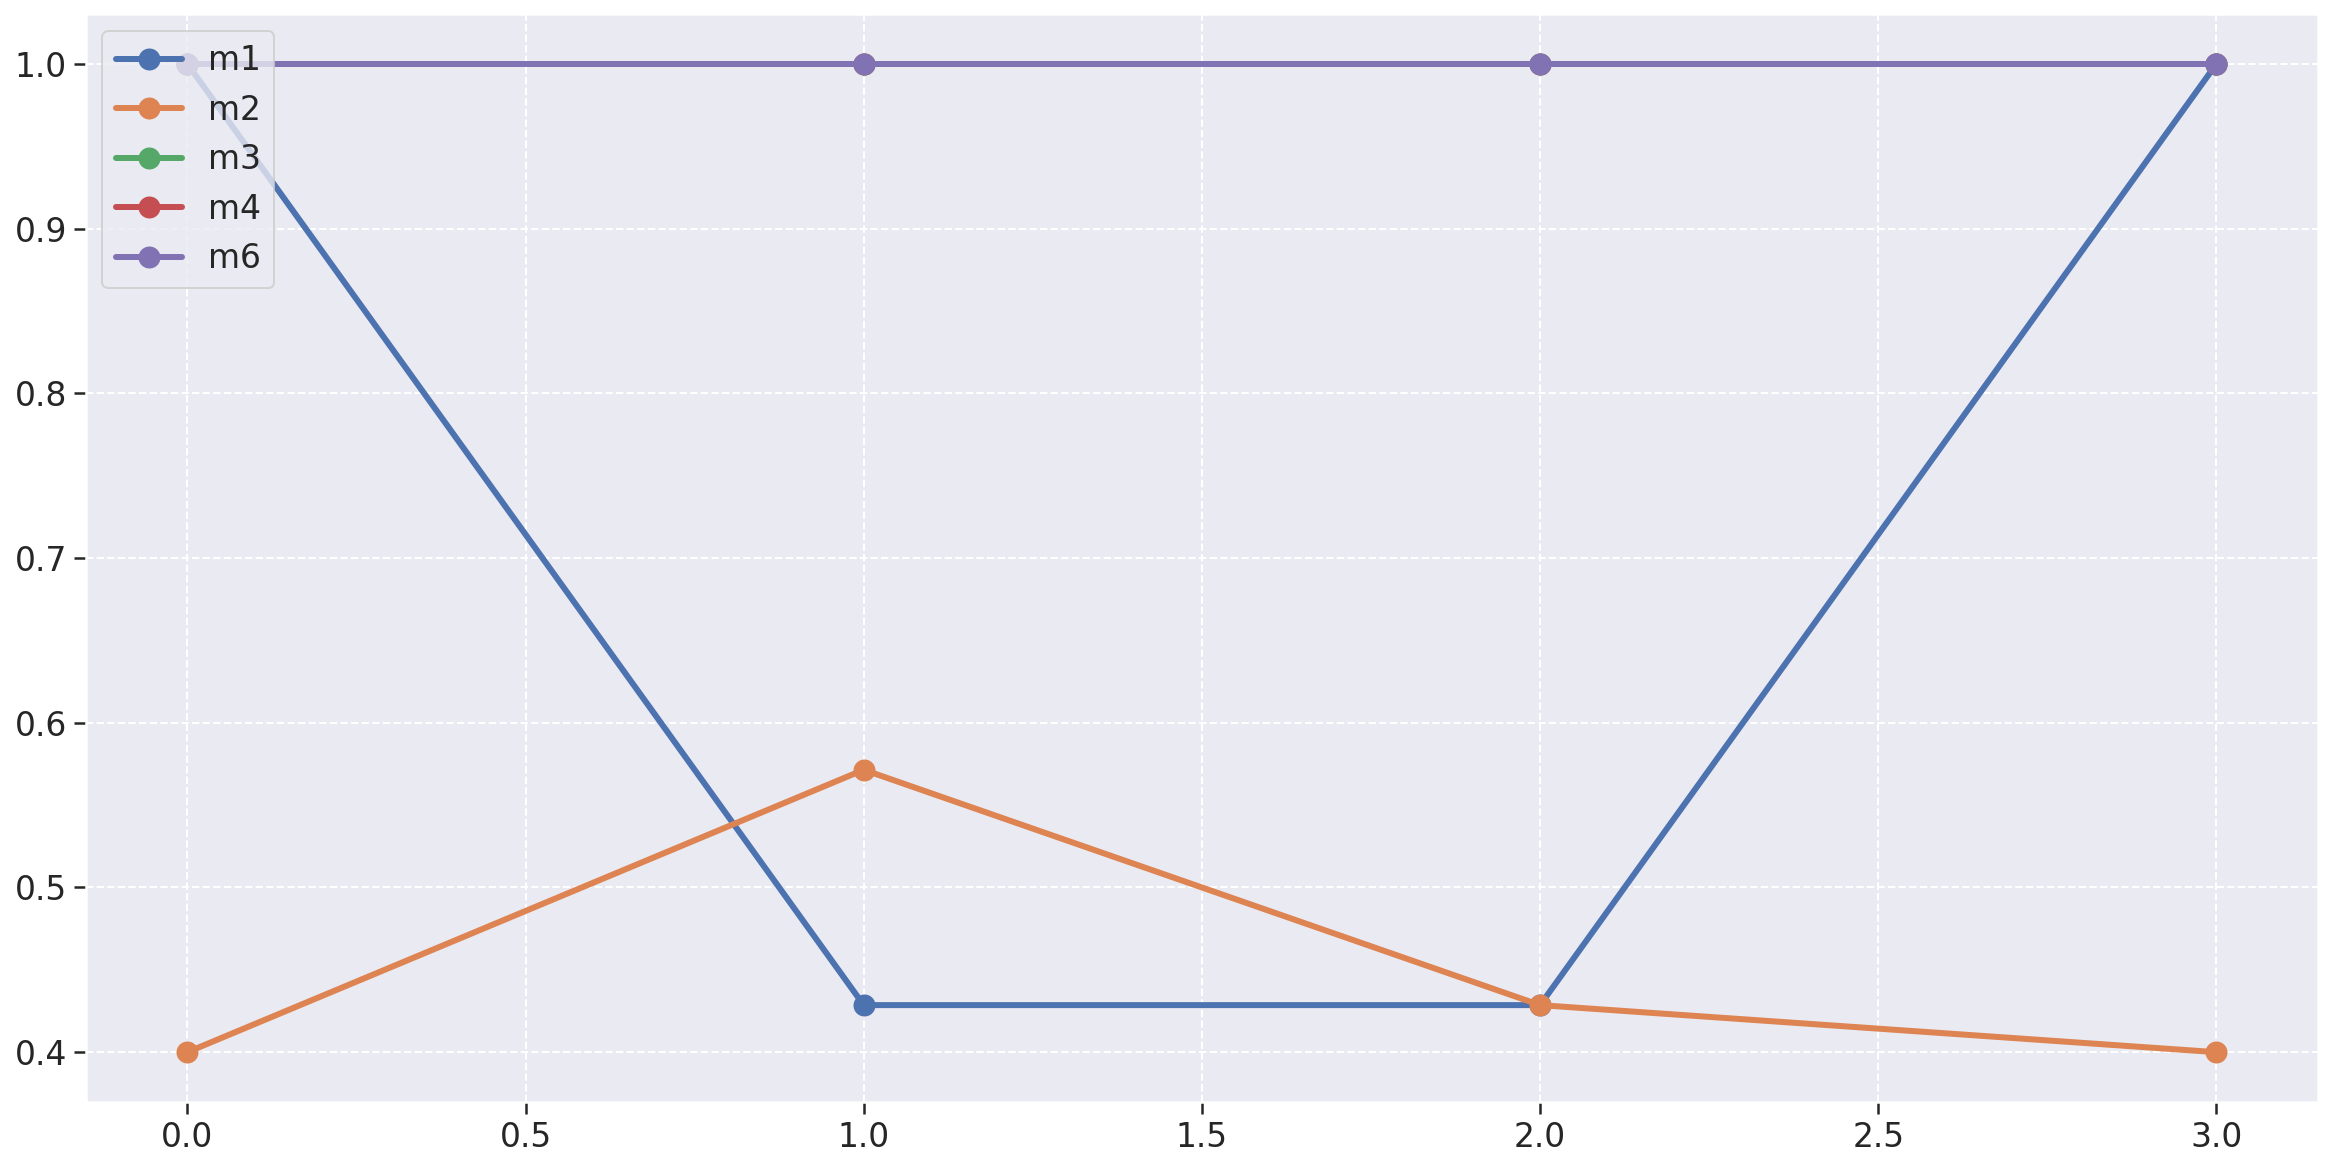

In [24]:
fig = plt.figure(figsize=(20, 10))

plt.plot(archives_metrics['m1'], linewidth=3, marker='o', markersize=10, label='m1')
plt.plot(archives_metrics['m2'], linewidth=3, marker='o', markersize=10, label='m2')
plt.plot(archives_metrics['m3'], linewidth=3, marker='o', markersize=10, label='m3')
plt.plot(archives_metrics['m4'], linewidth=3, marker='o', markersize=10, label='m4')
plt.plot(archives_metrics['m6'], linewidth=3, marker='o', markersize=10, label='m6')

plt.legend(loc='upper left')

# Profile

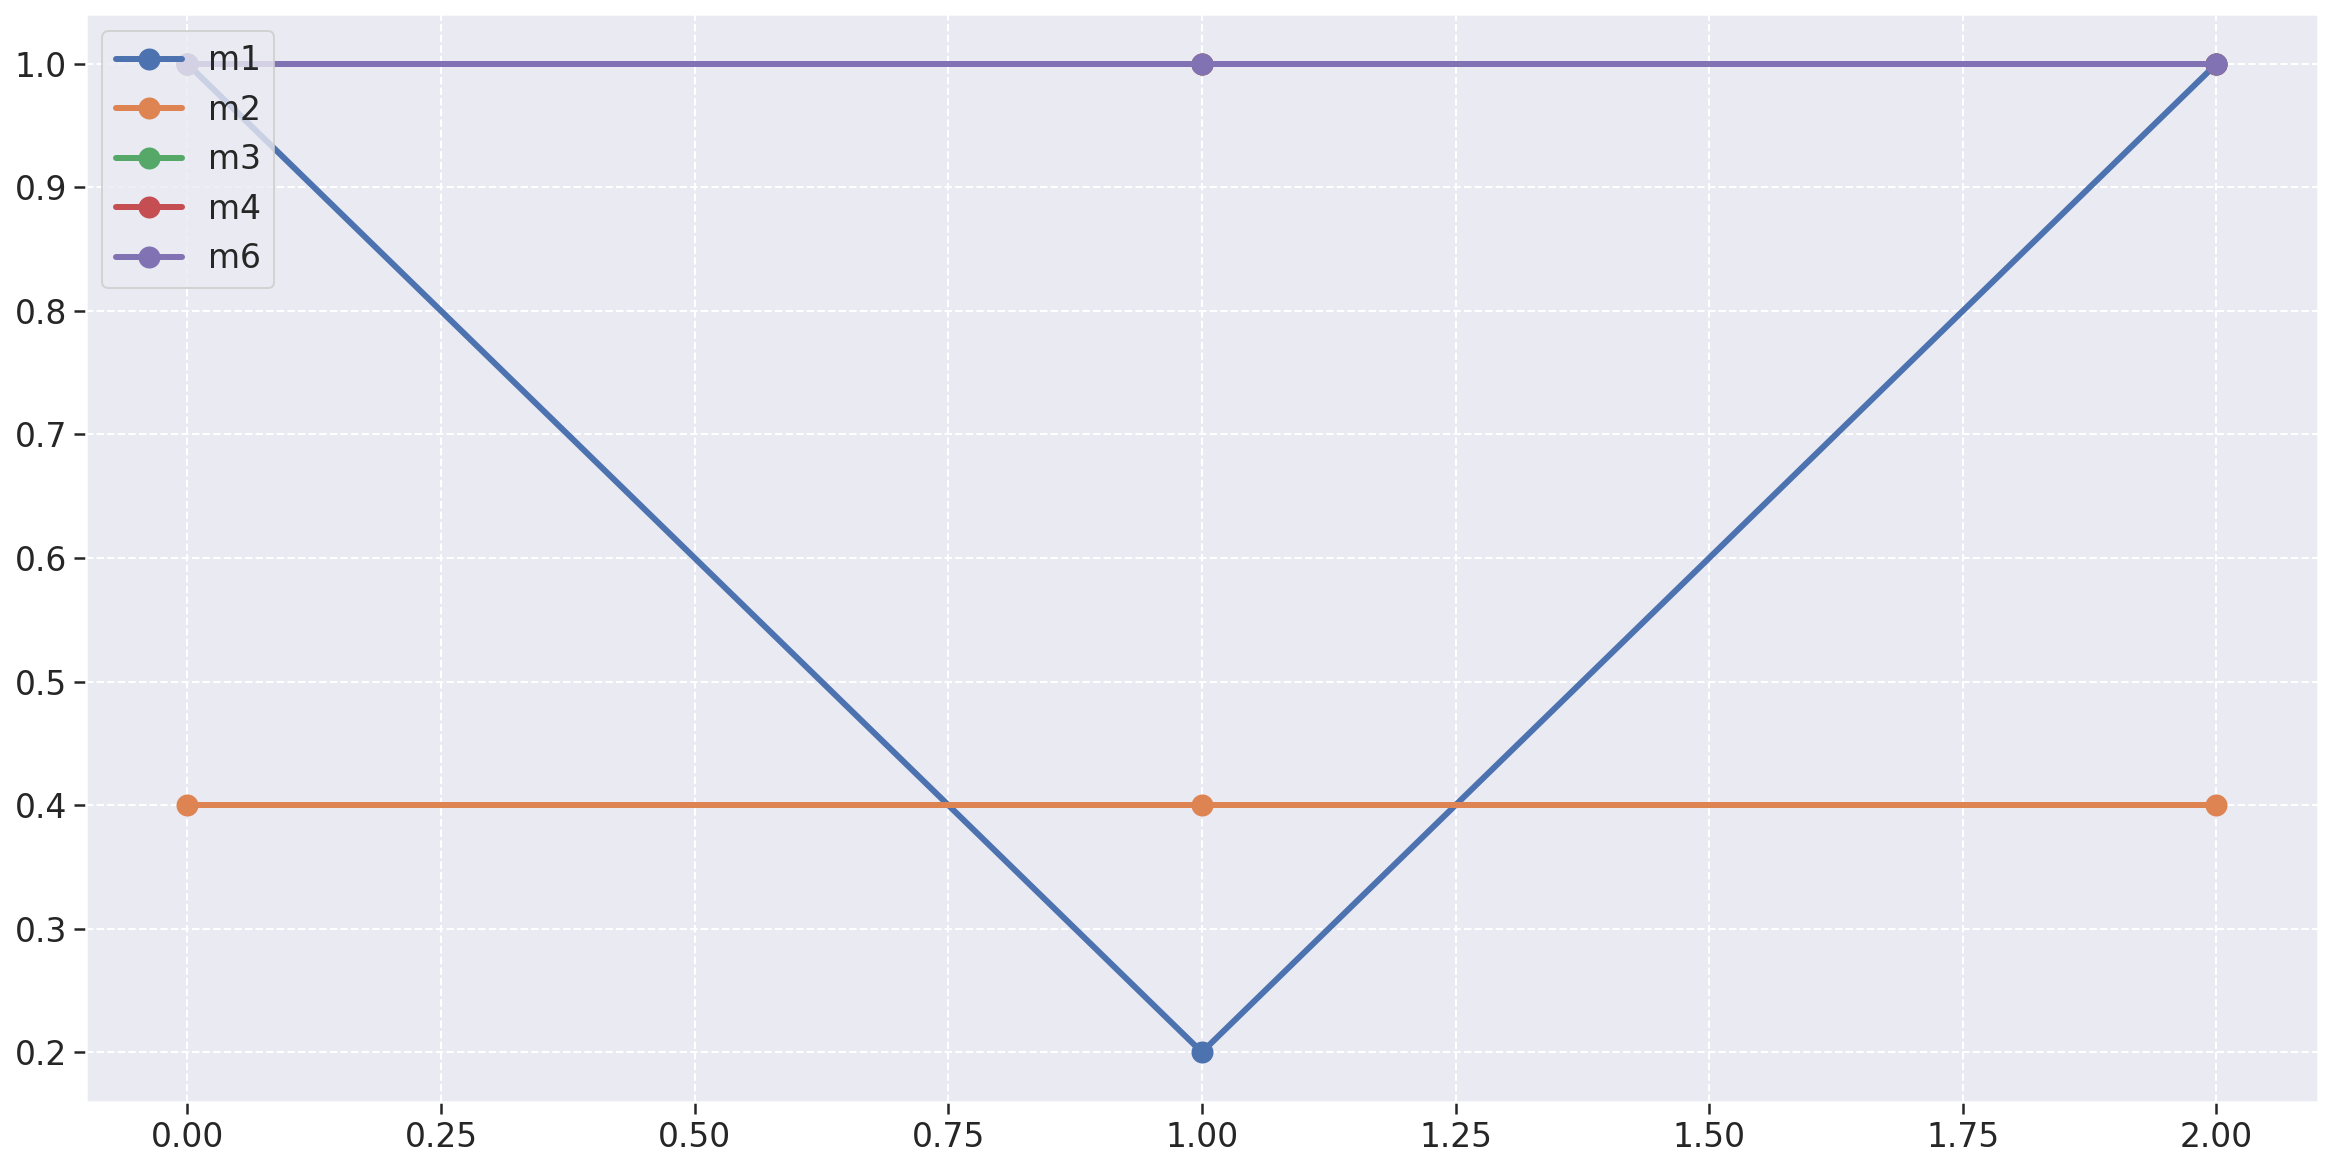

In [25]:
fig = plt.figure(figsize=(20, 10))

plt.plot(profile_metrics['m1'], linewidth=3, marker='o', markersize=10, label='m1')
plt.plot(profile_metrics['m2'], linewidth=3, marker='o', markersize=10, label='m2')
plt.plot(profile_metrics['m3'], linewidth=3, marker='o', markersize=10, label='m3')
plt.plot(profile_metrics['m4'], linewidth=3, marker='o', markersize=10, label='m4')
plt.plot(profile_metrics['m6'], linewidth=3, marker='o', markersize=10, label='m6')

plt.legend(loc='upper left')

# Frontend

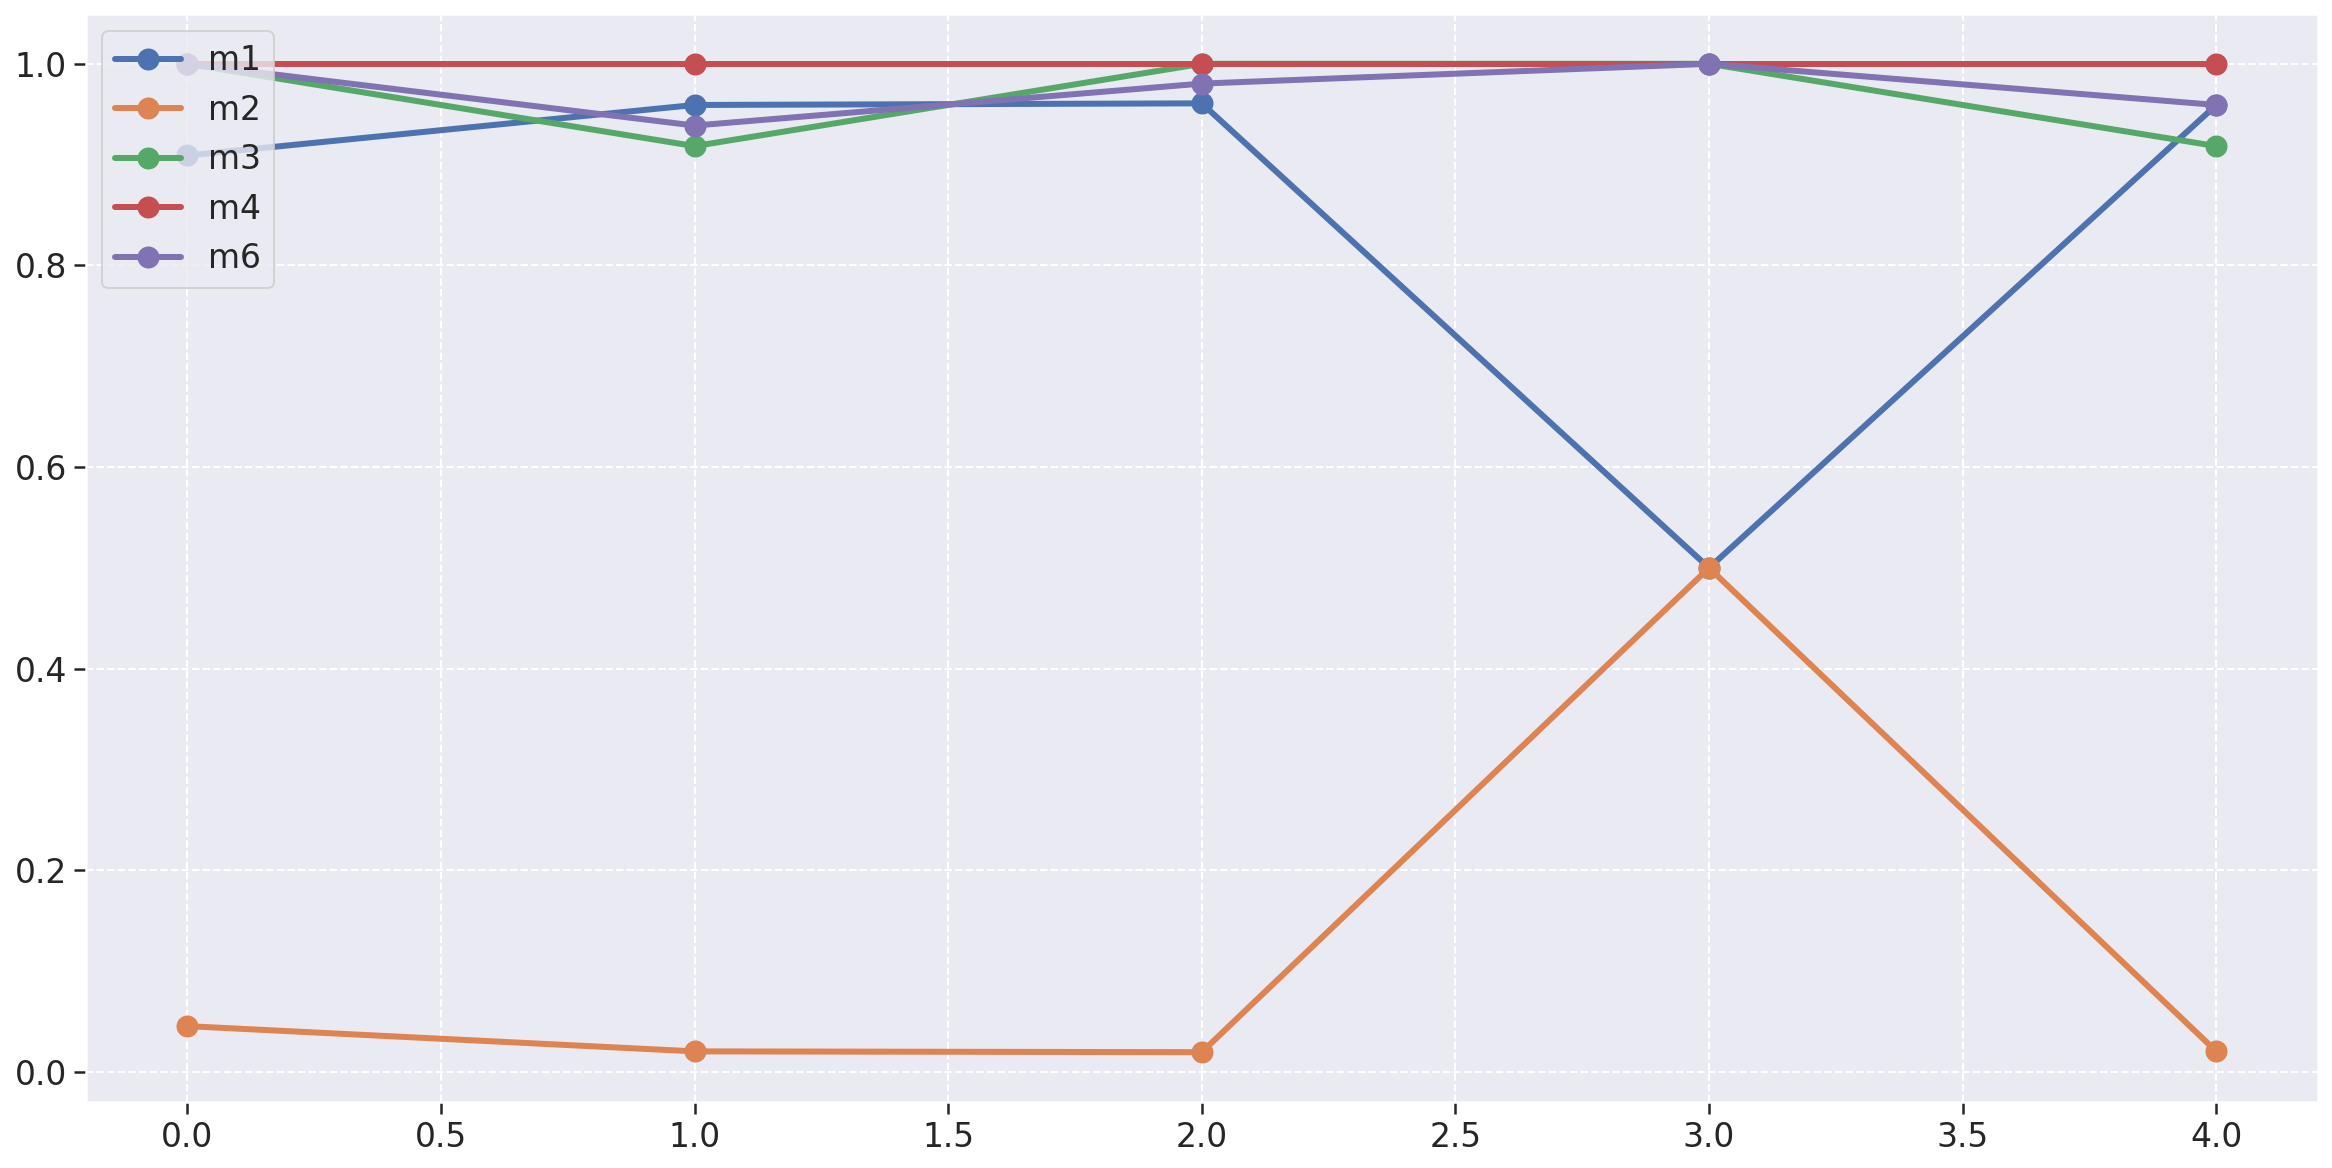

In [26]:
fig = plt.figure(figsize=(20, 10))

plt.plot(frontend_metrics['m1'], linewidth=3, marker='o', markersize=10, label='m1')
plt.plot(frontend_metrics['m2'], linewidth=3, marker='o', markersize=10, label='m2')
plt.plot(frontend_metrics['m3'], linewidth=3, marker='o', markersize=10, label='m3')
plt.plot(frontend_metrics['m4'], linewidth=3, marker='o', markersize=10, label='m4')
plt.plot(frontend_metrics['m6'], linewidth=3, marker='o', markersize=10, label='m6')

plt.legend(loc='upper left')

### Sub characteristic aggregation

- You must do this for each of your repositories

In [27]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33

pm4 = 0.3
pm6 = 0.7

archives_metrics['code_quality'] = ((archives_metrics['m1']*pm1)+(archives_metrics['m2']*pm2)+(archives_metrics['m3']*pm3))*psc1
profile_metrics['code_quality'] = ((profile_metrics['m1']*pm1)+(profile_metrics['m2']*pm2)+(profile_metrics['m3']*pm3))*psc1
frontend_metrics['code_quality'] = ((frontend_metrics['m1']*pm1)+(frontend_metrics['m2']*pm2)+(frontend_metrics['m3']*pm3))*psc1

archives_metrics['testing_status'] = ((archives_metrics['m4']*pm4)+(archives_metrics['m6']*pm6))*psc2
profile_metrics['testing_status'] = ((profile_metrics['m4']*pm4)+(profile_metrics['m6']*pm6))*psc2
frontend_metrics['testing_status'] = ((frontend_metrics['m4']*pm4)+(frontend_metrics['m6']*pm6))*psc2

## Code Quality 

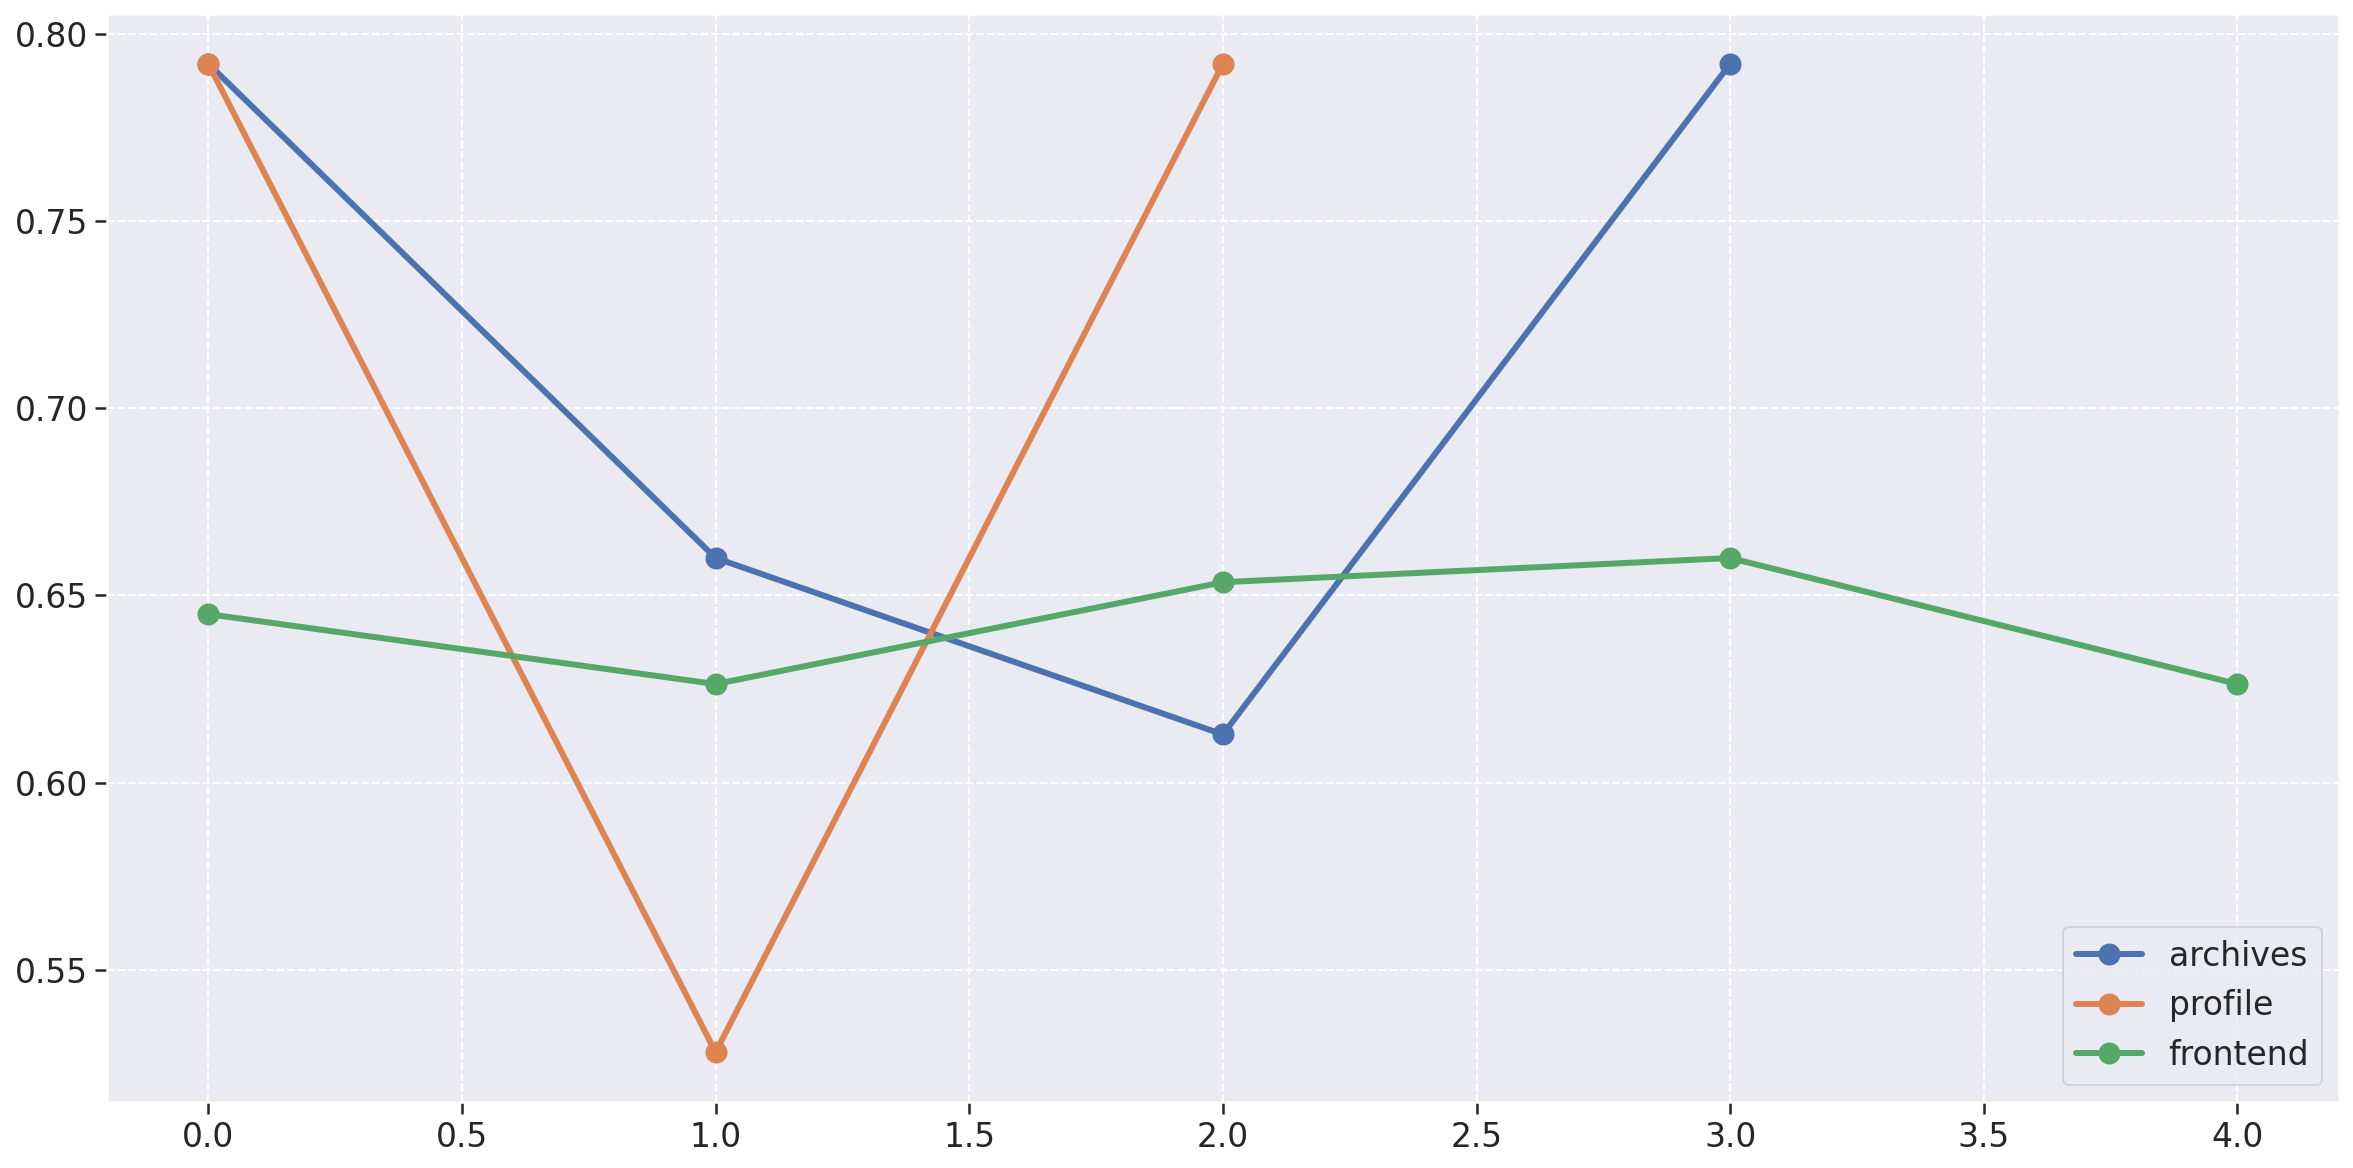

In [29]:
fig = plt.figure(figsize=(20, 10))

plt.plot(archives_metrics['code_quality'], linewidth=3, marker='o', markersize=10, label='archives')
plt.plot(profile_metrics['code_quality'], linewidth=3, marker='o', markersize=10, label='profile')
plt.plot(frontend_metrics['code_quality'], linewidth=3, marker='o', markersize=10, label='frontend')

plt.legend(loc='lower right')

## Testing Status

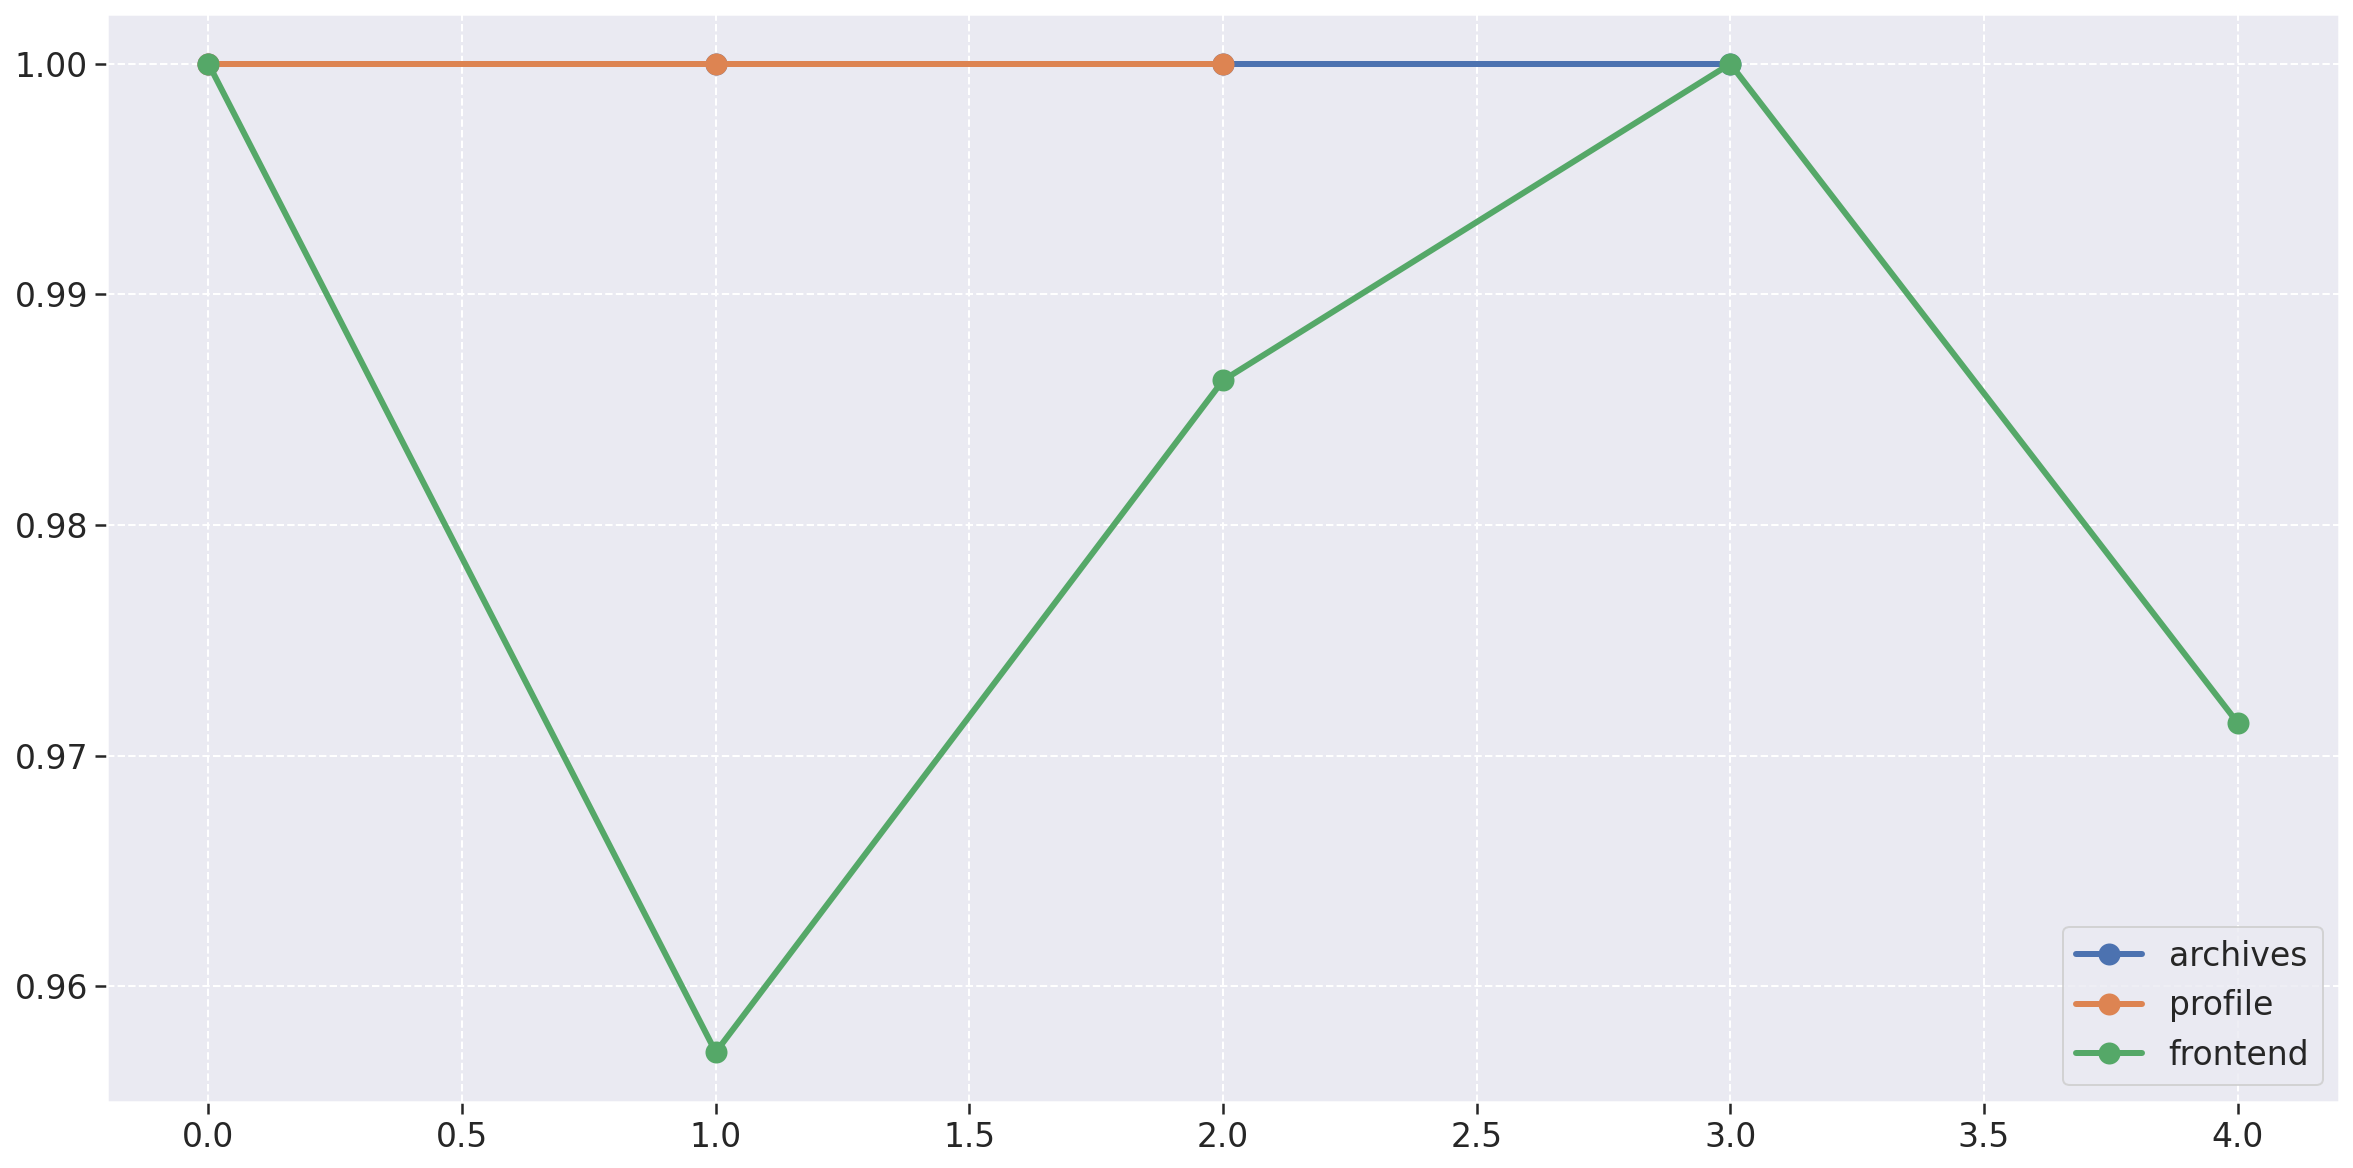

In [32]:
fig = plt.figure(figsize=(20, 10))

plt.plot(archives_metrics['testing_status'], linewidth=3, marker='o', markersize=10, label='archives')
plt.plot(profile_metrics['testing_status'], linewidth=3, marker='o', markersize=10, label='profile')
plt.plot(frontend_metrics['testing_status'], linewidth=3, marker='o', markersize=10, label='frontend')

plt.legend(loc='lower right')

## All Metrics

In [33]:
metrics_df = pd.concat([archives_metrics, profile_metrics, frontend_metrics], ignore_index=True)

metrics_df.insert(5, 'Maintainability', metrics_df['code_quality'] * pc1)
metrics_df.insert(6, 'Reliability', metrics_df['testing_status'] * pc2)
metrics_df.insert(7, 'Total_QR', metrics_df['Maintainability'] + metrics_df['Reliability'])
metrics_df.insert(8, 'LOC', metrics_df['ncloc'])
metrics_df.insert(9, 'Repository', metrics_df['repository'])
metrics_df.insert(10, 'Version', metrics_df['version'])
metrics_df.drop('ncloc', axis=1, inplace=True)
metrics_df.drop('repository', axis=1, inplace=True)
metrics_df.drop('code_quality', axis=1, inplace=True)
metrics_df.drop('testing_status', axis=1, inplace=True)
metrics_df.drop('version', axis=1, inplace=True)
metrics_df['Data'] = metrics_df['Version']

In [34]:
metrics_df

,m1,m2,m3,m4,m6,Maintainability,Reliability,Total_QR,LOC,Repository,Version,Data
0,1.000000,0.400000,1.000000,1.0,1.000000,0.396000,0.500000,0.896000,200,Archives,03-10-2021-15-47,03-10-2021-15-47
1,0.428571,0.571429,1.000000,1.0,1.000000,0.330000,0.500000,0.830000,428,Archives,03-11-2021-02-10,03-11-2021-02-10
2,0.428571,0.428571,1.000000,1.0,1.000000,0.306429,0.500000,0.806429,593,Archives,08-11-2021-23-31,08-11-2021-23-31
3,1.000000,0.400000,1.000000,1.0,1.000000,0.396000,0.500000,0.896000,109,Archives,13-09-2021-15-00,13-09-2021-15-00
4,1.000000,0.400000,1.000000,1.0,1.000000,0.396000,0.500000,0.896000,112,Profile,03-10-2021-15-48,03-10-2021-15-48
5,0.200000,0.400000,1.000000,1.0,1.000000,0.264000,0.500000,0.764000,155,Profile,08-11-2021-23-31,08-11-2021-23-31
6,1.000000,0.400000,1.000000,1.0,1.000000,0.396000,0.500000,0.896000,112,Profile,13-09-2021-14-00,13-09-2021-14-00
7,0.909091,0.045455,1.000000,1.0,1.000000,0.322500,0.500000,0.822500,1401,Frontend,03-10-2021-15-49,03-10-2021-15-49
8,0.959184,0.020408,0.918367,1.0,0.938776,0.313163,0.478571,0.791735,4888,Frontend,03-11-2021-02-08,03-11-2021-02-08
9,0.960784,0.019608,1.000000,1.0,0.980392,0.326765,0.493137,0.819902,5638,Frontend,08-11-2021-23-30,08-11-2021-23-30


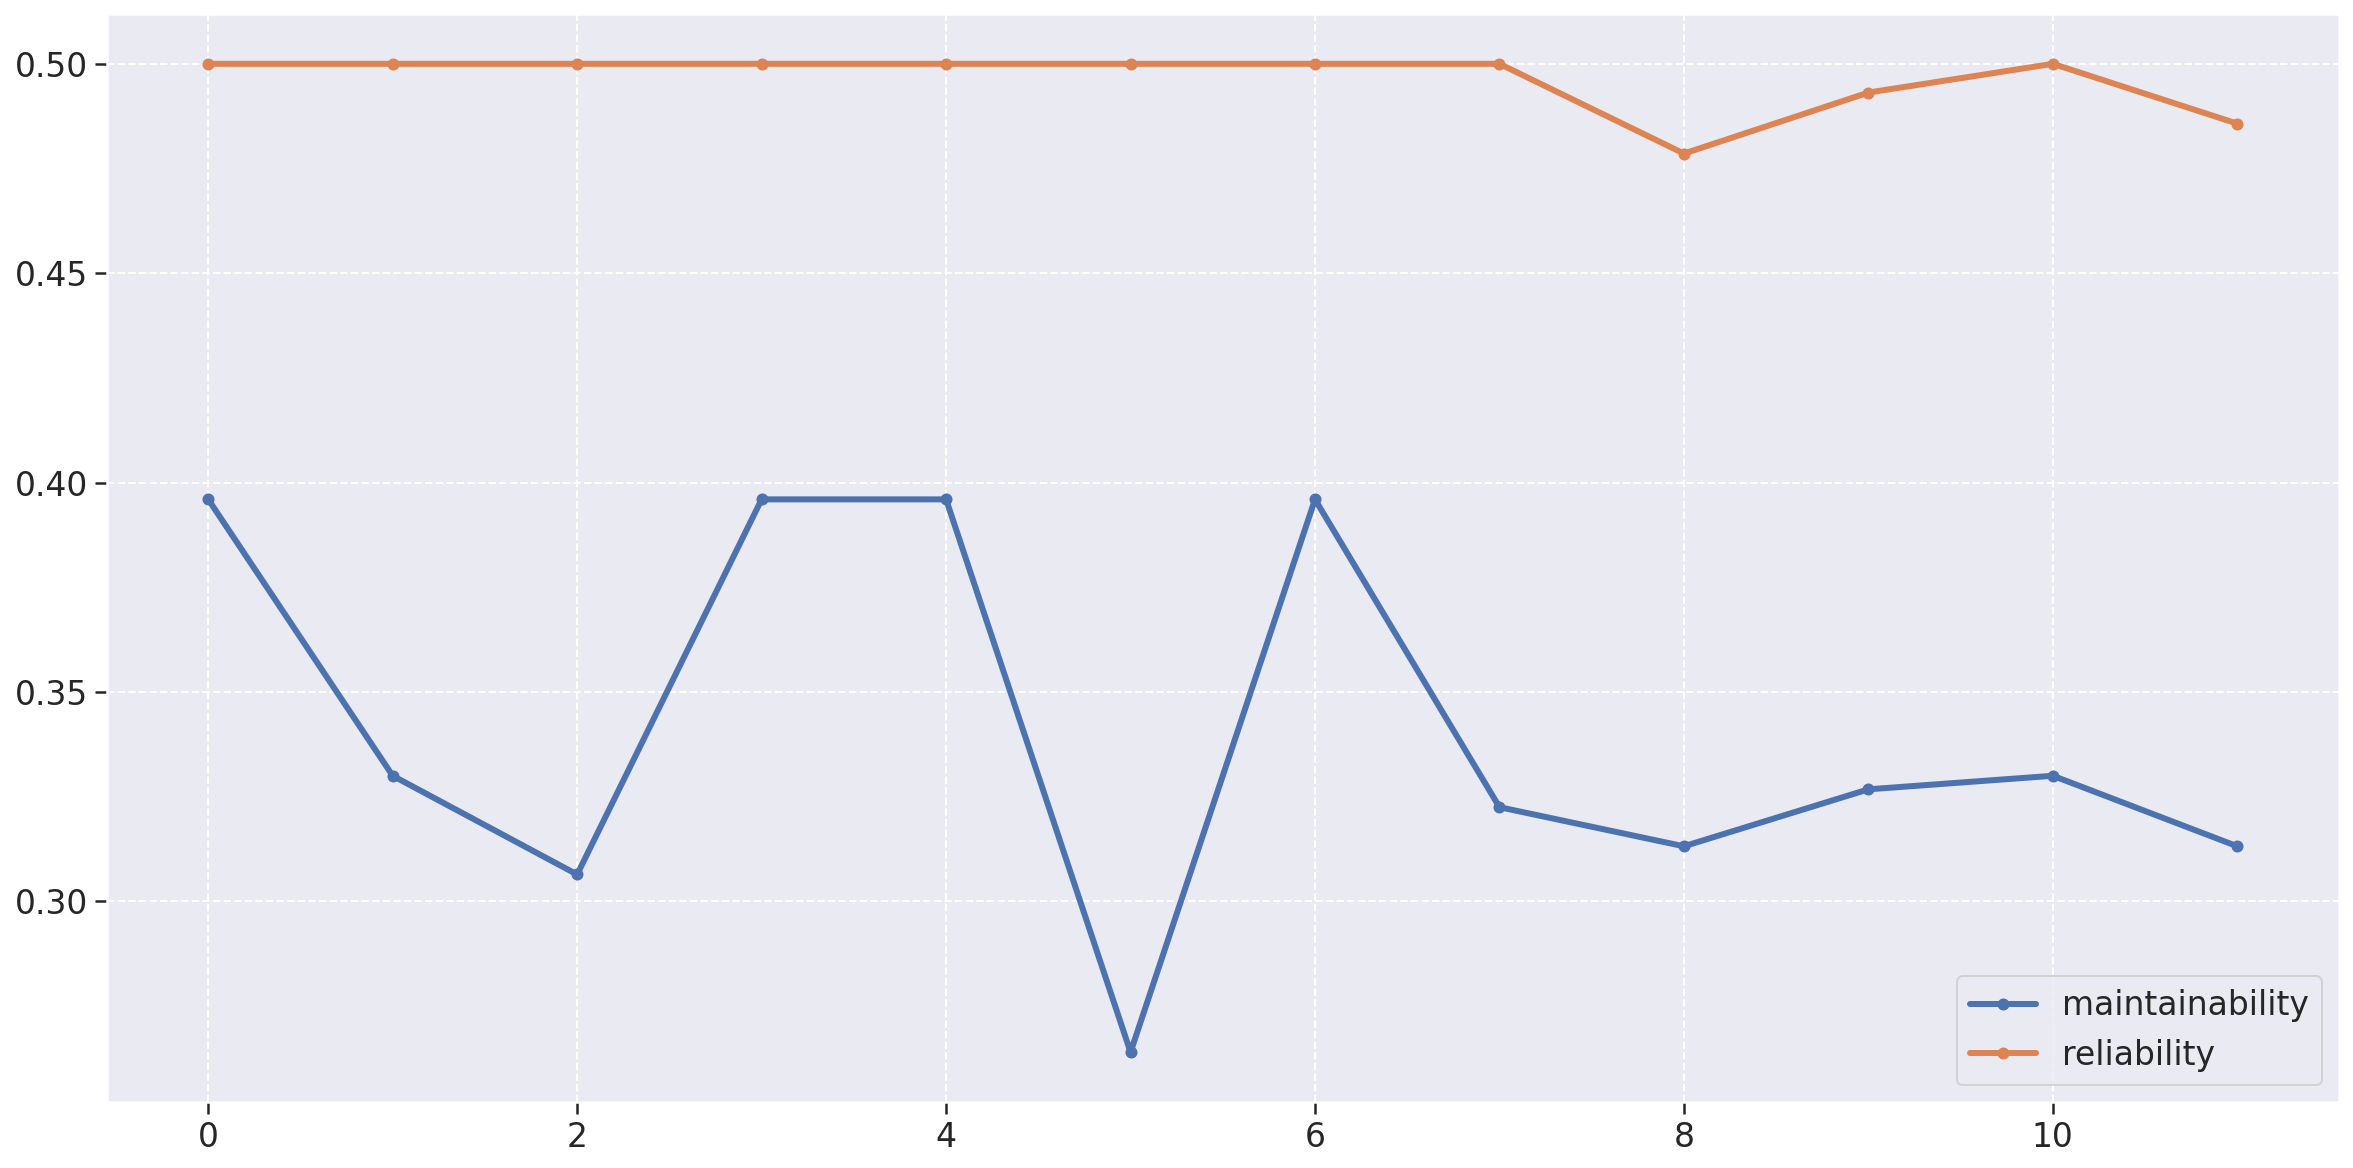

In [35]:
fig = plt.figure(figsize=(20, 10))

plt.plot(metrics_df['Maintainability'], linewidth=3, marker='o', markersize=5, label='maintainability')
plt.plot(metrics_df['Reliability'], linewidth=3, marker='o', markersize=5, label='reliability')

plt.legend(loc='lower right')

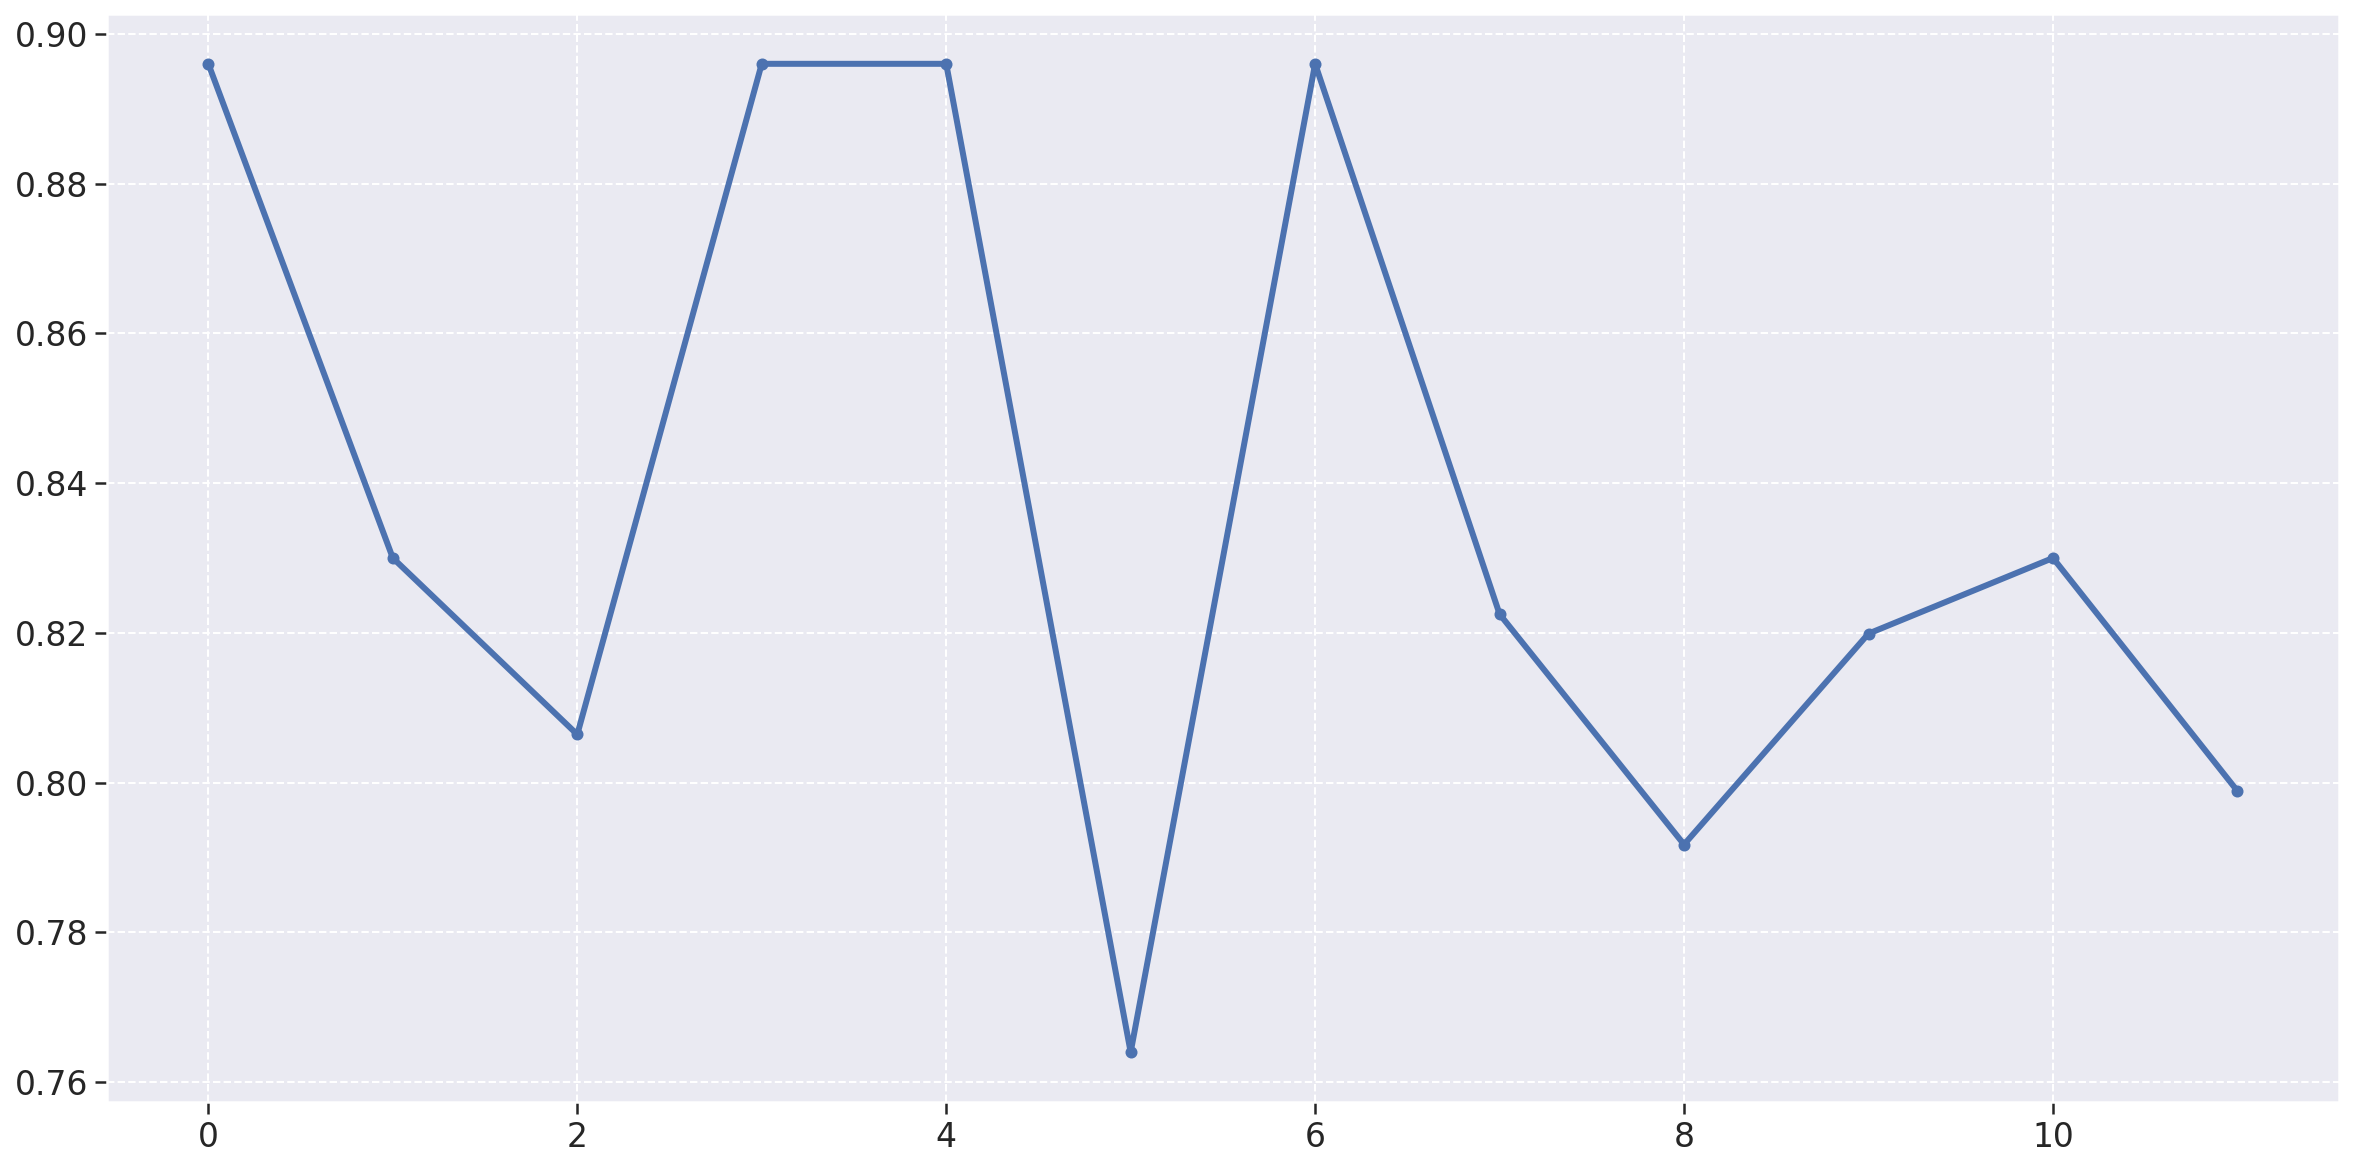

In [36]:
fig = plt.figure(figsize=(20, 10))

plt.plot(metrics_df['Total_QR'], linewidth=3, marker='o', markersize=5)

# Descriptive Statistics

In [37]:
metrics_df

,m1,m2,m3,m4,m6,Maintainability,Reliability,Total_QR,LOC,Repository,Version,Data
0,1.000000,0.400000,1.000000,1.0,1.000000,0.396000,0.500000,0.896000,200,Archives,03-10-2021-15-47,03-10-2021-15-47
1,0.428571,0.571429,1.000000,1.0,1.000000,0.330000,0.500000,0.830000,428,Archives,03-11-2021-02-10,03-11-2021-02-10
2,0.428571,0.428571,1.000000,1.0,1.000000,0.306429,0.500000,0.806429,593,Archives,08-11-2021-23-31,08-11-2021-23-31
3,1.000000,0.400000,1.000000,1.0,1.000000,0.396000,0.500000,0.896000,109,Archives,13-09-2021-15-00,13-09-2021-15-00
4,1.000000,0.400000,1.000000,1.0,1.000000,0.396000,0.500000,0.896000,112,Profile,03-10-2021-15-48,03-10-2021-15-48
5,0.200000,0.400000,1.000000,1.0,1.000000,0.264000,0.500000,0.764000,155,Profile,08-11-2021-23-31,08-11-2021-23-31
6,1.000000,0.400000,1.000000,1.0,1.000000,0.396000,0.500000,0.896000,112,Profile,13-09-2021-14-00,13-09-2021-14-00
7,0.909091,0.045455,1.000000,1.0,1.000000,0.322500,0.500000,0.822500,1401,Frontend,03-10-2021-15-49,03-10-2021-15-49
8,0.959184,0.020408,0.918367,1.0,0.938776,0.313163,0.478571,0.791735,4888,Frontend,03-11-2021-02-08,03-11-2021-02-08
9,0.960784,0.019608,1.000000,1.0,0.980392,0.326765,0.493137,0.819902,5638,Frontend,08-11-2021-23-30,08-11-2021-23-30


# Values Dataframe

In [38]:
descriptive_statistics_df = pd.DataFrame()

descriptive_statistics_df['mode_reliability'] = metrics_df['Reliability'].mode()
descriptive_statistics_df['mode_maintainability'] = metrics_df['Maintainability'].mode()
descriptive_statistics_df['median_reliability'] = metrics_df['Reliability'].median()
descriptive_statistics_df['median_maintainability'] = metrics_df['Maintainability'].median()
descriptive_statistics_df['mean_reliability'] = metrics_df['Reliability'].mean()
descriptive_statistics_df['mean_maintainability'] = metrics_df['Maintainability'].mean()
descriptive_statistics_df['max_reliability'] = metrics_df['Reliability'].max()
descriptive_statistics_df['max_maintainability'] = metrics_df['Maintainability'].max()
descriptive_statistics_df['min_reliability'] = metrics_df['Reliability'].min()
descriptive_statistics_df['min_maintainability'] = metrics_df['Maintainability'].min()
descriptive_statistics_df['std_dev_reliability'] = metrics_df['Reliability'].std()
descriptive_statistics_df['std_dev_maintainability'] = metrics_df['Maintainability'].std()
descriptive_statistics_df['variance_reliability'] = metrics_df['Reliability'].var()
descriptive_statistics_df['variance_maintainability'] = metrics_df['Maintainability'].var()

descriptive_statistics_df

,mode_reliability,mode_maintainability,median_reliability,median_maintainability,mean_reliability,mean_maintainability,max_reliability,max_maintainability,min_reliability,min_maintainability,std_dev_reliability,std_dev_maintainability,variance_reliability,variance_maintainability
0,0.5,0.396,0.5,0.328382,0.496452,0.340835,0.5,0.396,0.478571,0.264,0.007131,0.044272,0.000051,0.00196


# Archives

In [39]:
descriptive_statistics_archives = pd.DataFrame()

descriptive_statistics_archives['mode_reliability'] = archives_metrics['testing_status'].mode()
descriptive_statistics_archives['mode_maintainability'] = archives_metrics['code_quality'].mode()
descriptive_statistics_archives['median_reliability'] = archives_metrics['testing_status'].median()
descriptive_statistics_archives['median_maintainability'] = archives_metrics['code_quality'].median()
descriptive_statistics_archives['mean_reliability'] = archives_metrics['testing_status'].mean()
descriptive_statistics_archives['mean_maintainability'] = archives_metrics['code_quality'].mean()
descriptive_statistics_archives['max_reliability'] = archives_metrics['testing_status'].max()
descriptive_statistics_archives['max_maintainability'] = archives_metrics['code_quality'].max()
descriptive_statistics_archives['min_reliability'] = archives_metrics['testing_status'].min()
descriptive_statistics_archives['min_maintainability'] = archives_metrics['code_quality'].min()
descriptive_statistics_archives['std_dev_reliability'] = archives_metrics['testing_status'].std()
descriptive_statistics_archives['std_dev_maintainability'] = archives_metrics['code_quality'].std()
descriptive_statistics_archives['variance_reliability'] = archives_metrics['testing_status'].var()
descriptive_statistics_archives['variance_maintainability'] = archives_metrics['code_quality'].var()

descriptive_statistics_archives

,mode_reliability,mode_maintainability,median_reliability,median_maintainability,mean_reliability,mean_maintainability,max_reliability,max_maintainability,min_reliability,min_maintainability,std_dev_reliability,std_dev_maintainability,variance_reliability,variance_maintainability
0,1.0,0.792,1.0,0.726,1.0,0.714214,1.0,0.792,1.0,0.612857,0.0,0.091858,0.0,0.008438


In [40]:
archives_metrics

,m1,m2,m3,m4,m6,repository,version,ncloc,code_quality,testing_status
0,1.000000,0.400000,1.0,1.0,1.0,Archives,03-10-2021-15-47,200,0.792000,1.0
1,0.428571,0.571429,1.0,1.0,1.0,Archives,03-11-2021-02-10,428,0.660000,1.0
2,0.428571,0.428571,1.0,1.0,1.0,Archives,08-11-2021-23-31,593,0.612857,1.0
3,1.000000,0.400000,1.0,1.0,1.0,Archives,13-09-2021-15-00,109,0.792000,1.0


## Heatmap (Correlation Matrix)

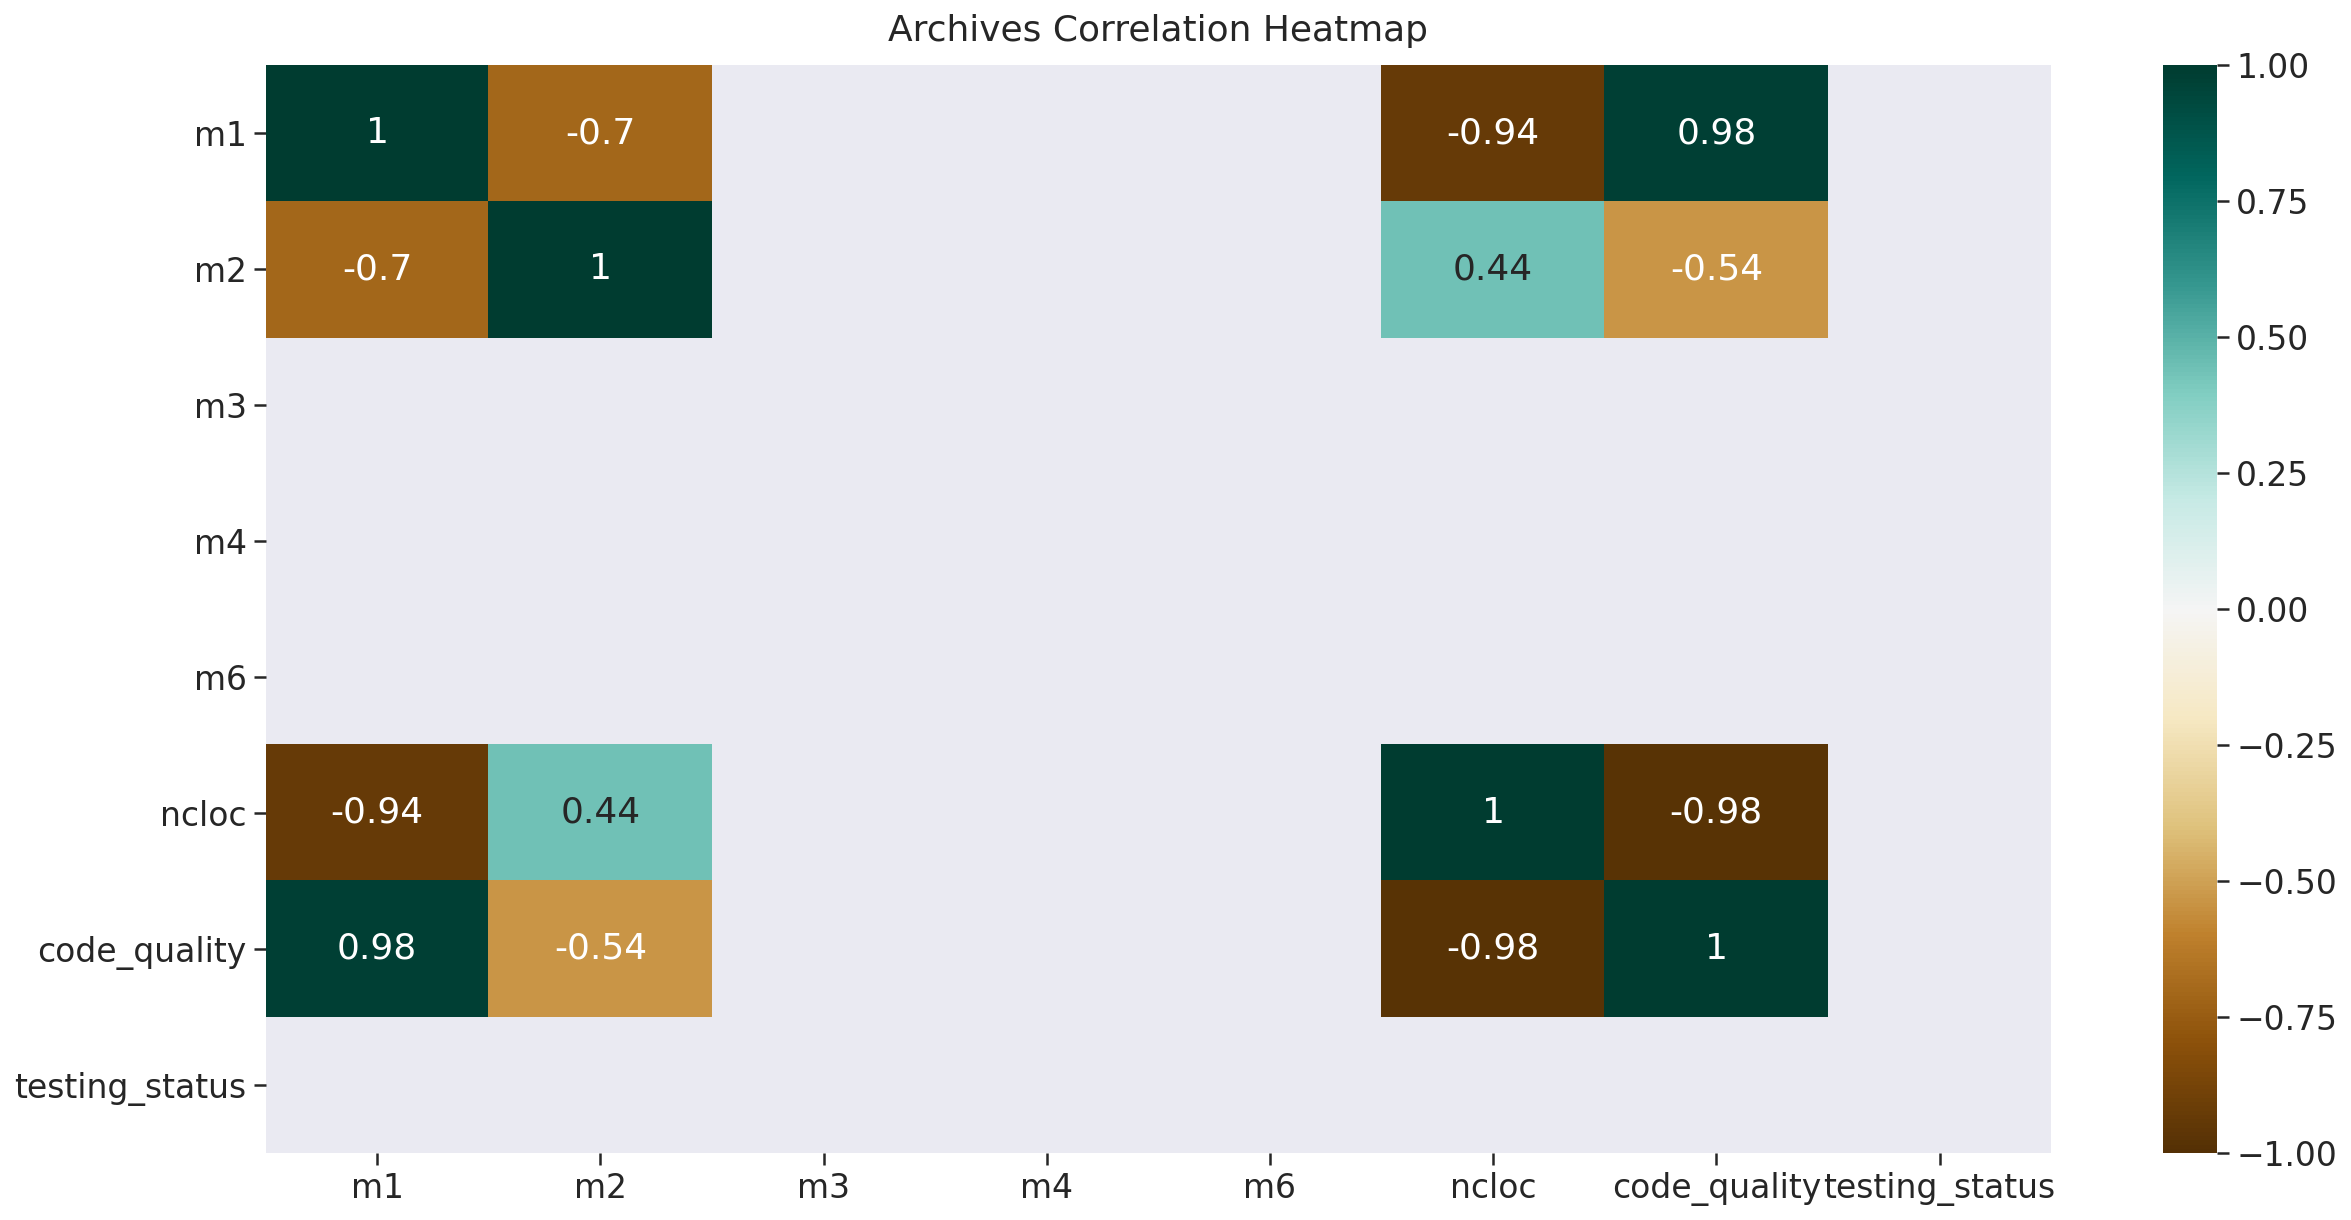

In [41]:
plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(archives_metrics.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Archives Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

### Areas in grey have the standard deviation equals to 0.0, so it's impossible to calculate the correlation at that specific cell

## Histograms

### Code Quality

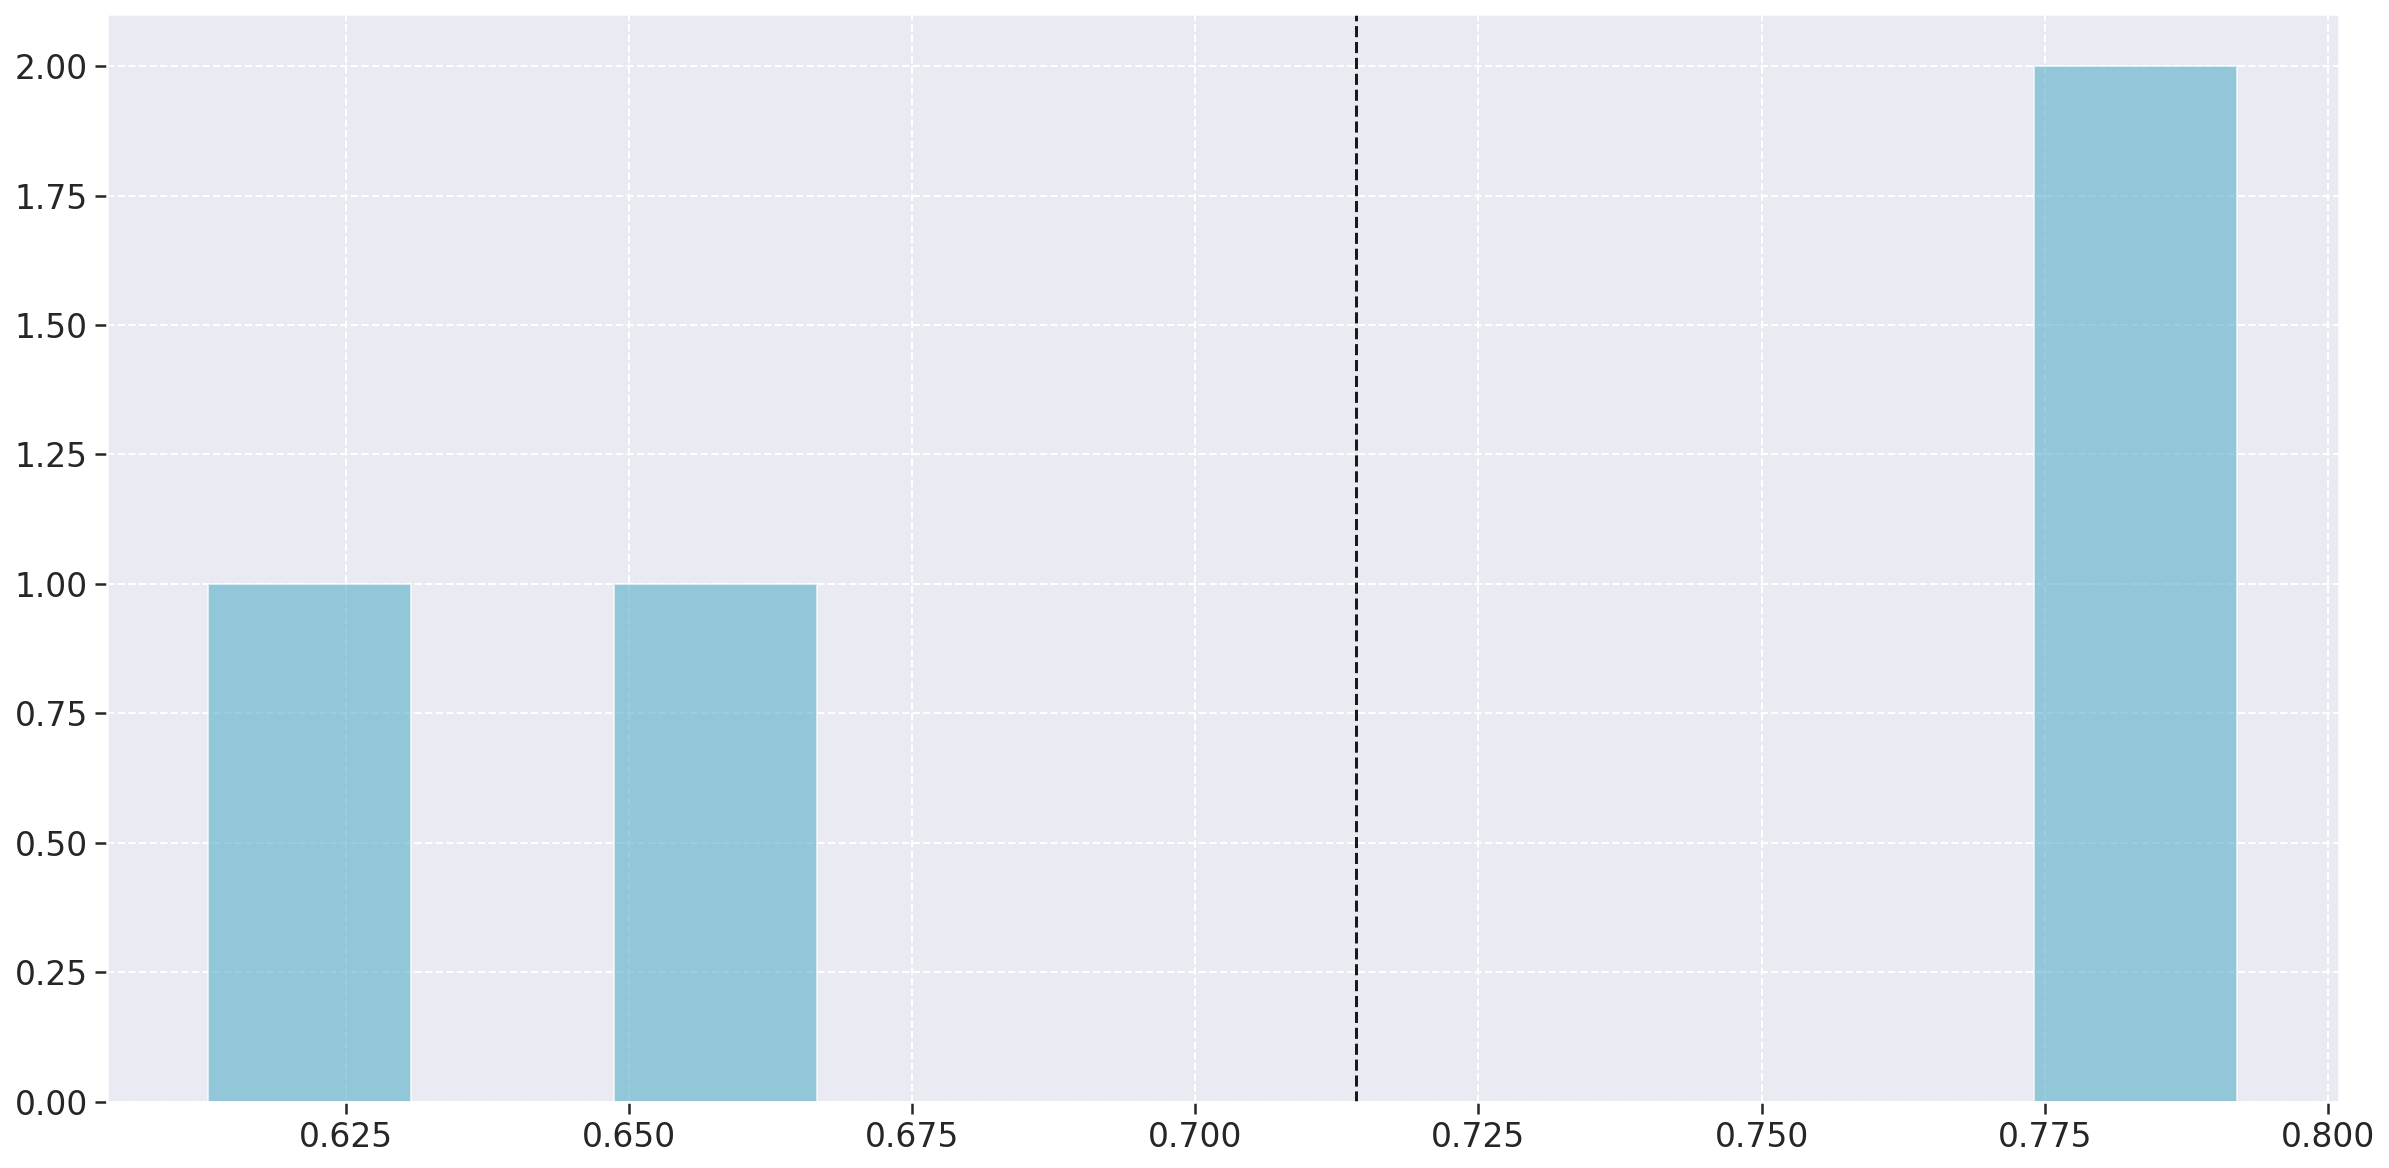

In [42]:
fig = plt.figure(figsize=(20, 10))

plt.hist(archives_metrics['code_quality'], bins=10, color='c', alpha=0.65)
plt.axvline(archives_metrics['code_quality'].mean(), color='k', linestyle='dashed')

### Testing Status

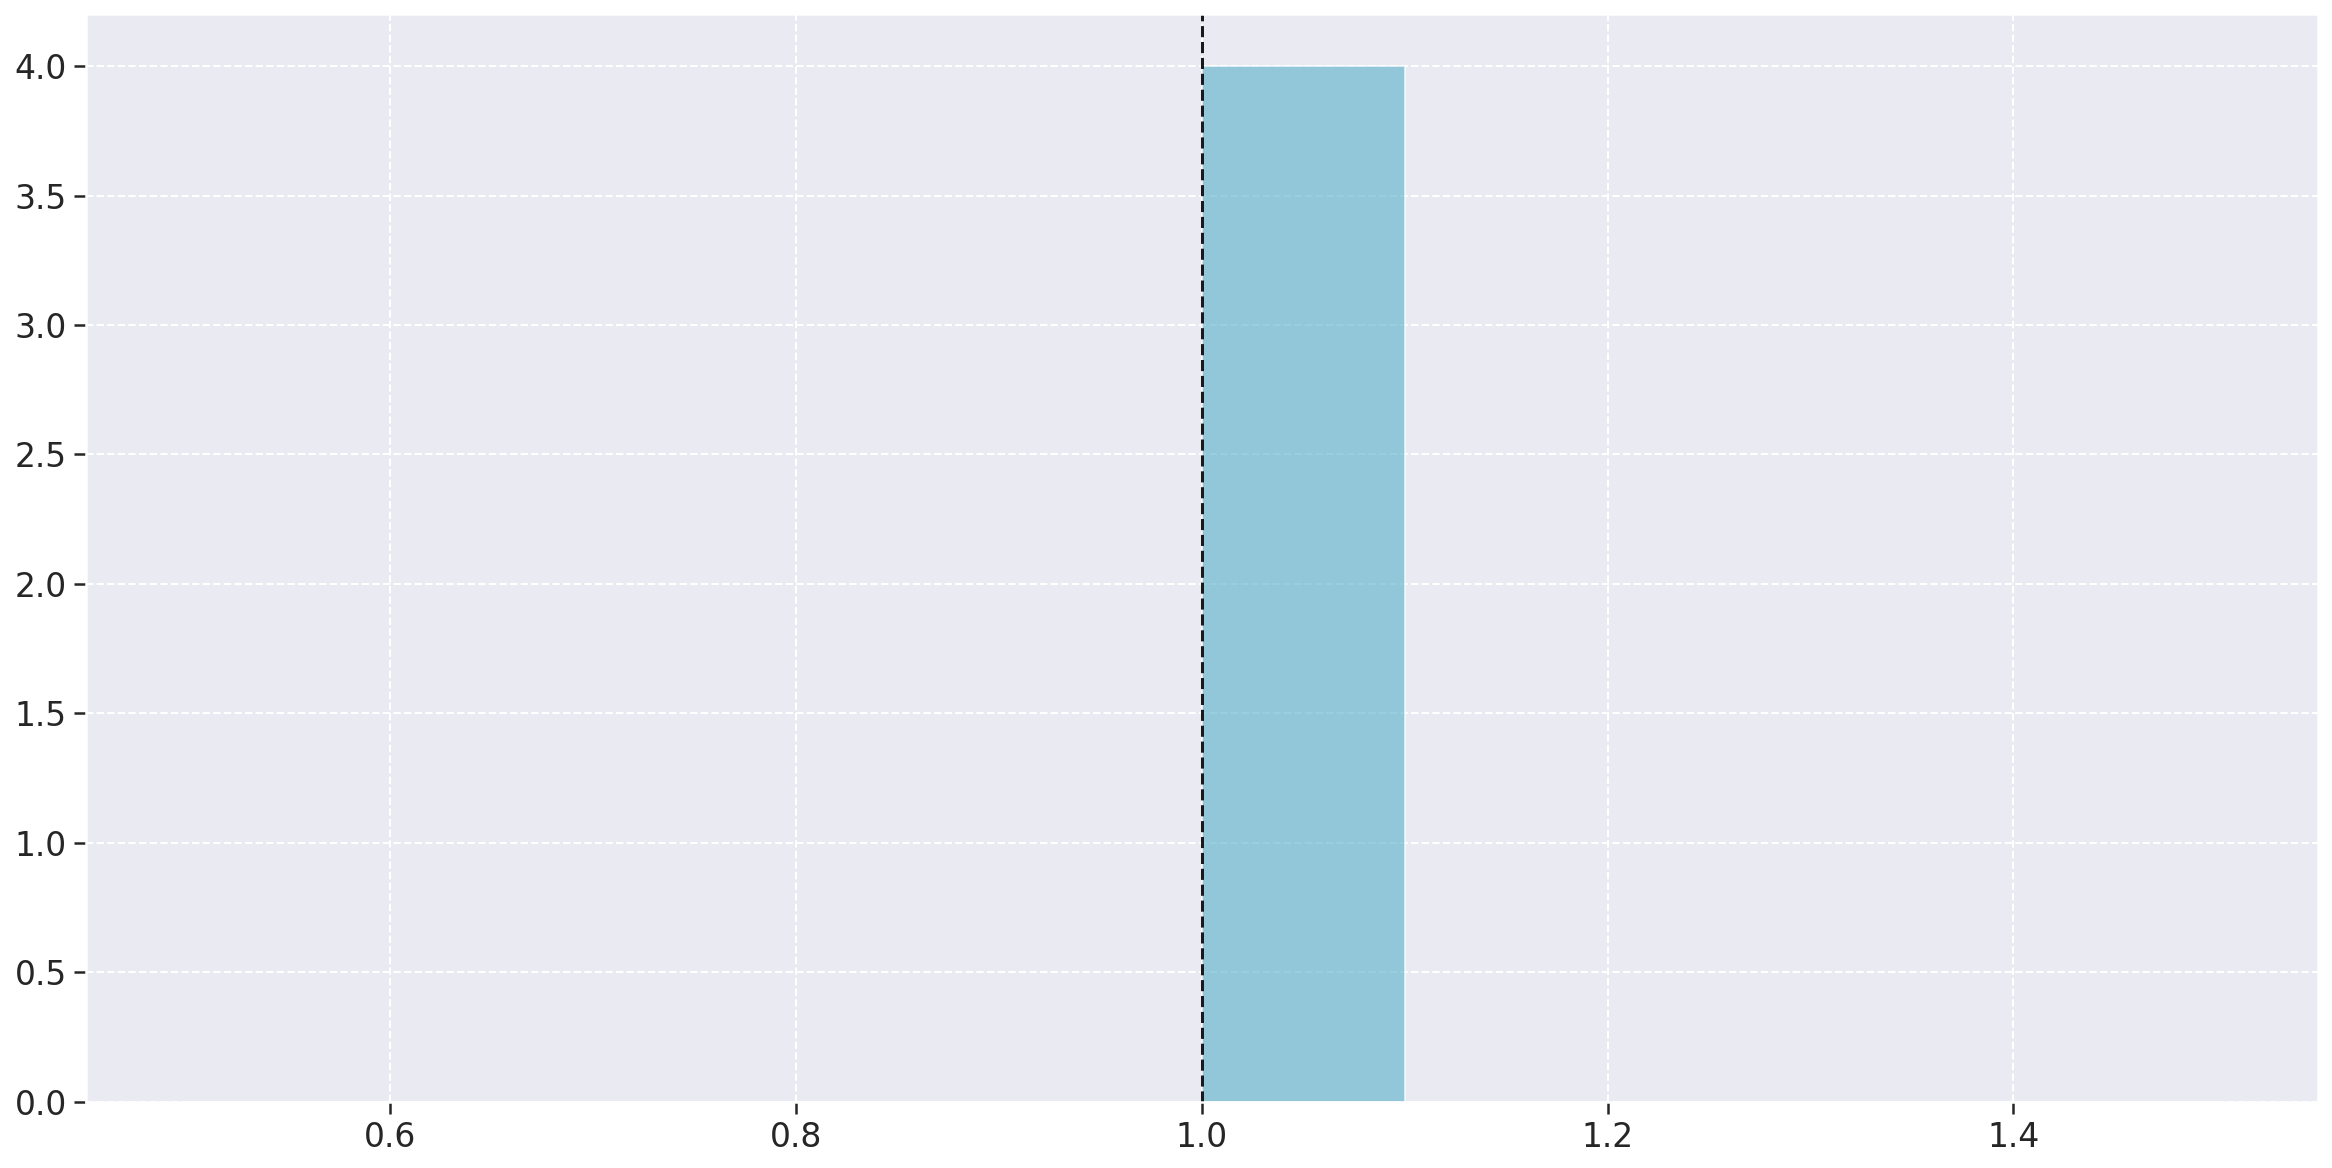

In [43]:
fig = plt.figure(figsize=(20, 10))

plt.hist(archives_metrics['testing_status'], bins=10, color='c', alpha=0.65)
plt.axvline(archives_metrics['testing_status'].mean(), color='k', linestyle='dashed')

## Boxplot

### Code Quality

{'whiskers': [<matplotlib.lines.Line2D at 0x7fa022910a20>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa022910f98>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa022910978>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa022920588>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa022920860>],
 'means': []}

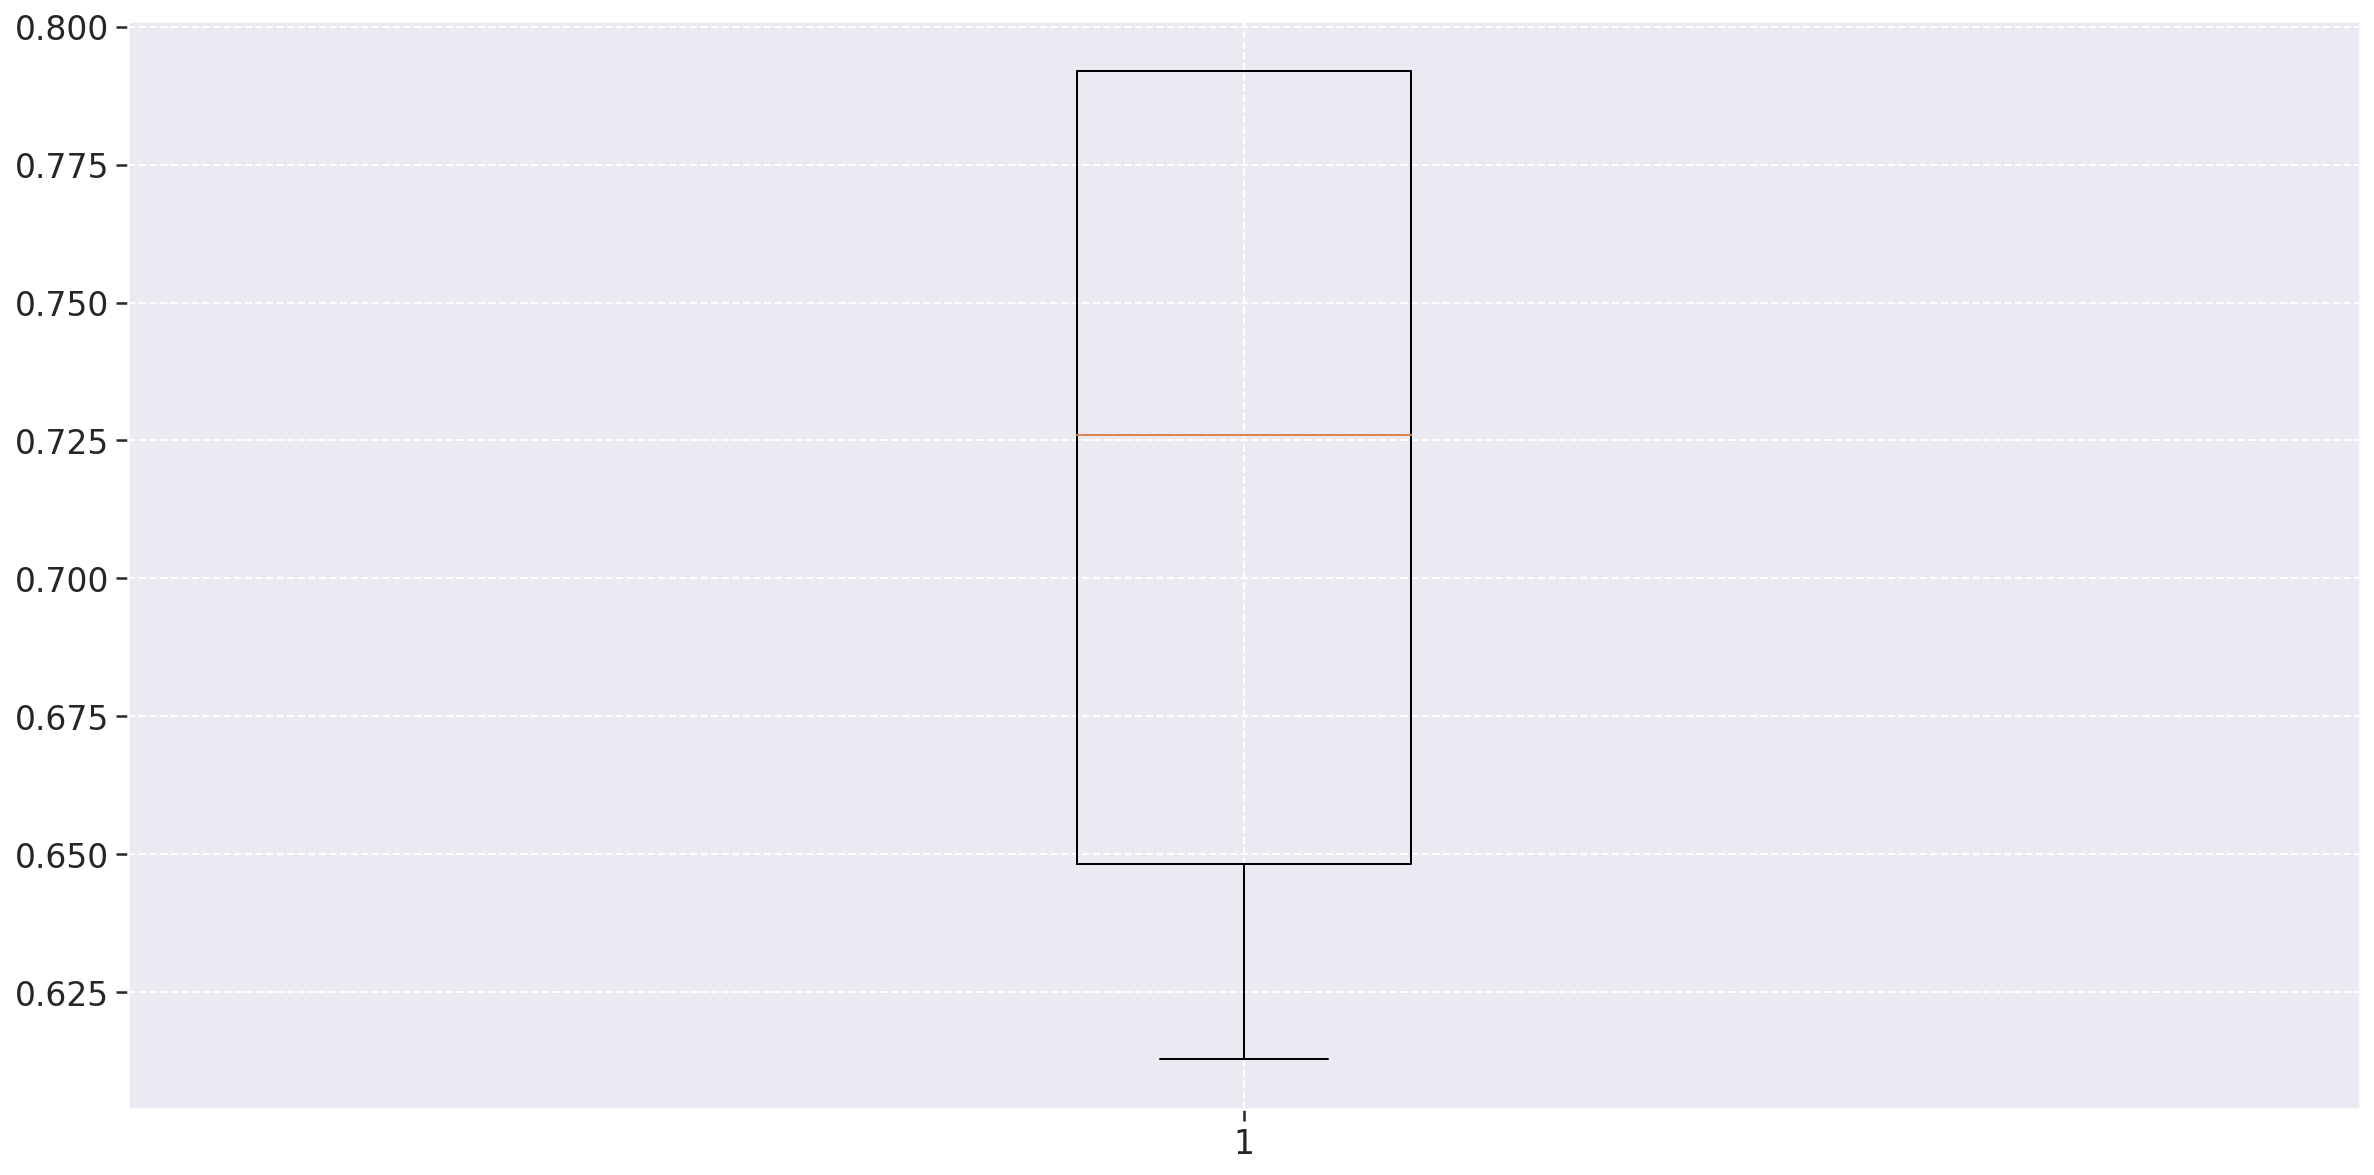

In [44]:
fig = plt.figure(figsize=(20, 10))

plt.boxplot(archives_metrics['code_quality'])

### Testing Status

{'whiskers': [<matplotlib.lines.Line2D at 0x7fa0229097b8>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa022909d30>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa022909710>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa022896320>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa0228965f8>],
 'means': []}

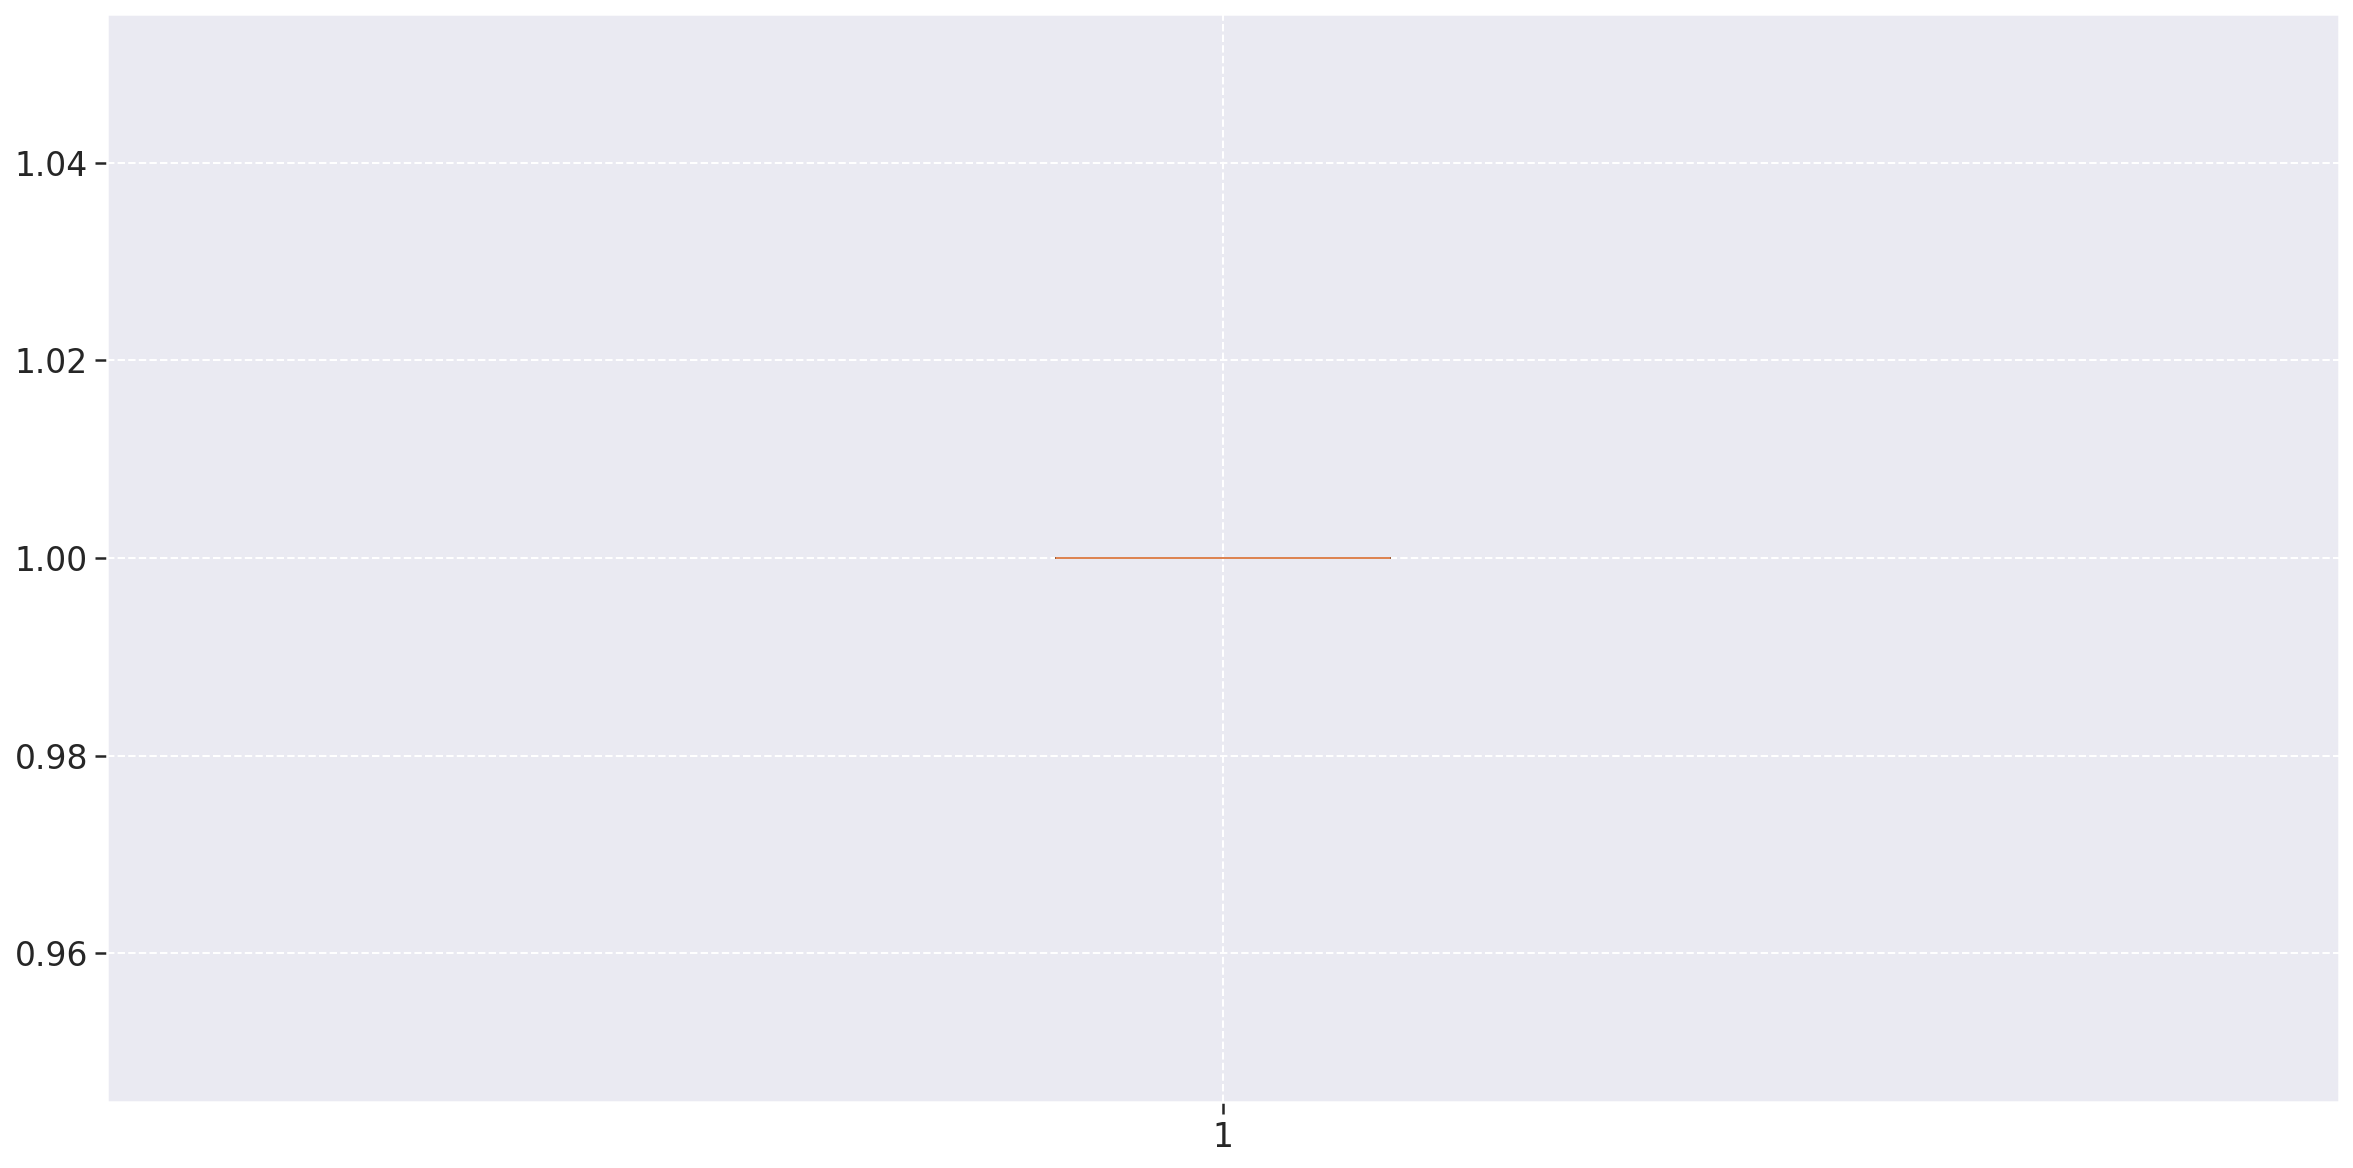

In [45]:
fig = plt.figure(figsize=(20, 10))

plt.boxplot(archives_metrics['testing_status'])

## Analysis

### Code Quality

It's possible to see at the **boxplot** that the range of the metric is not that big, having a min close to .6 and a max close to .79, and the median is, basically, at the third quartile.
But we can also see that the metric wich decreased the total value is m1, wich means the code now has a pretty complex file.
We can see at the **histogram** that in 2 releases the repository got the same value for the metric, but it decreased as we see in the dataframe.

### Testing Status

All of the testing status values where 1 after discarding unnecessary files to be tested (setup files) as we can see in the single line **boxplot** and single column **histogram**

# Profile

In [46]:
descriptive_statistics_profile = pd.DataFrame()

descriptive_statistics_profile['mode_reliability'] = profile_metrics['testing_status'].mode()
descriptive_statistics_profile['mode_maintainability'] = profile_metrics['code_quality'].mode()
descriptive_statistics_profile['median_reliability'] = profile_metrics['testing_status'].median()
descriptive_statistics_profile['median_maintainability'] = profile_metrics['code_quality'].median()
descriptive_statistics_profile['mean_reliability'] = profile_metrics['testing_status'].mean()
descriptive_statistics_profile['mean_maintainability'] = profile_metrics['code_quality'].mean()
descriptive_statistics_profile['max_reliability'] = profile_metrics['testing_status'].max()
descriptive_statistics_profile['max_maintainability'] = profile_metrics['code_quality'].max()
descriptive_statistics_profile['min_reliability'] = profile_metrics['testing_status'].min()
descriptive_statistics_profile['min_maintainability'] = profile_metrics['code_quality'].min()
descriptive_statistics_profile['std_dev_reliability'] = profile_metrics['testing_status'].std()
descriptive_statistics_profile['std_dev_maintainability'] = profile_metrics['code_quality'].std()
descriptive_statistics_profile['variance_reliability'] = profile_metrics['testing_status'].var()
descriptive_statistics_profile['variance_maintainability'] = profile_metrics['code_quality'].var()

descriptive_statistics_profile

,mode_reliability,mode_maintainability,median_reliability,median_maintainability,mean_reliability,mean_maintainability,max_reliability,max_maintainability,min_reliability,min_maintainability,std_dev_reliability,std_dev_maintainability,variance_reliability,variance_maintainability
0,1.0,0.792,1.0,0.792,1.0,0.704,1.0,0.792,1.0,0.528,0.0,0.15242,0.0,0.023232


In [47]:
profile_metrics

,m1,m2,m3,m4,m6,repository,version,ncloc,code_quality,testing_status
0,1.0,0.4,1.0,1.0,1.0,Profile,03-10-2021-15-48,112,0.792,1.0
1,0.2,0.4,1.0,1.0,1.0,Profile,08-11-2021-23-31,155,0.528,1.0
2,1.0,0.4,1.0,1.0,1.0,Profile,13-09-2021-14-00,112,0.792,1.0


## Heatmap (Correlation Matrix)

## Histograms

### As we can see at the descriptive statistics dataframe from the repository, the standard deviation is 0.0, so it's impossible to generate a correlation matrix

### Code Quality

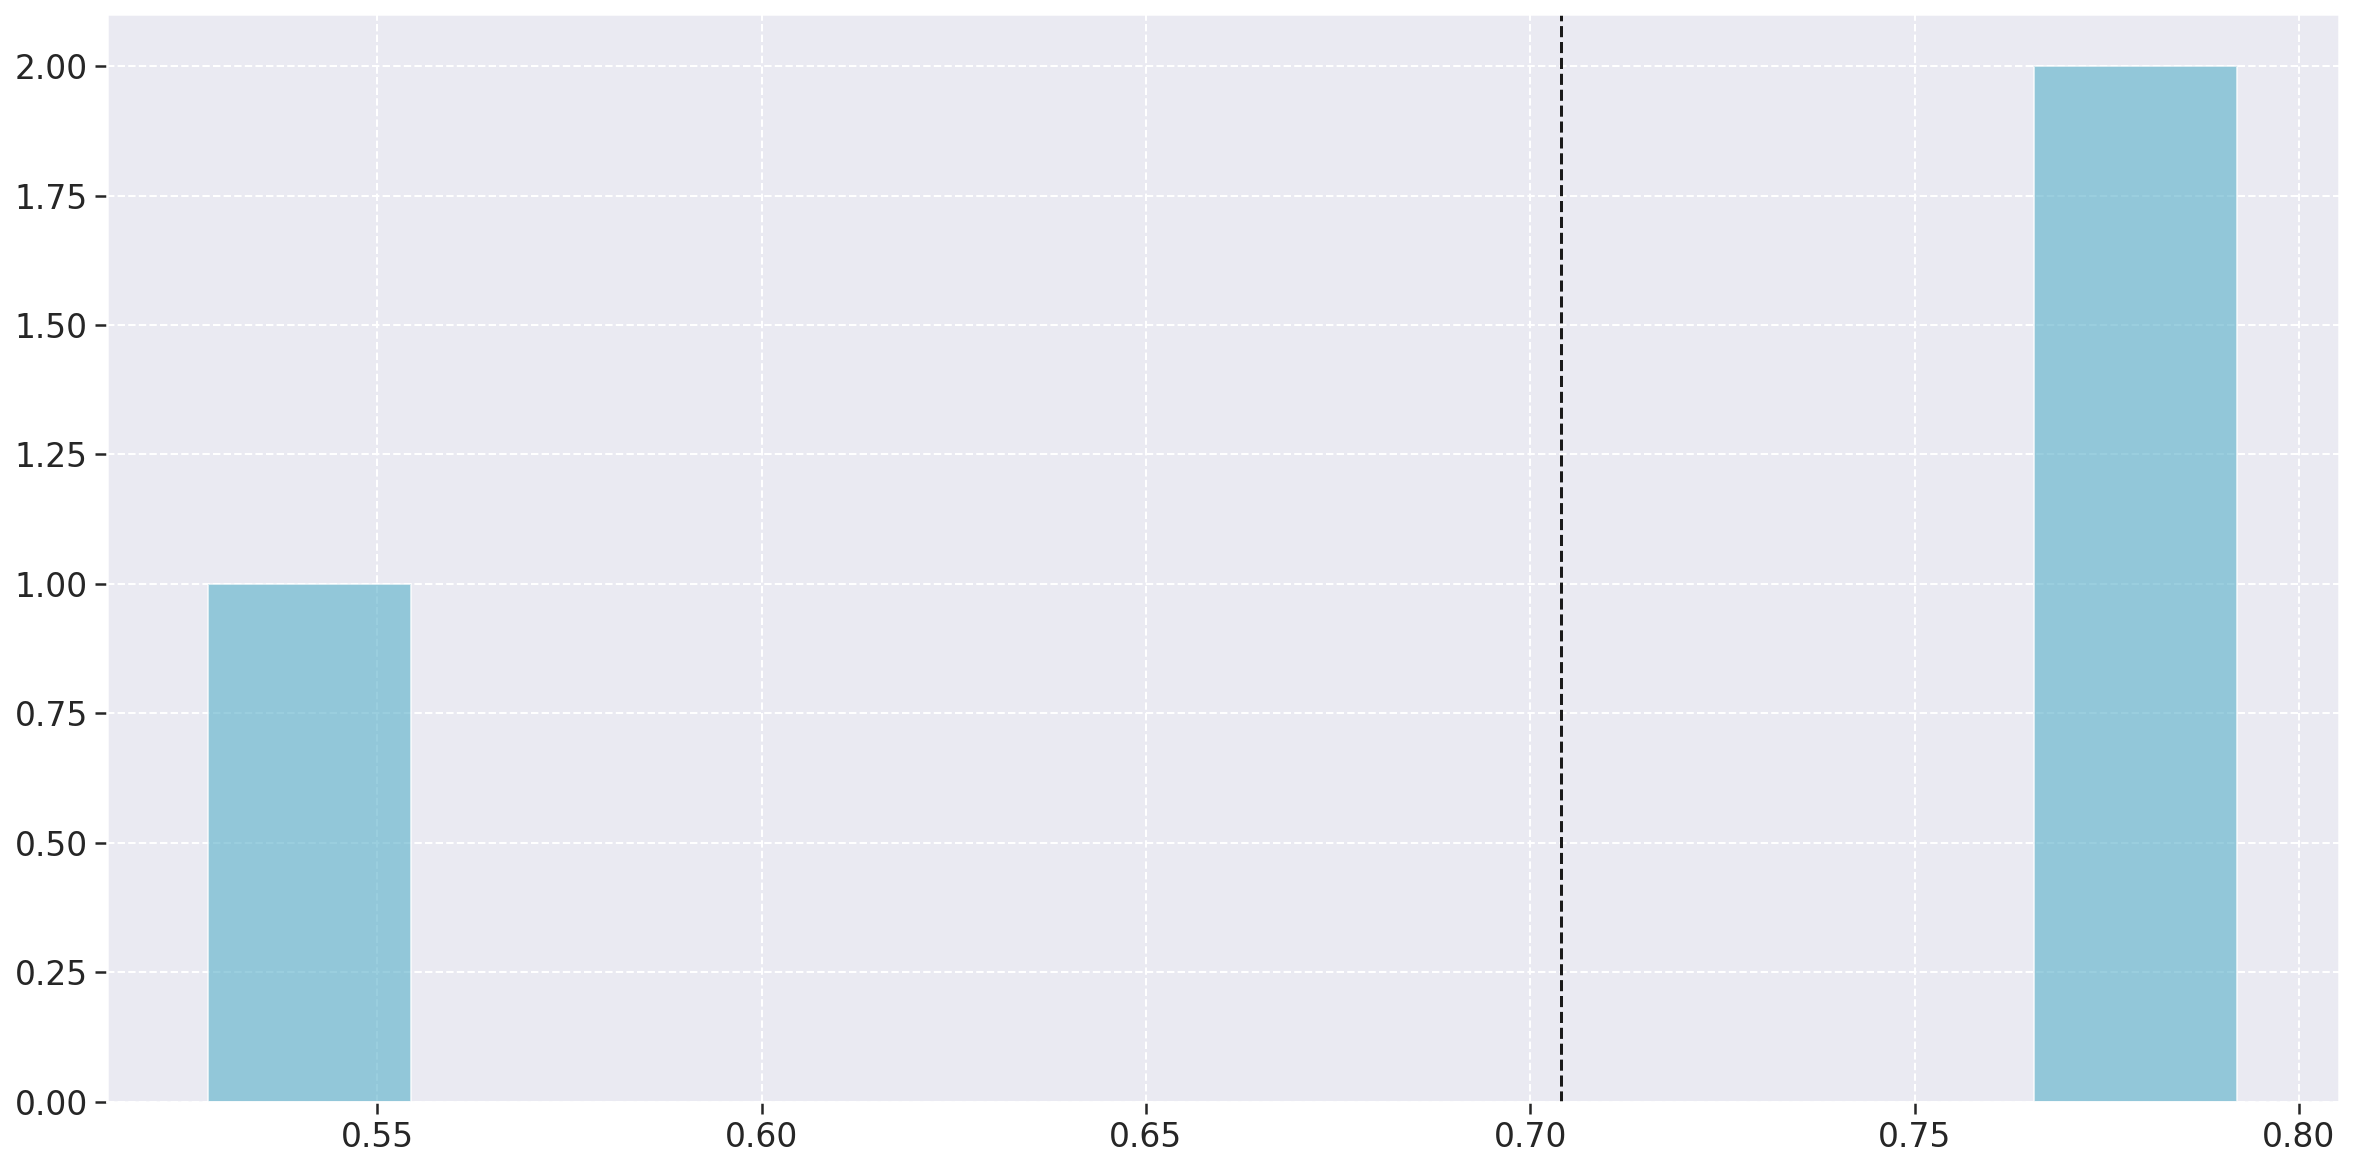

In [48]:
fig = plt.figure(figsize=(20, 10))

plt.hist(profile_metrics['code_quality'], bins=10, color='c', alpha=0.65)
plt.axvline(profile_metrics['code_quality'].mean(), color='k', linestyle='dashed')

### Testing Status

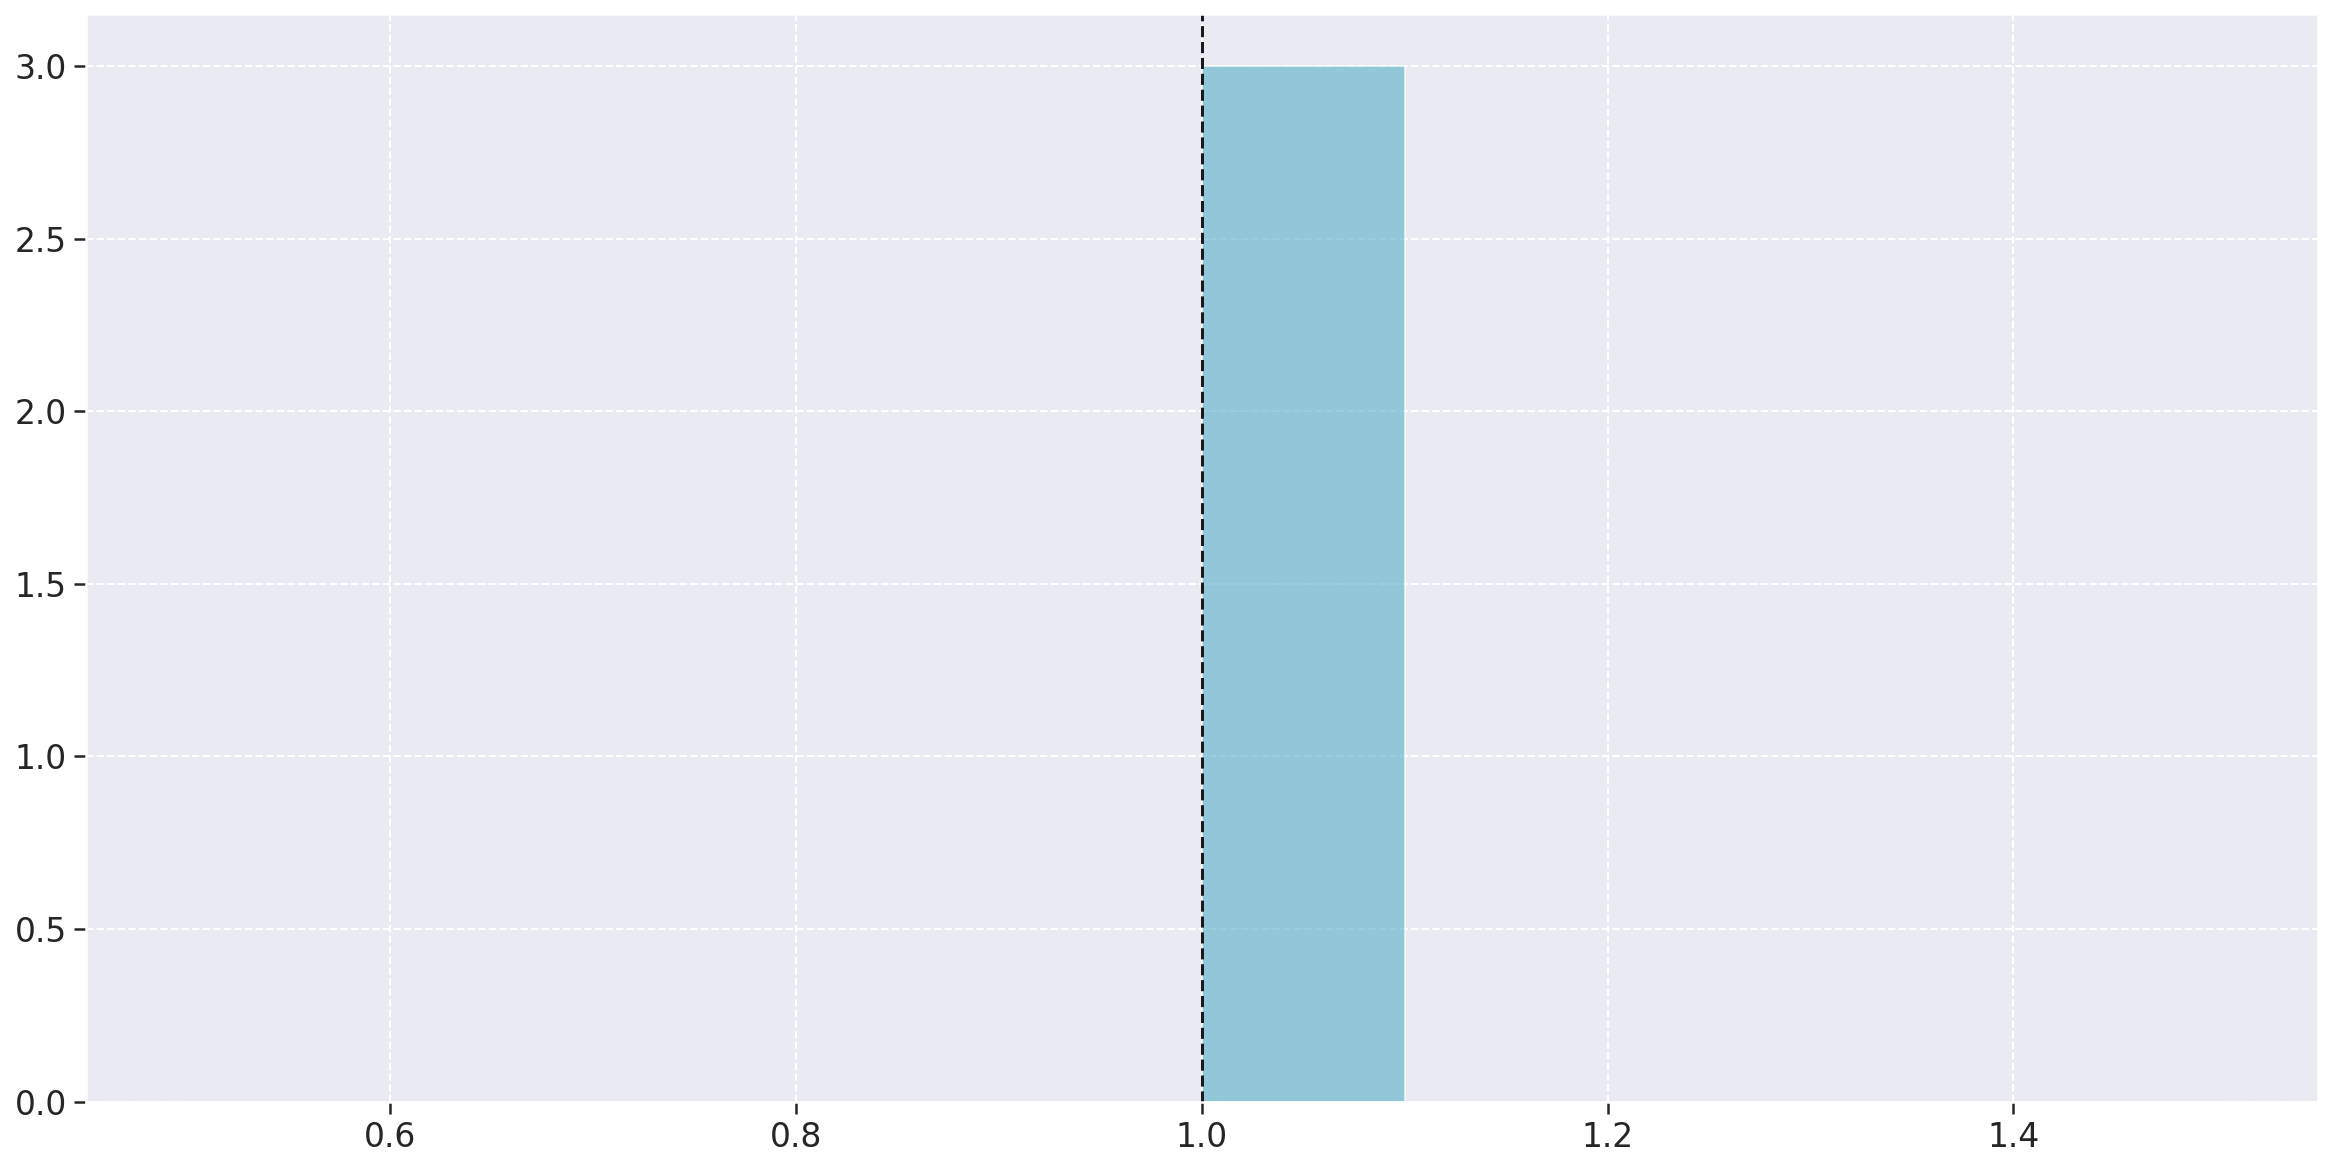

In [49]:
fig = plt.figure(figsize=(20, 10))

plt.hist(profile_metrics['testing_status'], bins=10, color='c', alpha=0.65)
plt.axvline(profile_metrics['testing_status'].mean(), color='k', linestyle='dashed')

## Boxplot

### Code Quality

{'whiskers': [<matplotlib.lines.Line2D at 0x7fa022cc6860>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa022954710>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa022cc6cf8>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa022954dd8>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa022ba4d68>],
 'means': []}

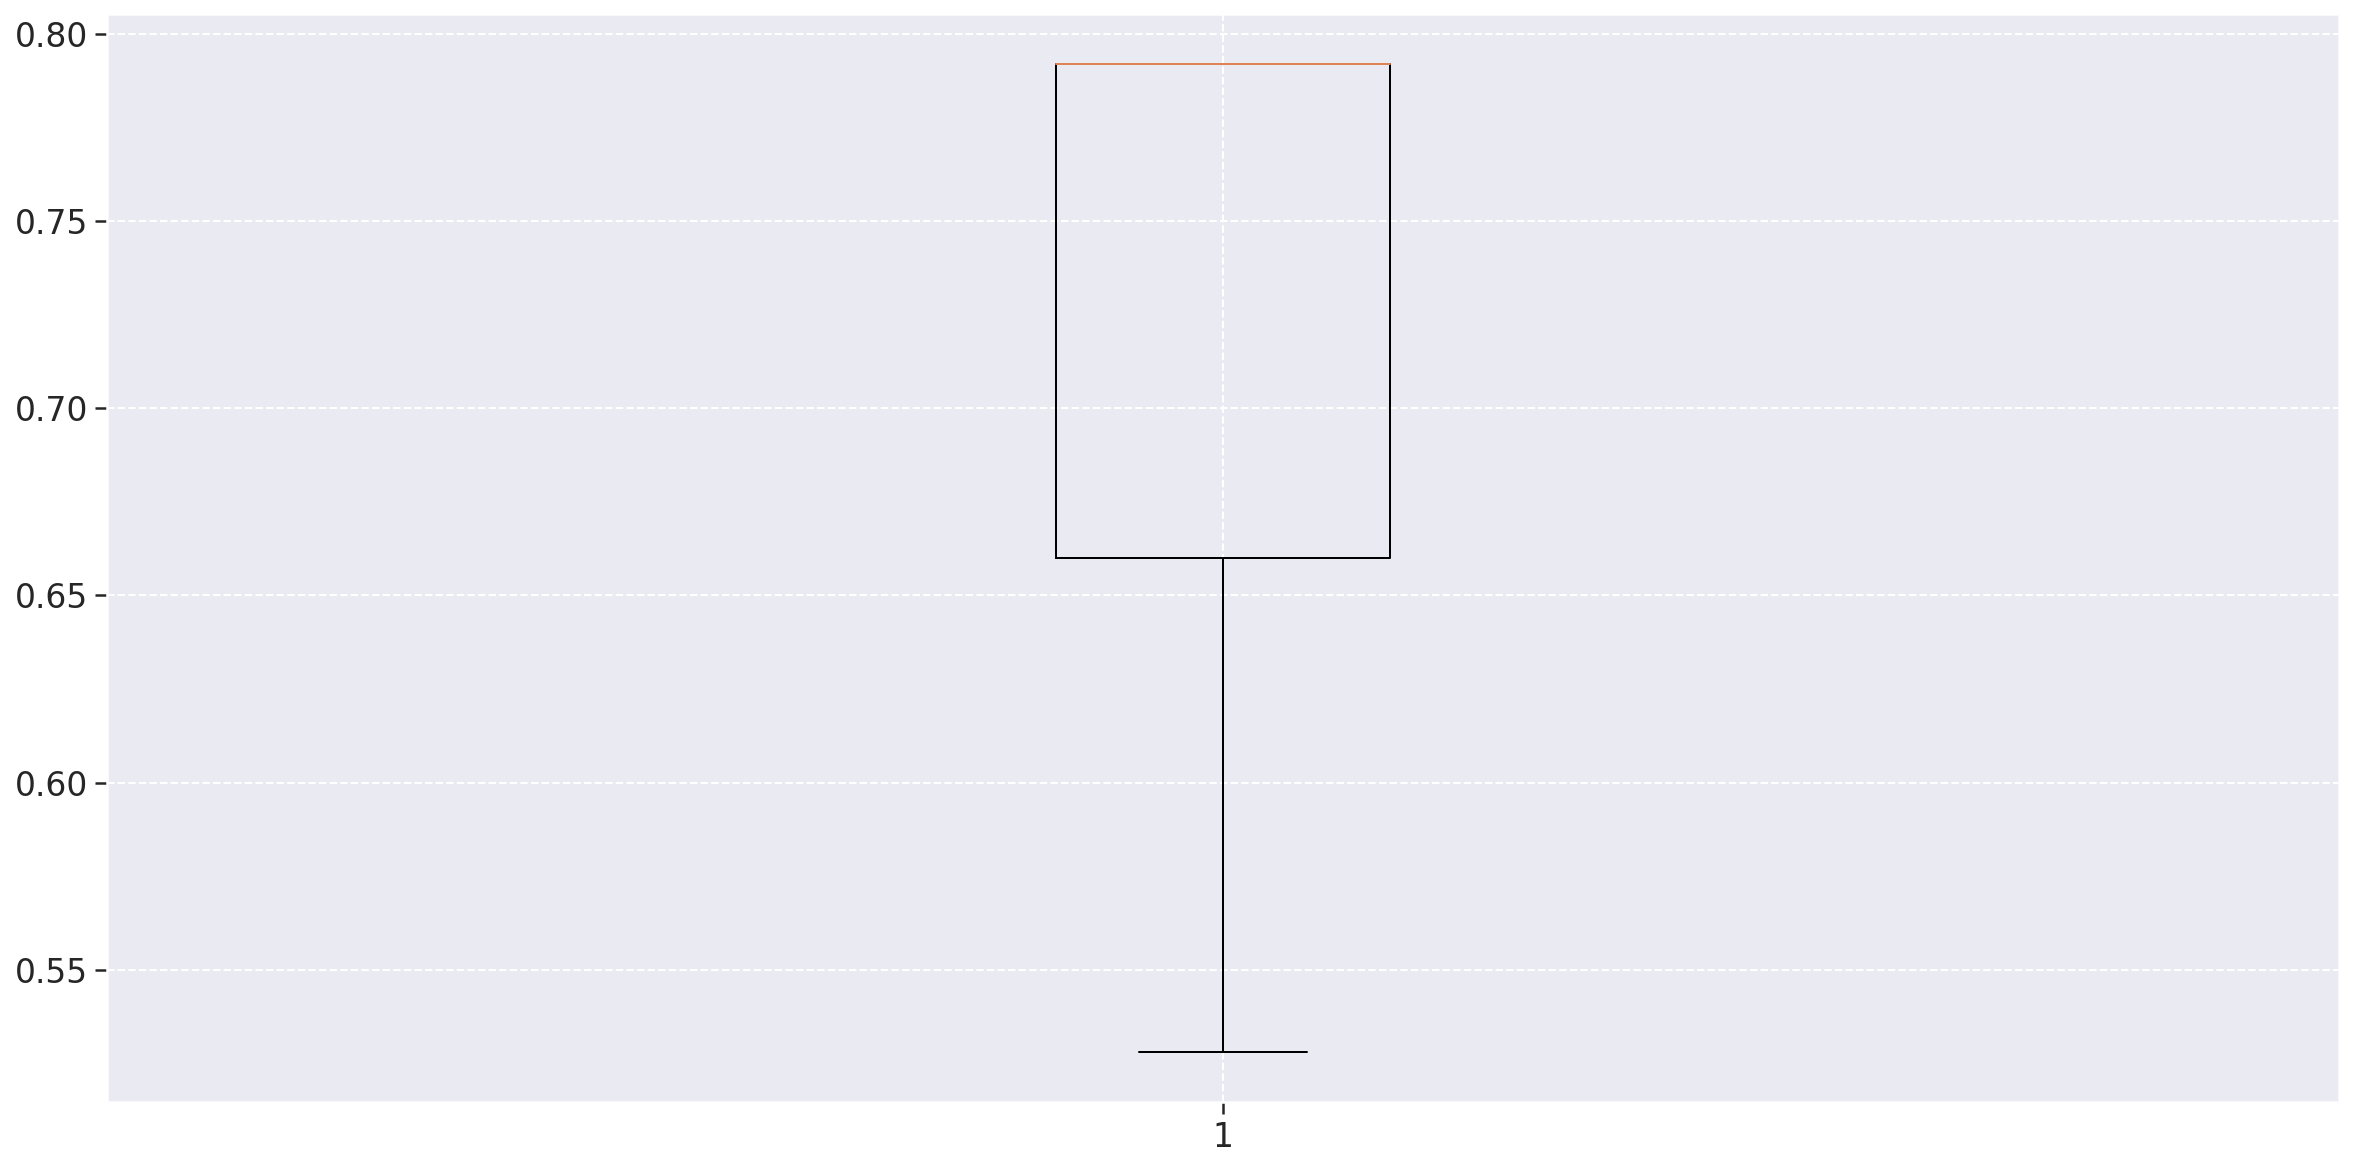

In [50]:
fig = plt.figure(figsize=(20, 10))

plt.boxplot(profile_metrics['code_quality'])

### Testing Status

{'whiskers': [<matplotlib.lines.Line2D at 0x7fa022aba2b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa022abaef0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa022aba1d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa0227df978>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa0227dfc50>],
 'means': []}

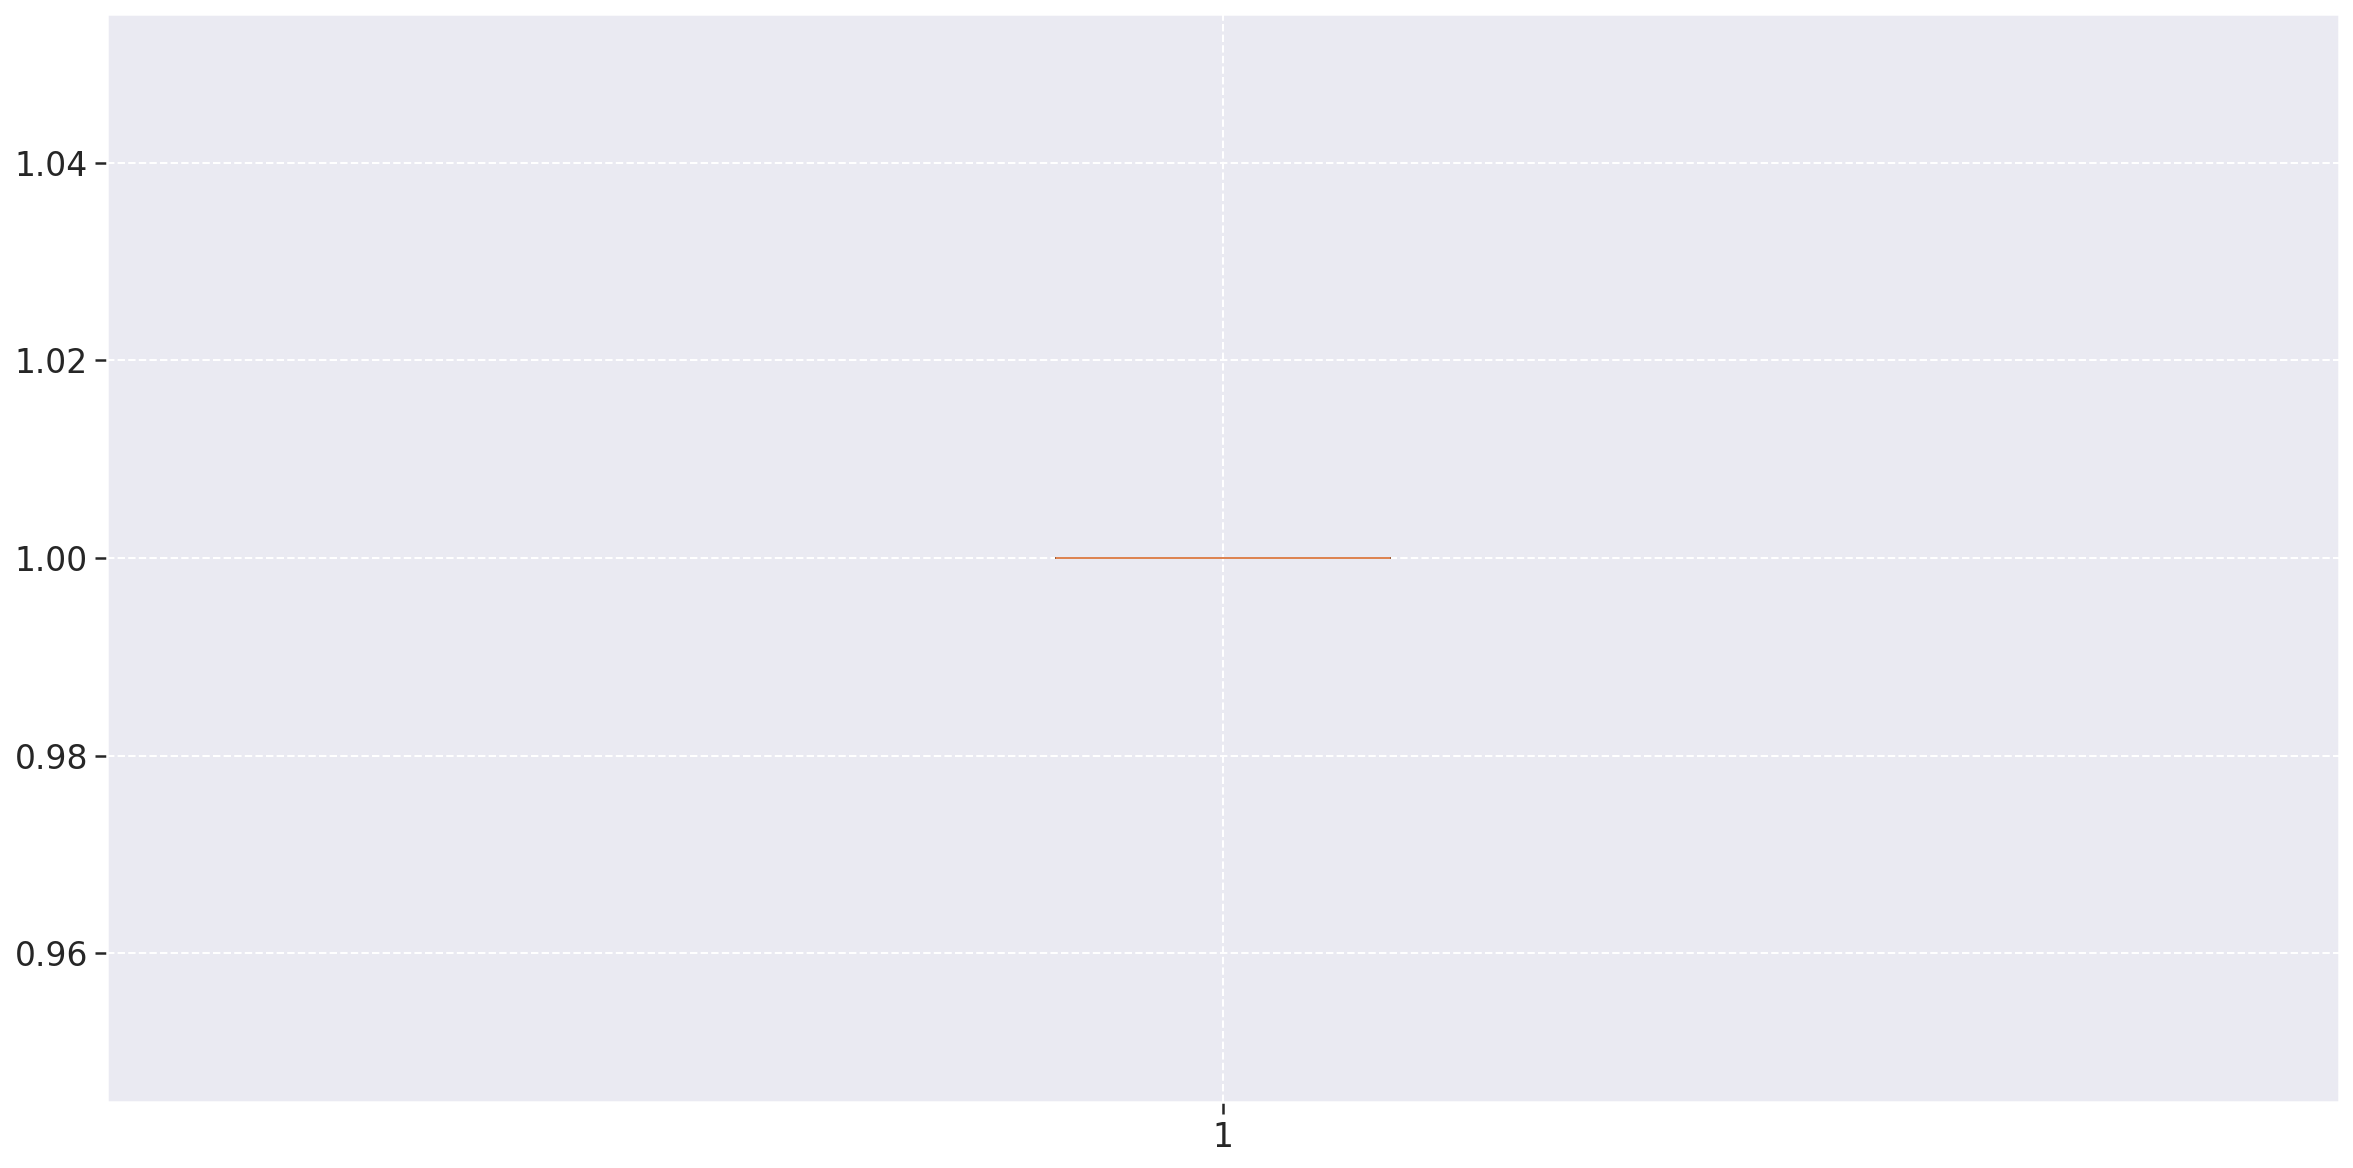

In [51]:
fig = plt.figure(figsize=(20, 10))

plt.boxplot(profile_metrics['testing_status'])

## Analysis

### Code Quality

We can see at the **histogram** and **boxplot** that only one release has had a different value, and it was lower, at .55

### Testing Status

The testing status metric hasn't changed at all at the **histogram** and **boxplot** graphs.

# Frontend

In [52]:
descriptive_statistics_frontend = pd.DataFrame()

descriptive_statistics_frontend['mode_reliability'] = frontend_metrics['testing_status'].mode()
descriptive_statistics_frontend['mode_maintainability'] = frontend_metrics['code_quality'].mode()
descriptive_statistics_frontend['median_reliability'] = frontend_metrics['testing_status'].median()
descriptive_statistics_frontend['median_maintainability'] = frontend_metrics['code_quality'].median()
descriptive_statistics_frontend['mean_reliability'] = frontend_metrics['testing_status'].mean()
descriptive_statistics_frontend['mean_maintainability'] = frontend_metrics['code_quality'].mean()
descriptive_statistics_frontend['max_reliability'] = frontend_metrics['testing_status'].max()
descriptive_statistics_frontend['max_maintainability'] = frontend_metrics['code_quality'].max()
descriptive_statistics_frontend['min_reliability'] = frontend_metrics['testing_status'].min()
descriptive_statistics_frontend['min_maintainability'] = frontend_metrics['code_quality'].min()
descriptive_statistics_frontend['std_dev_reliability'] = frontend_metrics['testing_status'].std()
descriptive_statistics_frontend['std_dev_maintainability'] = frontend_metrics['code_quality'].std()
descriptive_statistics_frontend['variance_reliability'] = frontend_metrics['testing_status'].var()
descriptive_statistics_frontend['variance_maintainability'] = frontend_metrics['code_quality'].var()

descriptive_statistics_frontend

,mode_reliability,mode_maintainability,median_reliability,median_maintainability,mean_reliability,mean_maintainability,max_reliability,max_maintainability,min_reliability,min_maintainability,std_dev_reliability,std_dev_maintainability,variance_reliability,variance_maintainability
0,1.0,0.626327,0.986275,0.645,0.982969,0.642236,1.0,0.66,0.957143,0.626327,0.018649,0.015467,0.000348,0.000239


In [53]:
frontend_metrics

,m1,m2,m3,m4,m6,repository,version,ncloc,code_quality,testing_status
0,0.909091,0.045455,1.000000,1.0,1.000000,Frontend,03-10-2021-15-49,1401,0.645000,1.000000
1,0.959184,0.020408,0.918367,1.0,0.938776,Frontend,03-11-2021-02-08,4888,0.626327,0.957143
2,0.960784,0.019608,1.000000,1.0,0.980392,Frontend,08-11-2021-23-30,5638,0.653529,0.986275
3,0.500000,0.500000,1.000000,1.0,1.000000,Frontend,13-09-2021-20-00,35,0.660000,1.000000
4,0.959184,0.020408,0.918367,1.0,0.959184,Frontend,17-10-2021-15-30,4858,0.626327,0.971429


## Heatmap (Correlation Matrix)

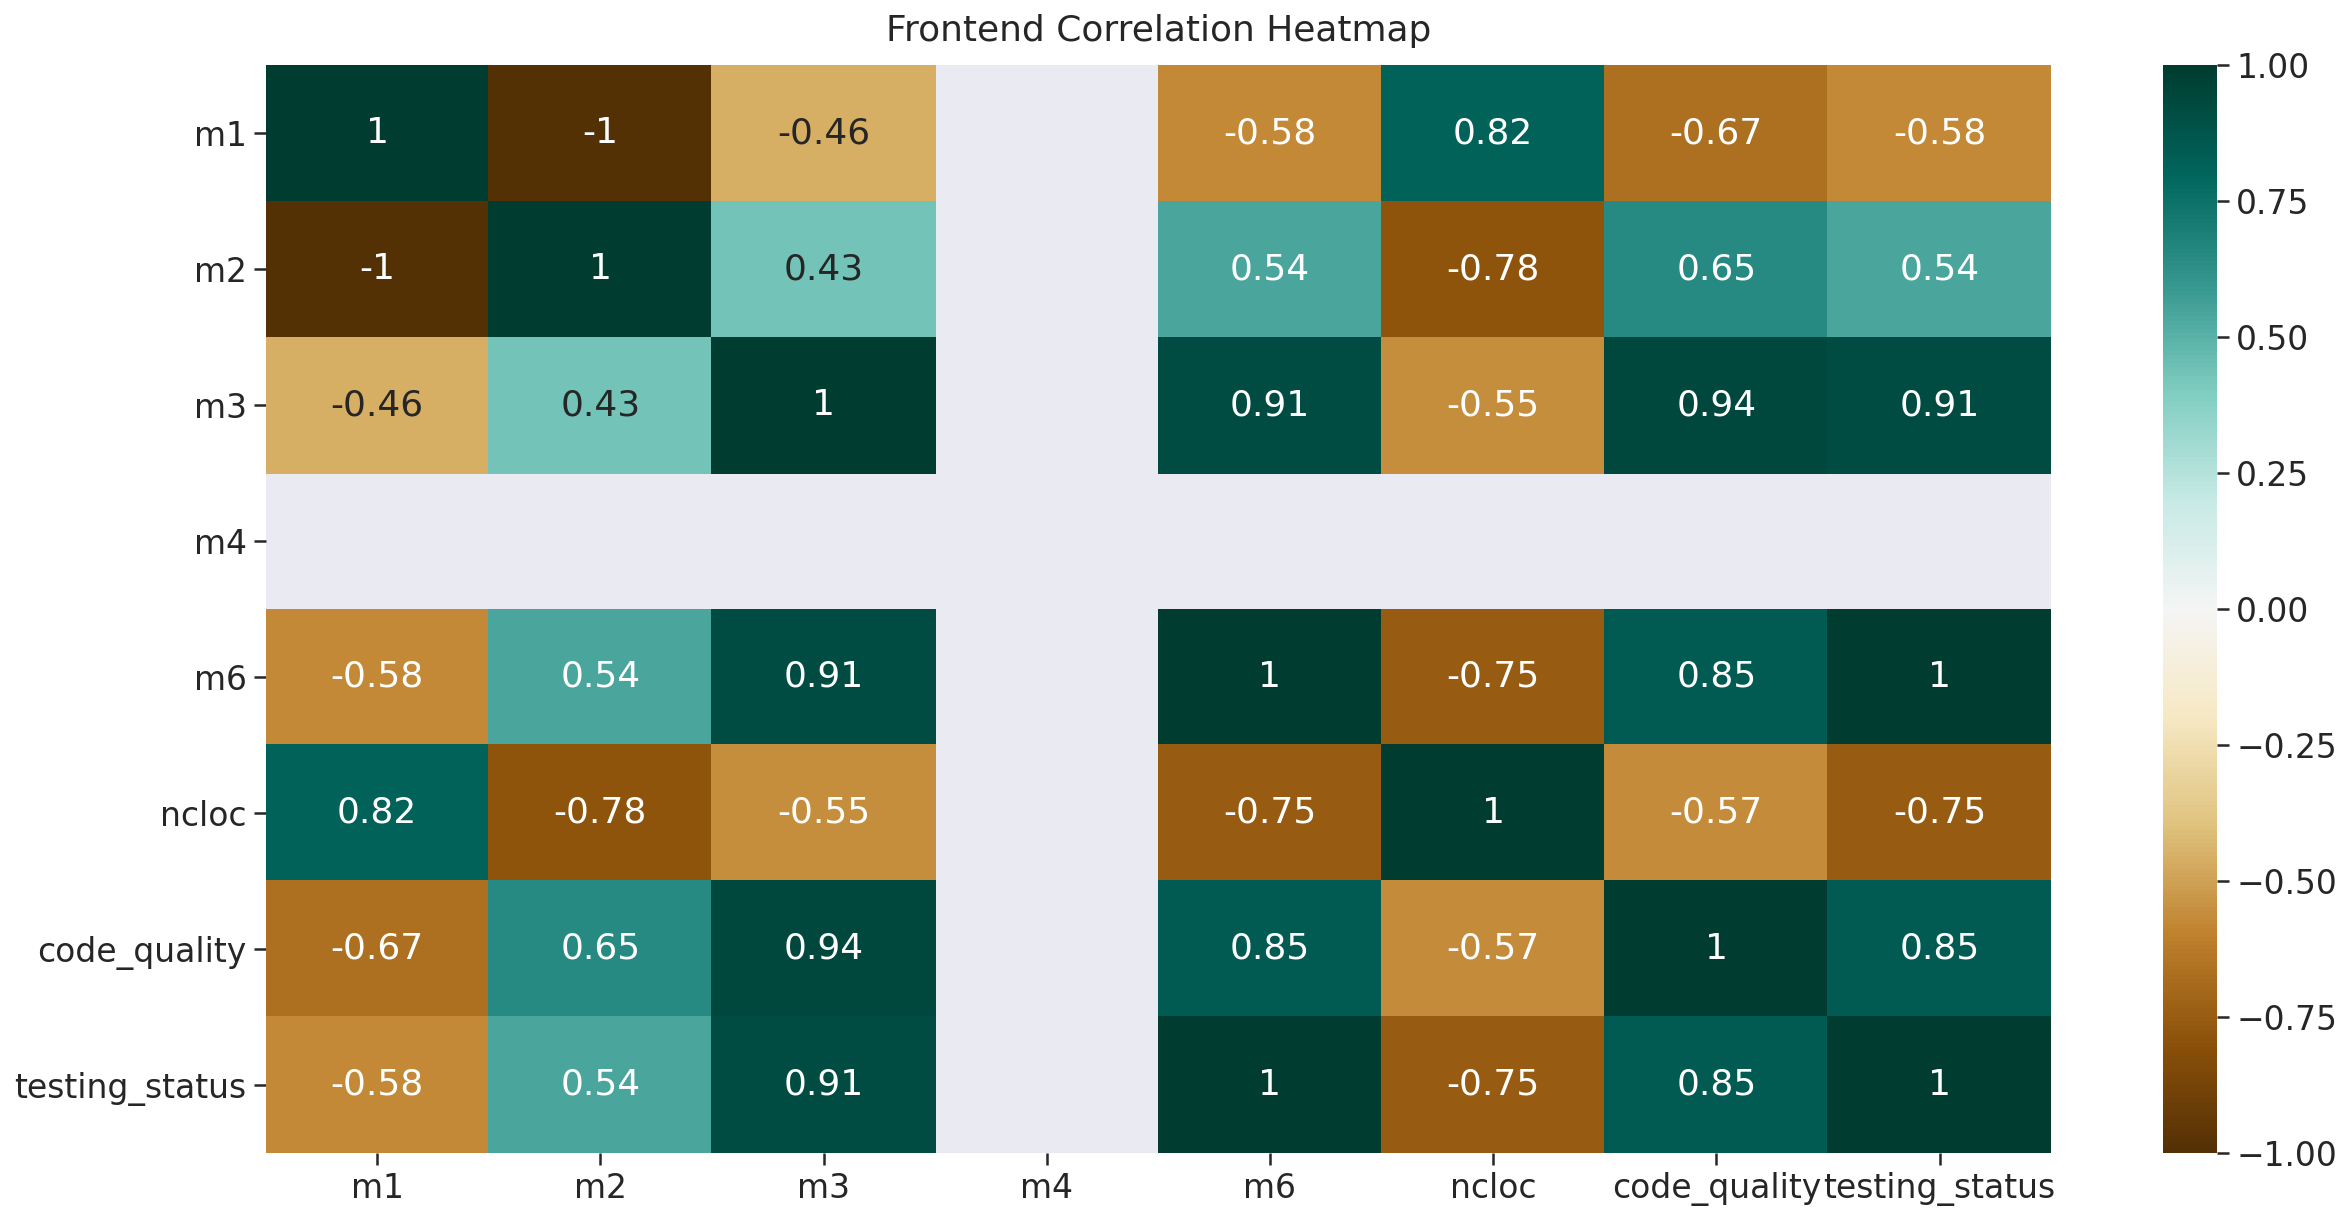

In [54]:
plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(frontend_metrics.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Frontend Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

### Areas in grey have the standard deviation equals to 0.0, so it's impossible to calculate the correlation at that specific cell

## Histograms

### Code Quality

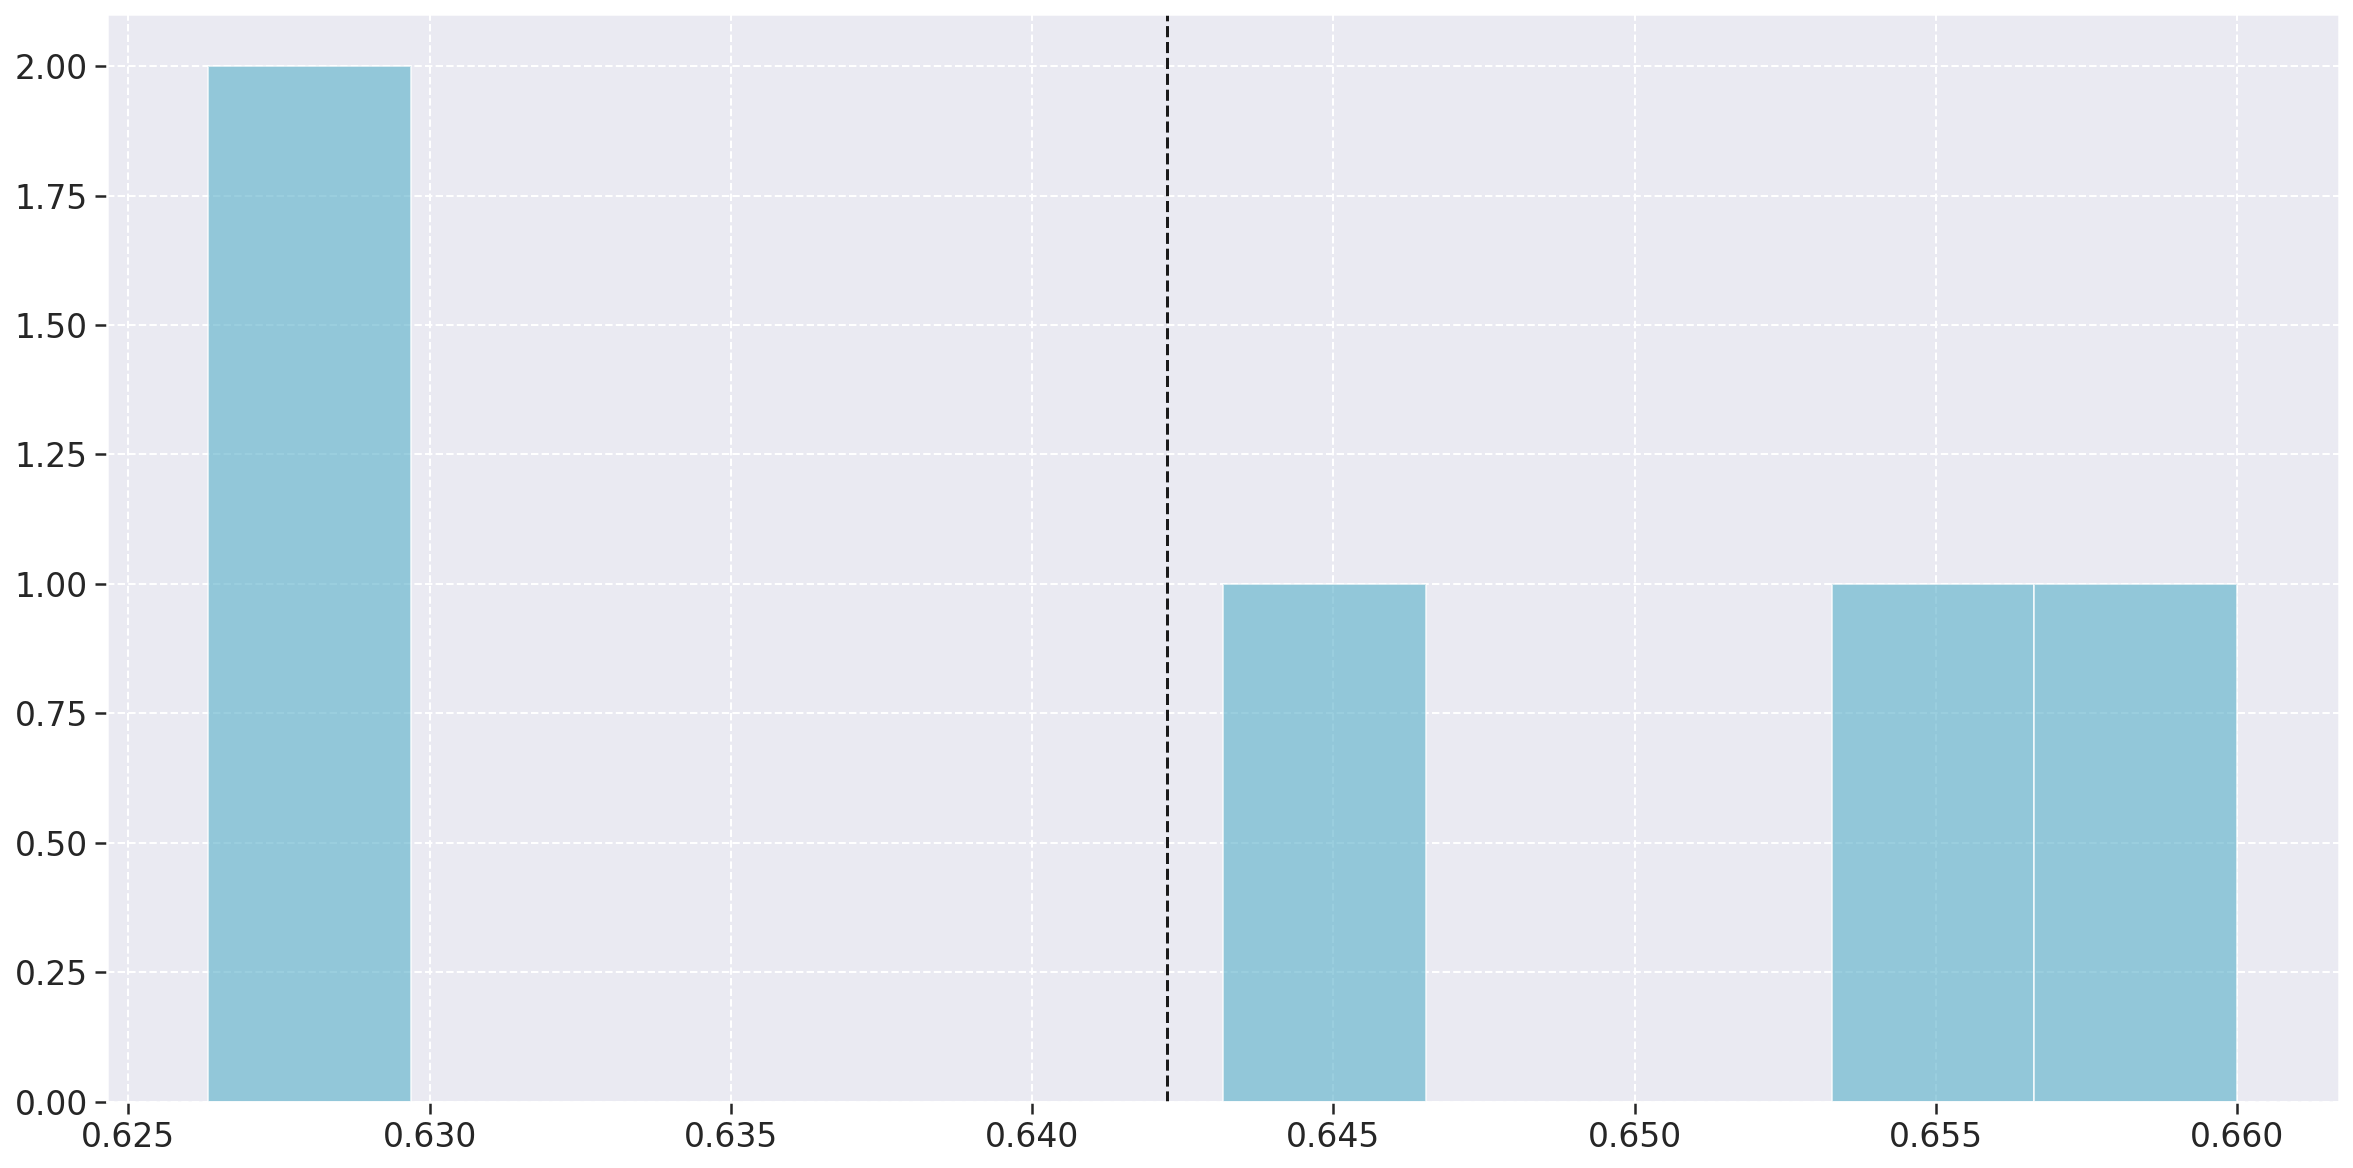

In [55]:
fig = plt.figure(figsize=(20, 10))

plt.hist(frontend_metrics['code_quality'], bins=10, color='c', alpha=0.65)
plt.axvline(frontend_metrics['code_quality'].mean(), color='k', linestyle='dashed')

### Testing Status

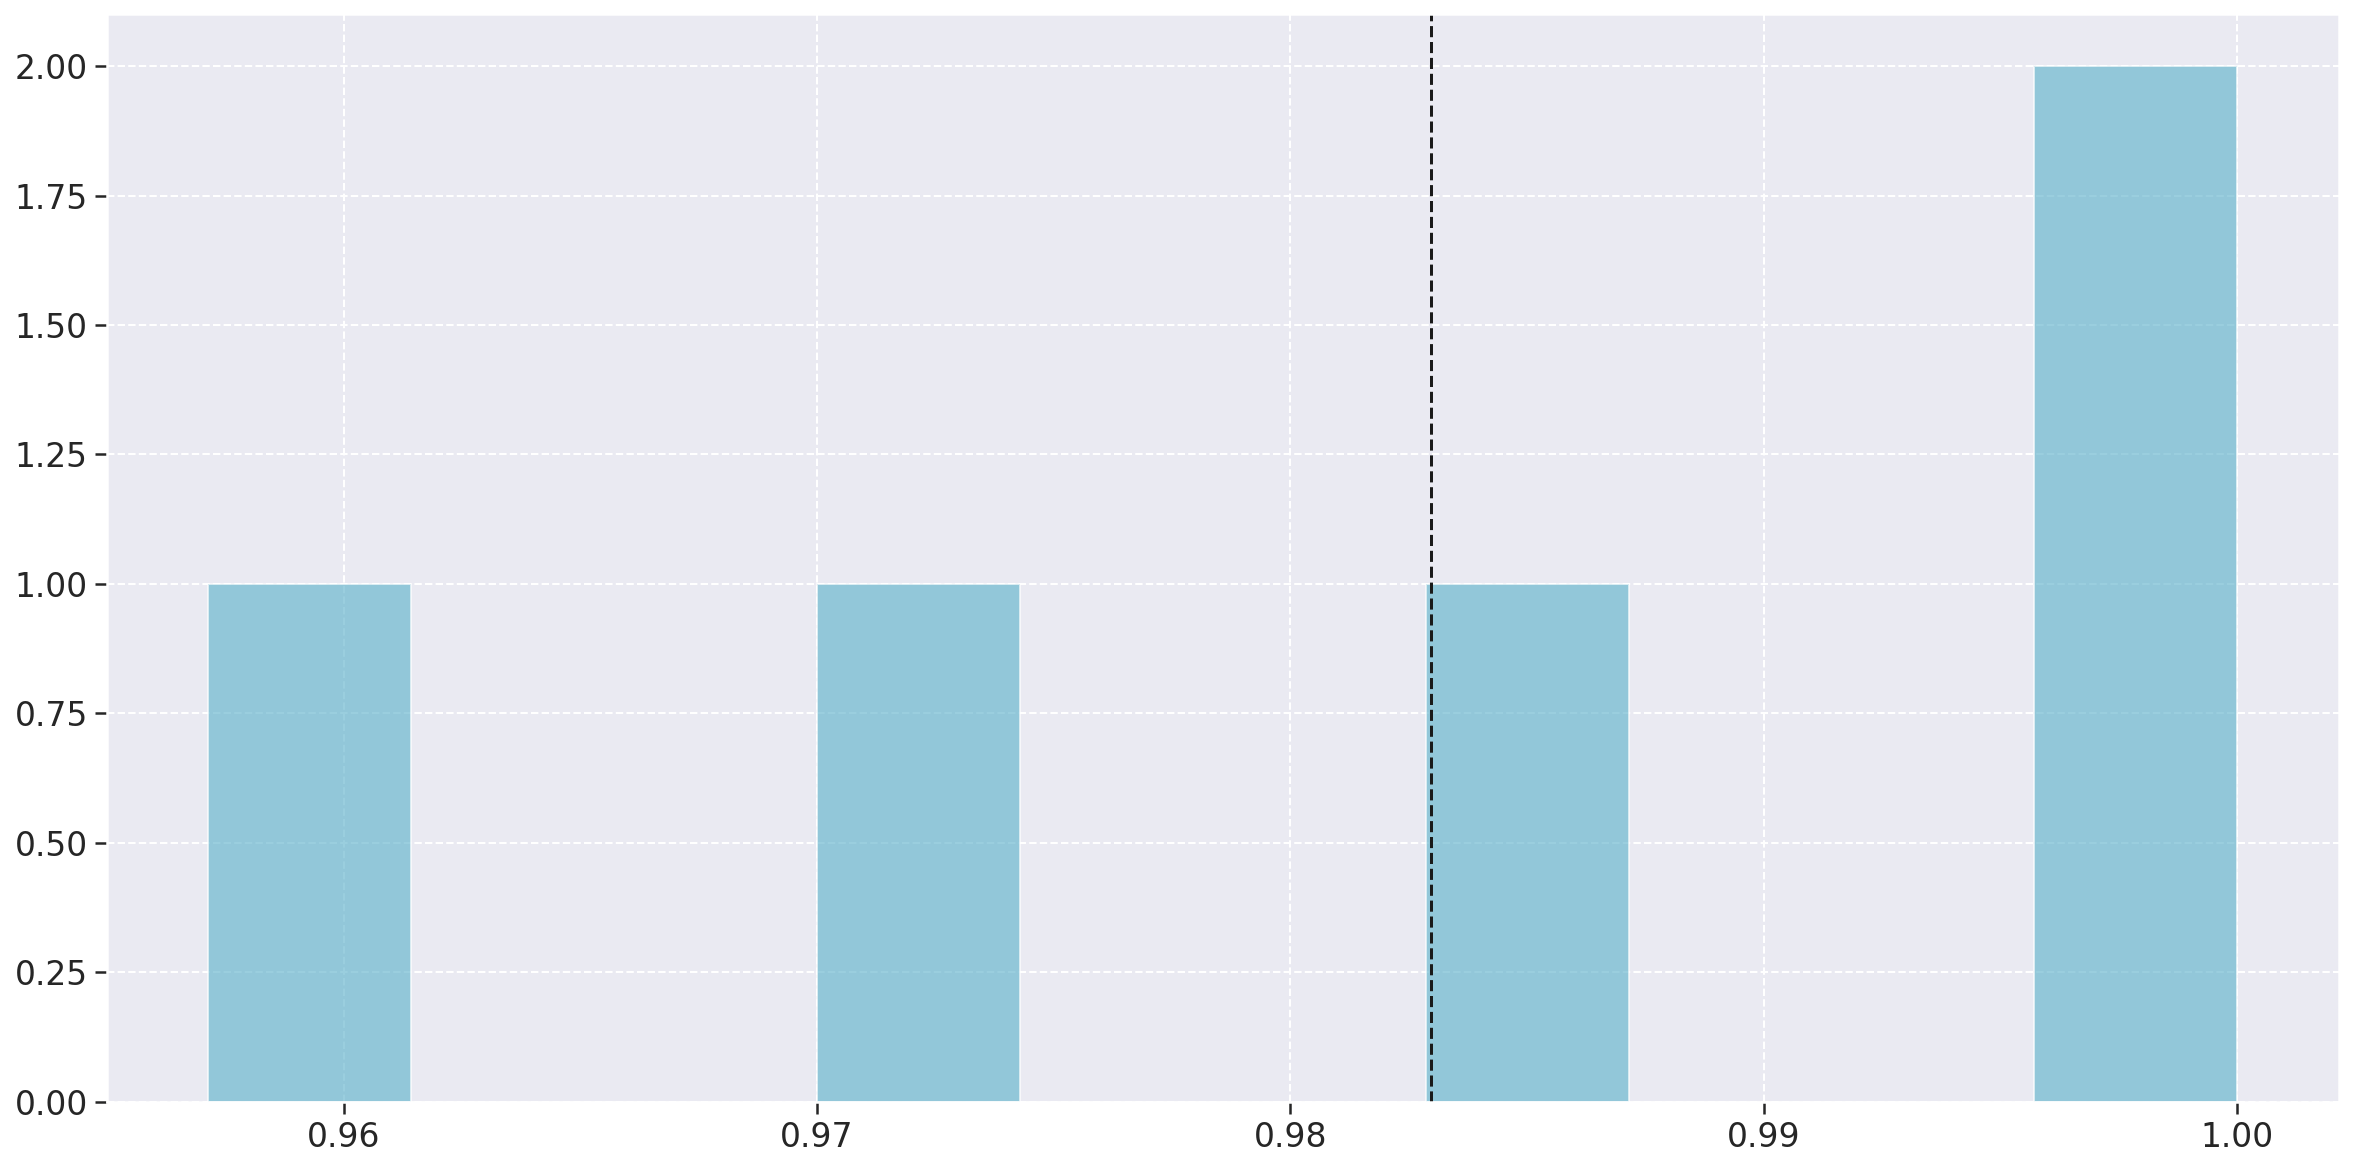

In [56]:
fig = plt.figure(figsize=(20, 10))

plt.hist(frontend_metrics['testing_status'], bins=10, color='c', alpha=0.65)
plt.axvline(frontend_metrics['testing_status'].mean(), color='k', linestyle='dashed')

## Boxplot

### Code Quality

{'whiskers': [<matplotlib.lines.Line2D at 0x7fa02091bf60>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa020928518>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa02091beb8>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa020928ac8>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa020928da0>],
 'means': []}

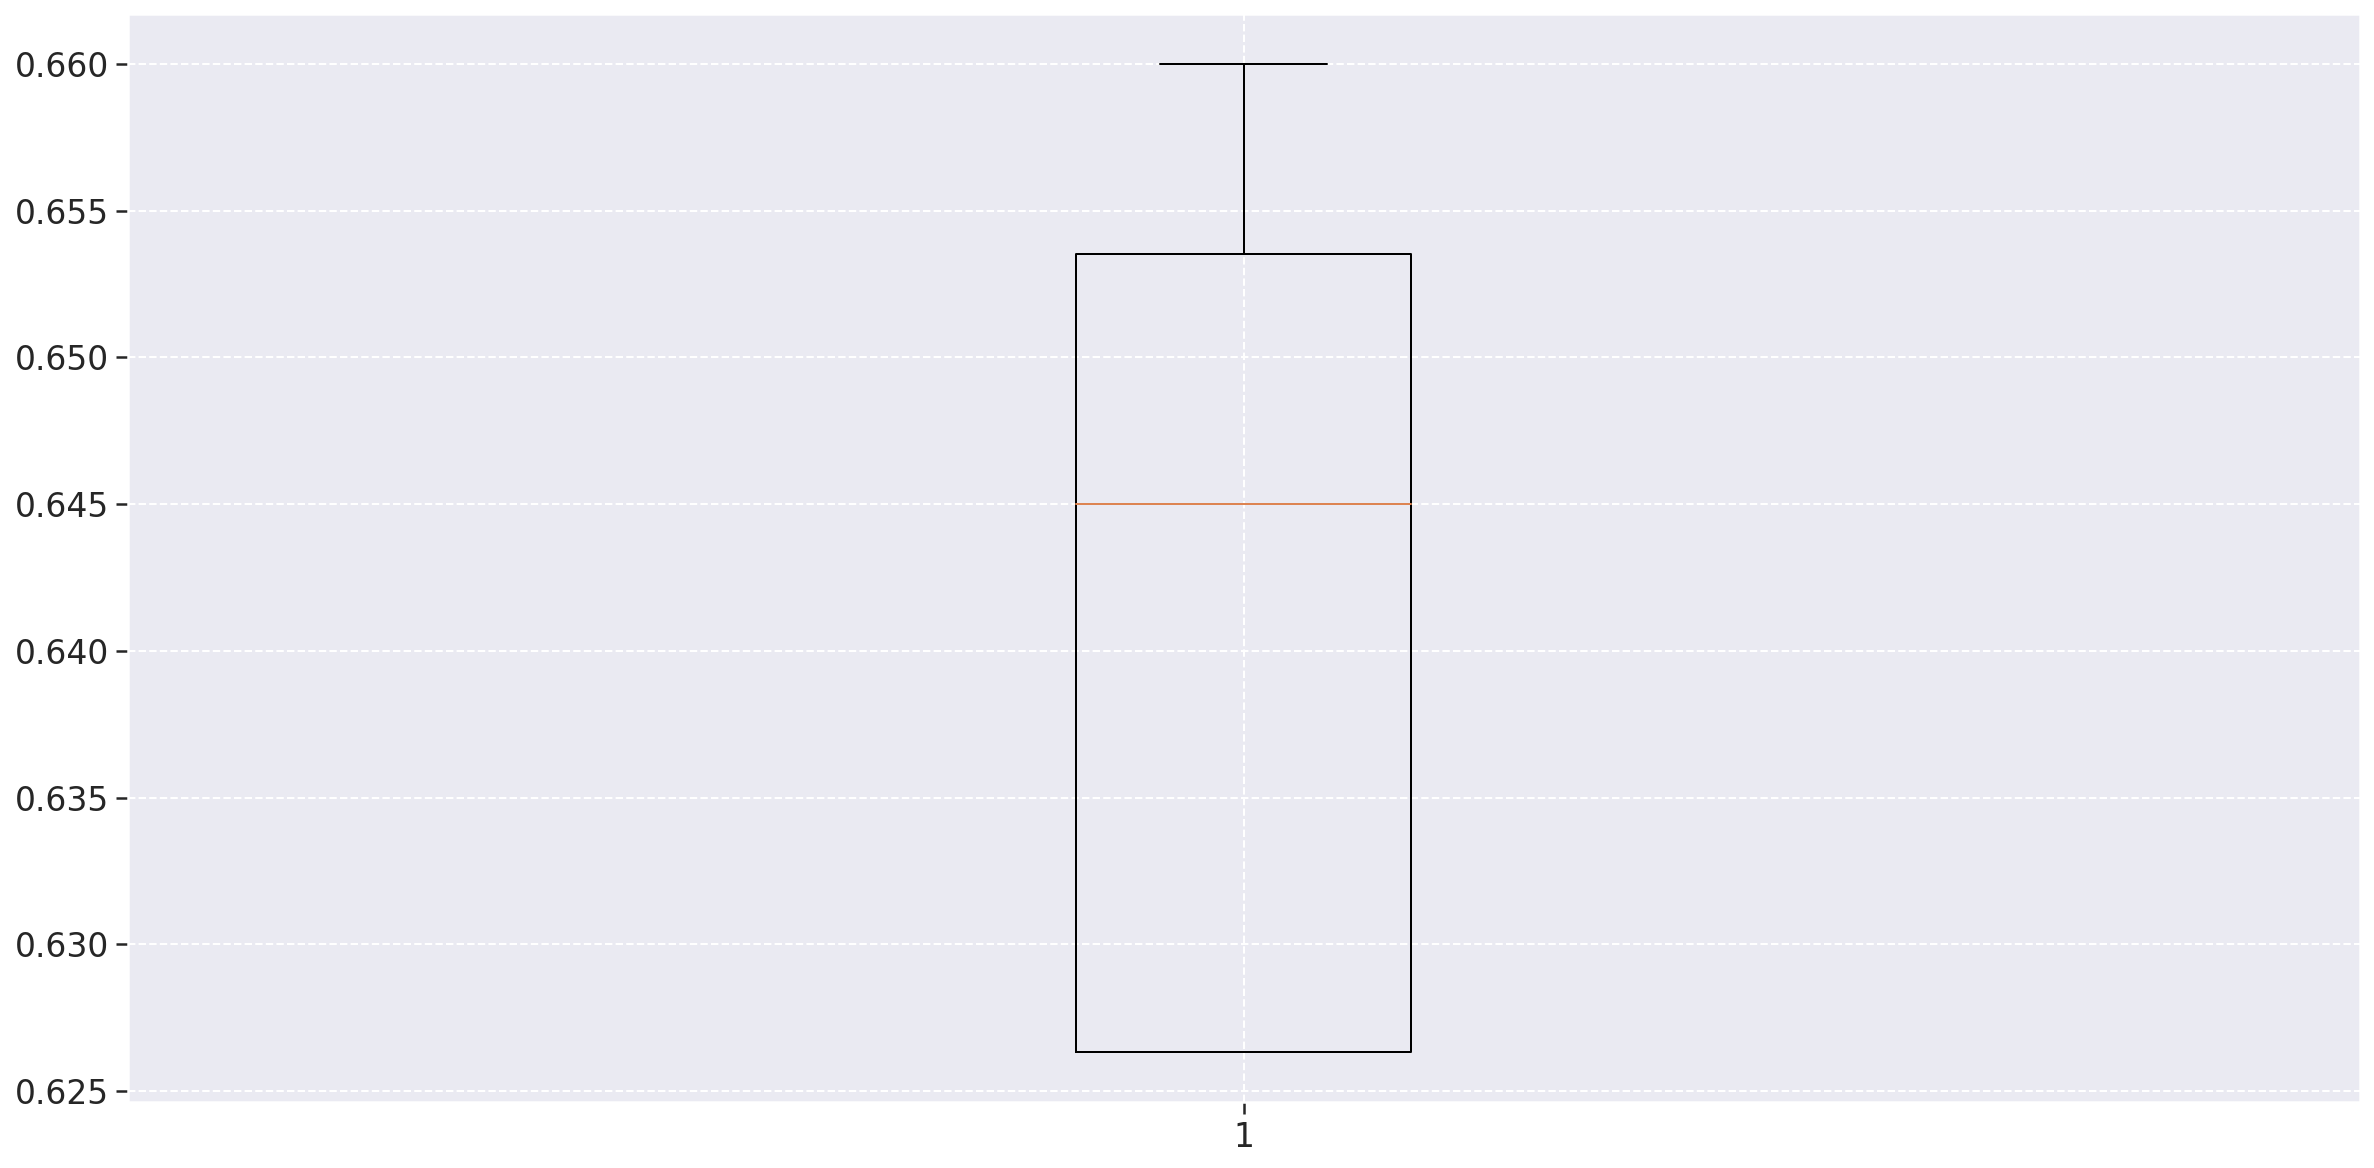

In [57]:
fig = plt.figure(figsize=(20, 10))

plt.boxplot(frontend_metrics['code_quality'])

### Testing Status

{'whiskers': [<matplotlib.lines.Line2D at 0x7fa0208e2048>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa02089c320>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa02088dcf8>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa02089c860>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa02089cb38>],
 'means': []}

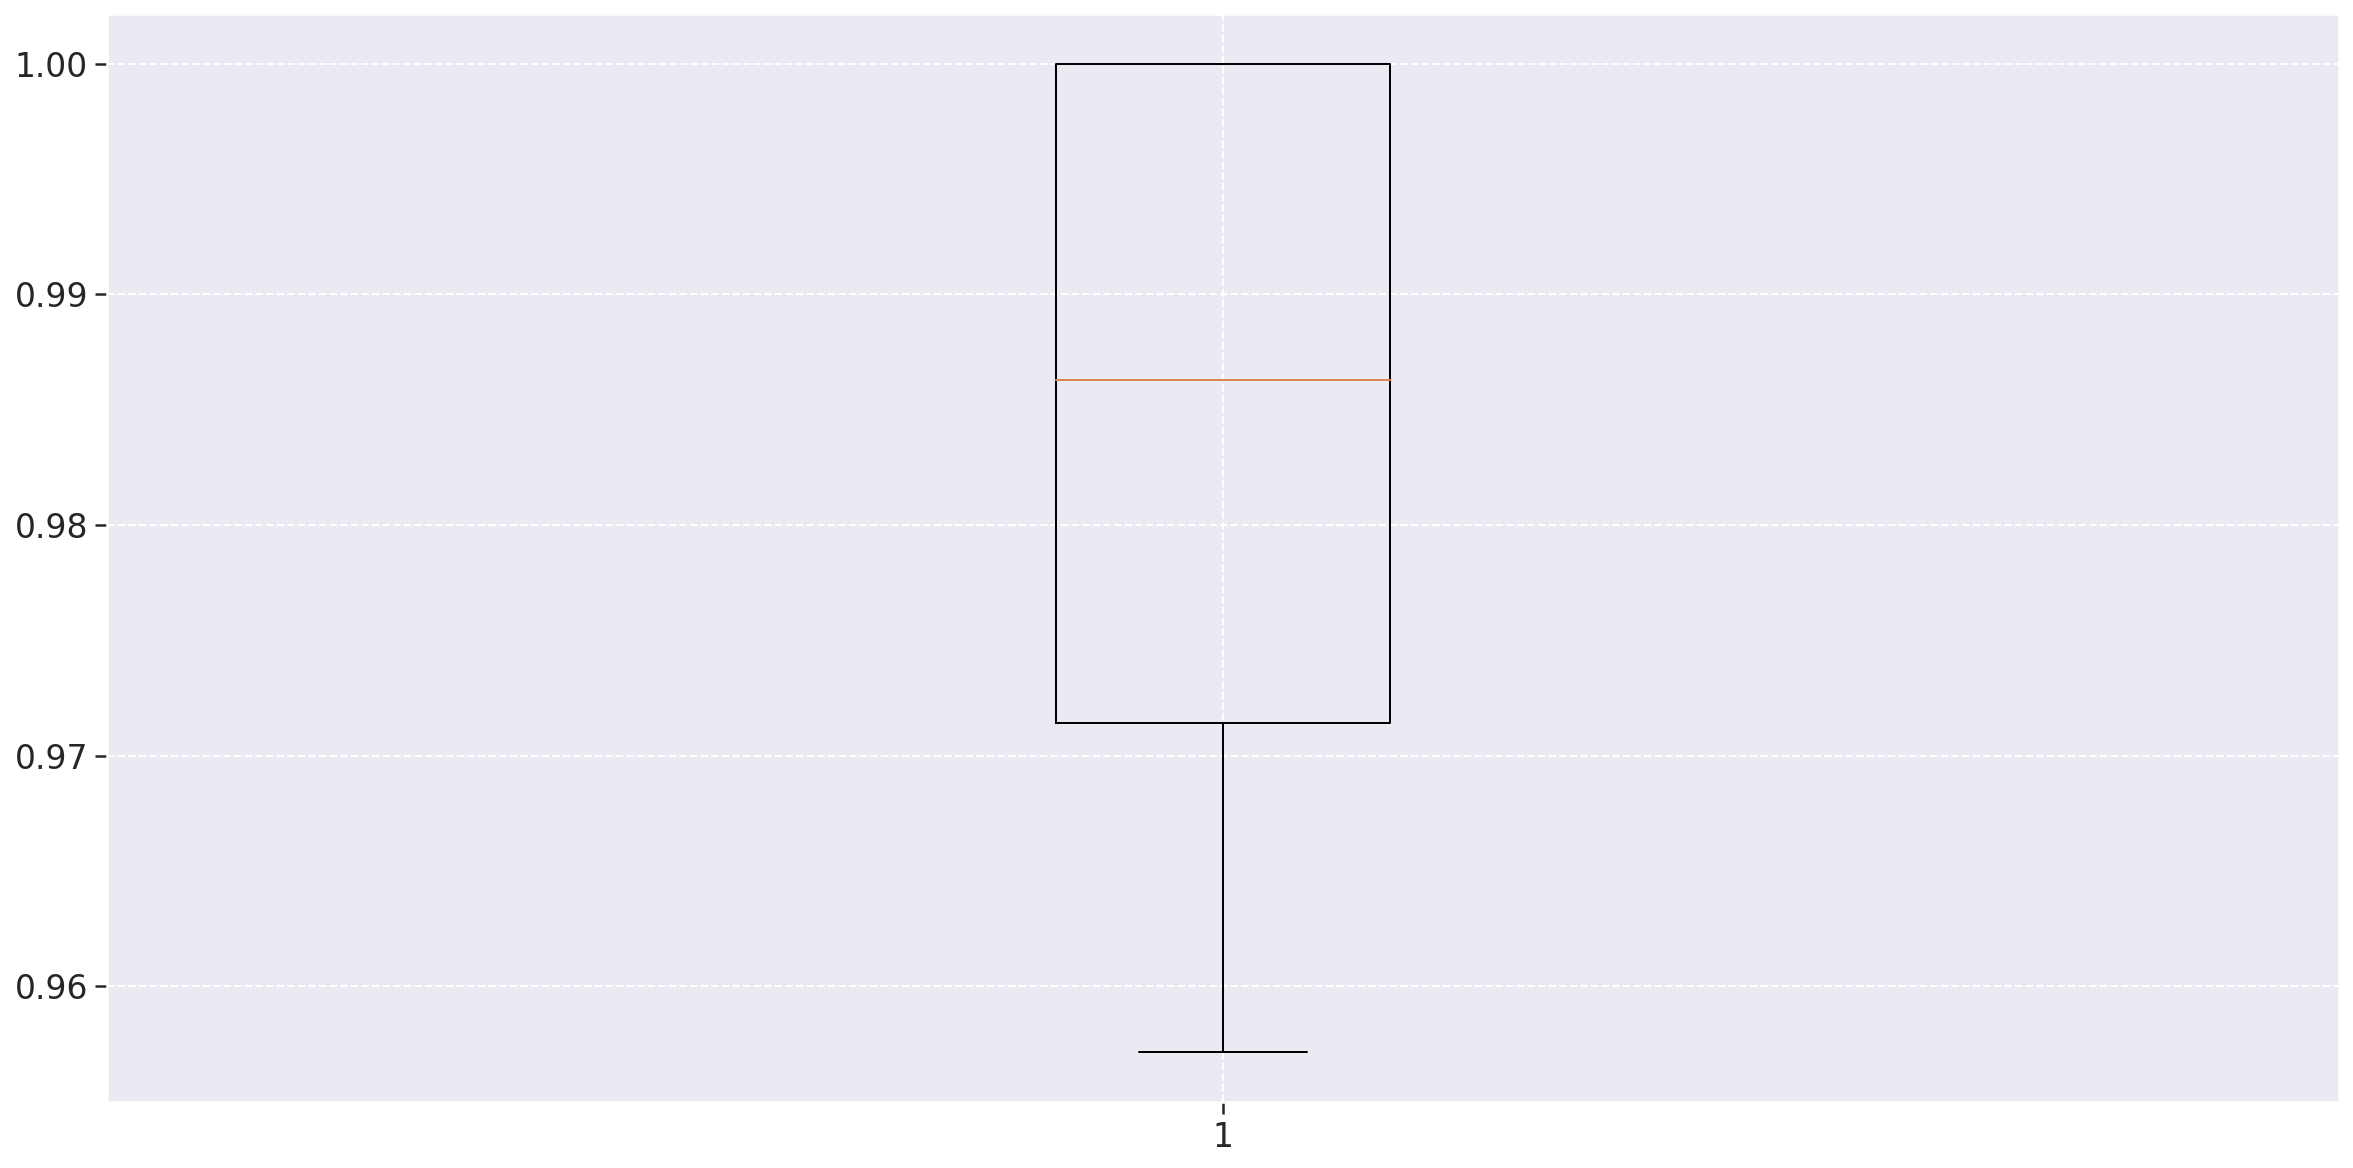

In [58]:
fig = plt.figure(figsize=(20, 10))

plt.boxplot(frontend_metrics['testing_status'])

## Analysis

### Code Quality

It's possible to see that the code quality metric didn't fluctuate much, as wee see at the **boxplot** y-axis and the **histogram** x-axis, being "compressed" between .625 and .660, and the 2 releases with the lowest value for the metric were the ones before the last one, meaning that the development went a little down but got better after.

### Testing Status

This metric hasn't changed much too, always close to 1, having the minimun value at almost .96, wich is really close to an optimun value.
The median and mean were also really close, one in the upper values between .98 and .99 and the other at the lower values of the same interval, so we can assume that the values were pretty high overall.

# Total Quality Aspect

In [59]:
metrics_statistics_values = pd.concat([descriptive_statistics_archives, descriptive_statistics_profile, descriptive_statistics_frontend])
metrics_statistics_values.insert(0, 'repository', ['ARCHIVES', 'PROFILE', 'FRONTEND'])
metrics_statistics_values

,repository,mode_reliability,mode_maintainability,median_reliability,median_maintainability,mean_reliability,mean_maintainability,max_reliability,max_maintainability,min_reliability,min_maintainability,std_dev_reliability,std_dev_maintainability,variance_reliability,variance_maintainability
0,ARCHIVES,1.0,0.792000,1.000000,0.726,1.000000,0.714214,1.0,0.792,1.000000,0.612857,0.000000,0.091858,0.000000,0.008438
0,PROFILE,1.0,0.792000,1.000000,0.792,1.000000,0.704000,1.0,0.792,1.000000,0.528000,0.000000,0.152420,0.000000,0.023232
0,FRONTEND,1.0,0.626327,0.986275,0.645,0.982969,0.642236,1.0,0.660,0.957143,0.626327,0.018649,0.015467,0.000348,0.000239


In [60]:
metrics_df

,m1,m2,m3,m4,m6,Maintainability,Reliability,Total_QR,LOC,Repository,Version,Data
0,1.000000,0.400000,1.000000,1.0,1.000000,0.396000,0.500000,0.896000,200,Archives,03-10-2021-15-47,03-10-2021-15-47
1,0.428571,0.571429,1.000000,1.0,1.000000,0.330000,0.500000,0.830000,428,Archives,03-11-2021-02-10,03-11-2021-02-10
2,0.428571,0.428571,1.000000,1.0,1.000000,0.306429,0.500000,0.806429,593,Archives,08-11-2021-23-31,08-11-2021-23-31
3,1.000000,0.400000,1.000000,1.0,1.000000,0.396000,0.500000,0.896000,109,Archives,13-09-2021-15-00,13-09-2021-15-00
4,1.000000,0.400000,1.000000,1.0,1.000000,0.396000,0.500000,0.896000,112,Profile,03-10-2021-15-48,03-10-2021-15-48
5,0.200000,0.400000,1.000000,1.0,1.000000,0.264000,0.500000,0.764000,155,Profile,08-11-2021-23-31,08-11-2021-23-31
6,1.000000,0.400000,1.000000,1.0,1.000000,0.396000,0.500000,0.896000,112,Profile,13-09-2021-14-00,13-09-2021-14-00
7,0.909091,0.045455,1.000000,1.0,1.000000,0.322500,0.500000,0.822500,1401,Frontend,03-10-2021-15-49,03-10-2021-15-49
8,0.959184,0.020408,0.918367,1.0,0.938776,0.313163,0.478571,0.791735,4888,Frontend,03-11-2021-02-08,03-11-2021-02-08
9,0.960784,0.019608,1.000000,1.0,0.980392,0.326765,0.493137,0.819902,5638,Frontend,08-11-2021-23-30,08-11-2021-23-30


## Histogram

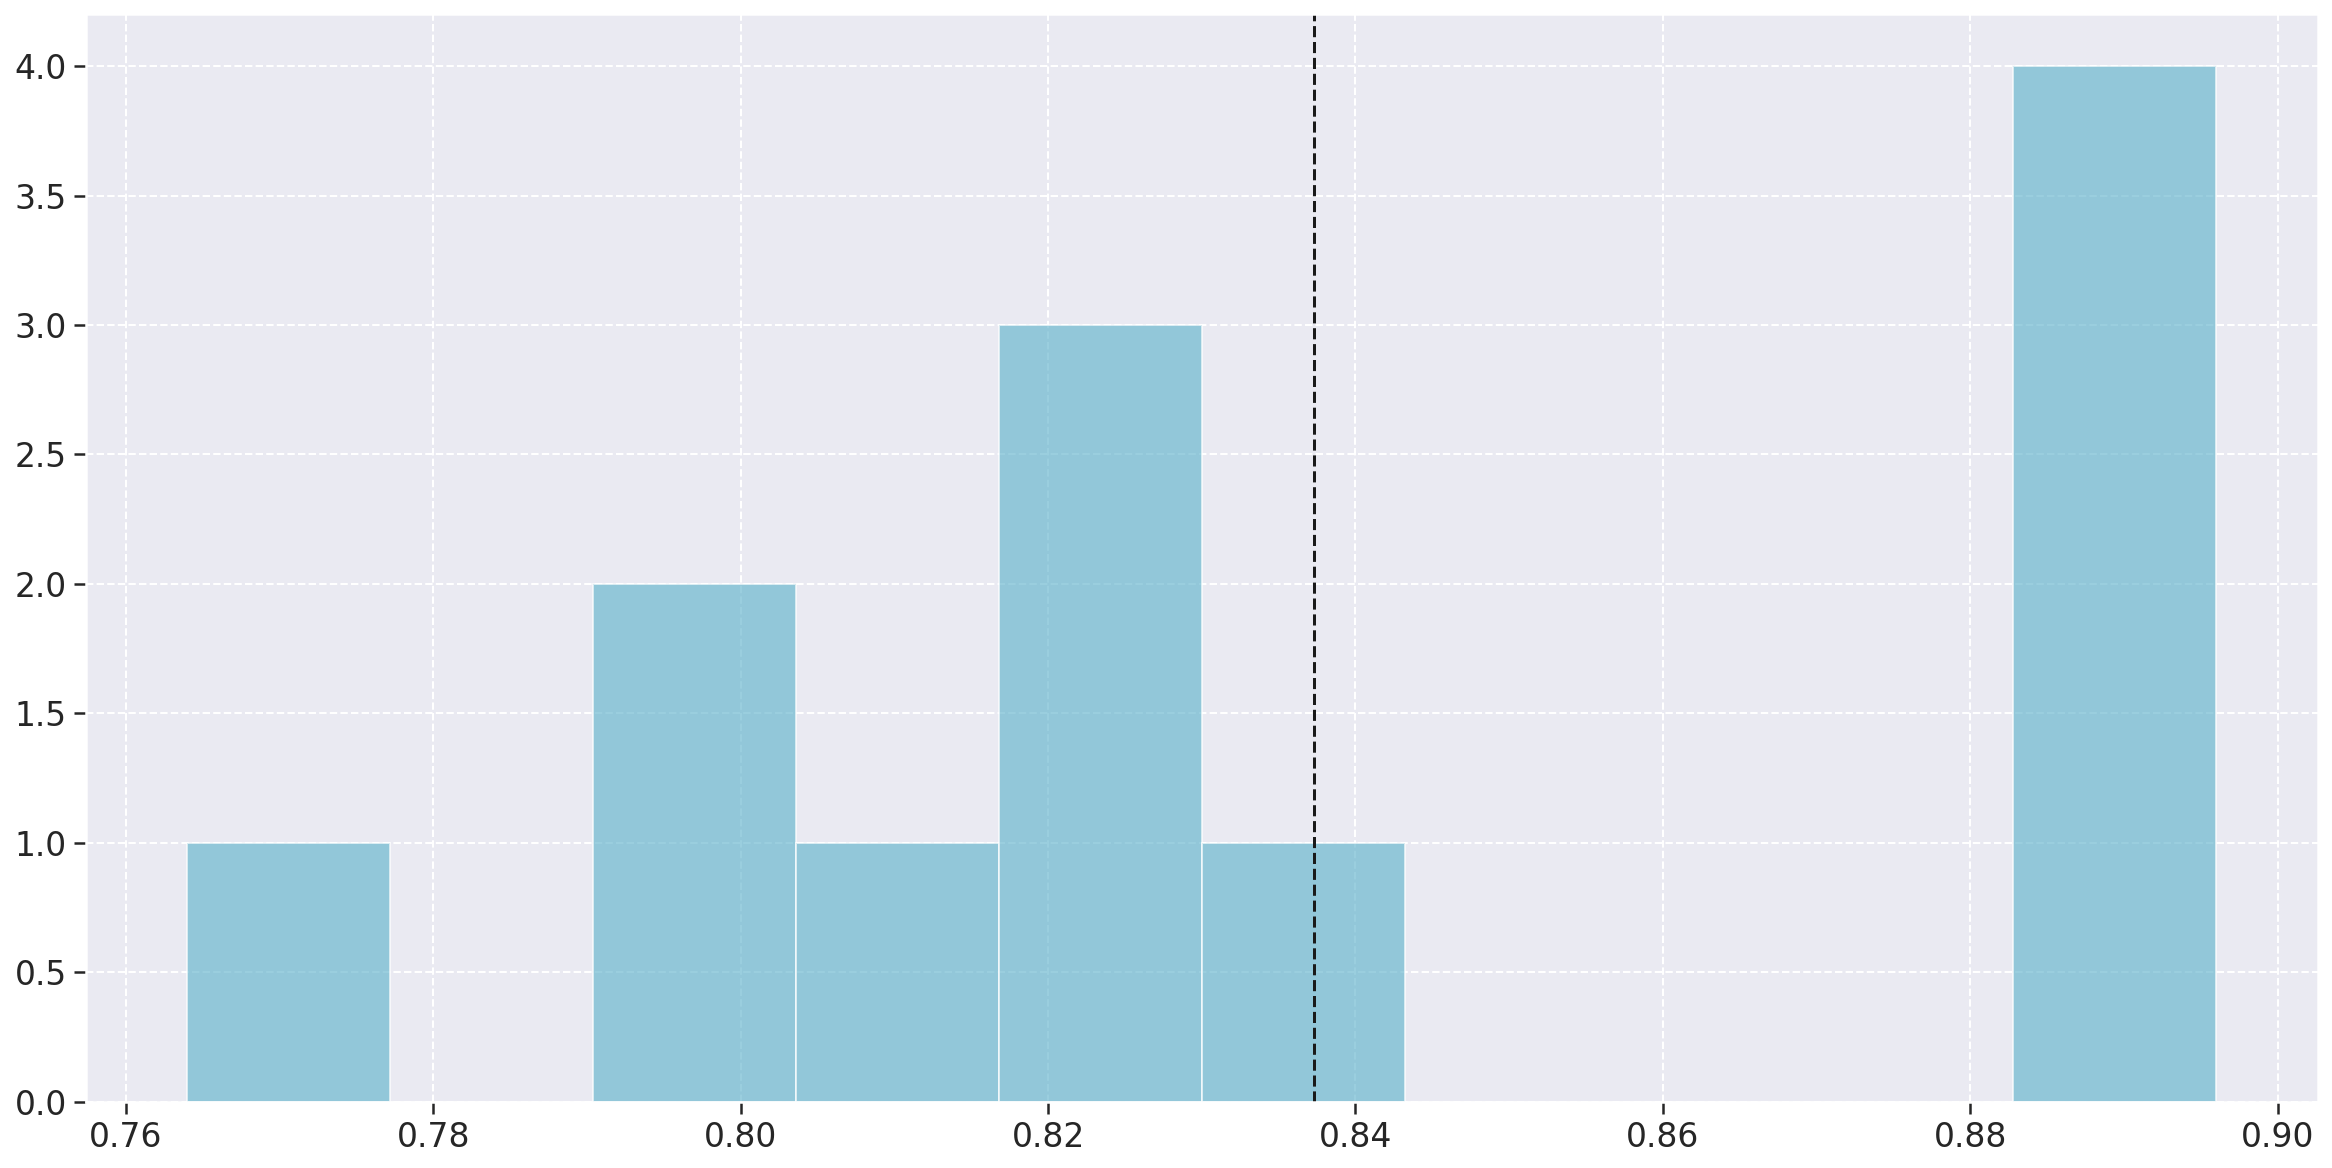

In [61]:
fig = plt.figure(figsize=(20, 10))

plt.hist(metrics_df['Total_QR'], bins=10, color='c', alpha=0.65)
plt.axvline(metrics_df['Total_QR'].mean(), color='k', linestyle='dashed')

## Boxplot

{'whiskers': [<matplotlib.lines.Line2D at 0x7fa020792828>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa020792da0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa020792780>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa0207a0390>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa0207a0630>],
 'means': []}

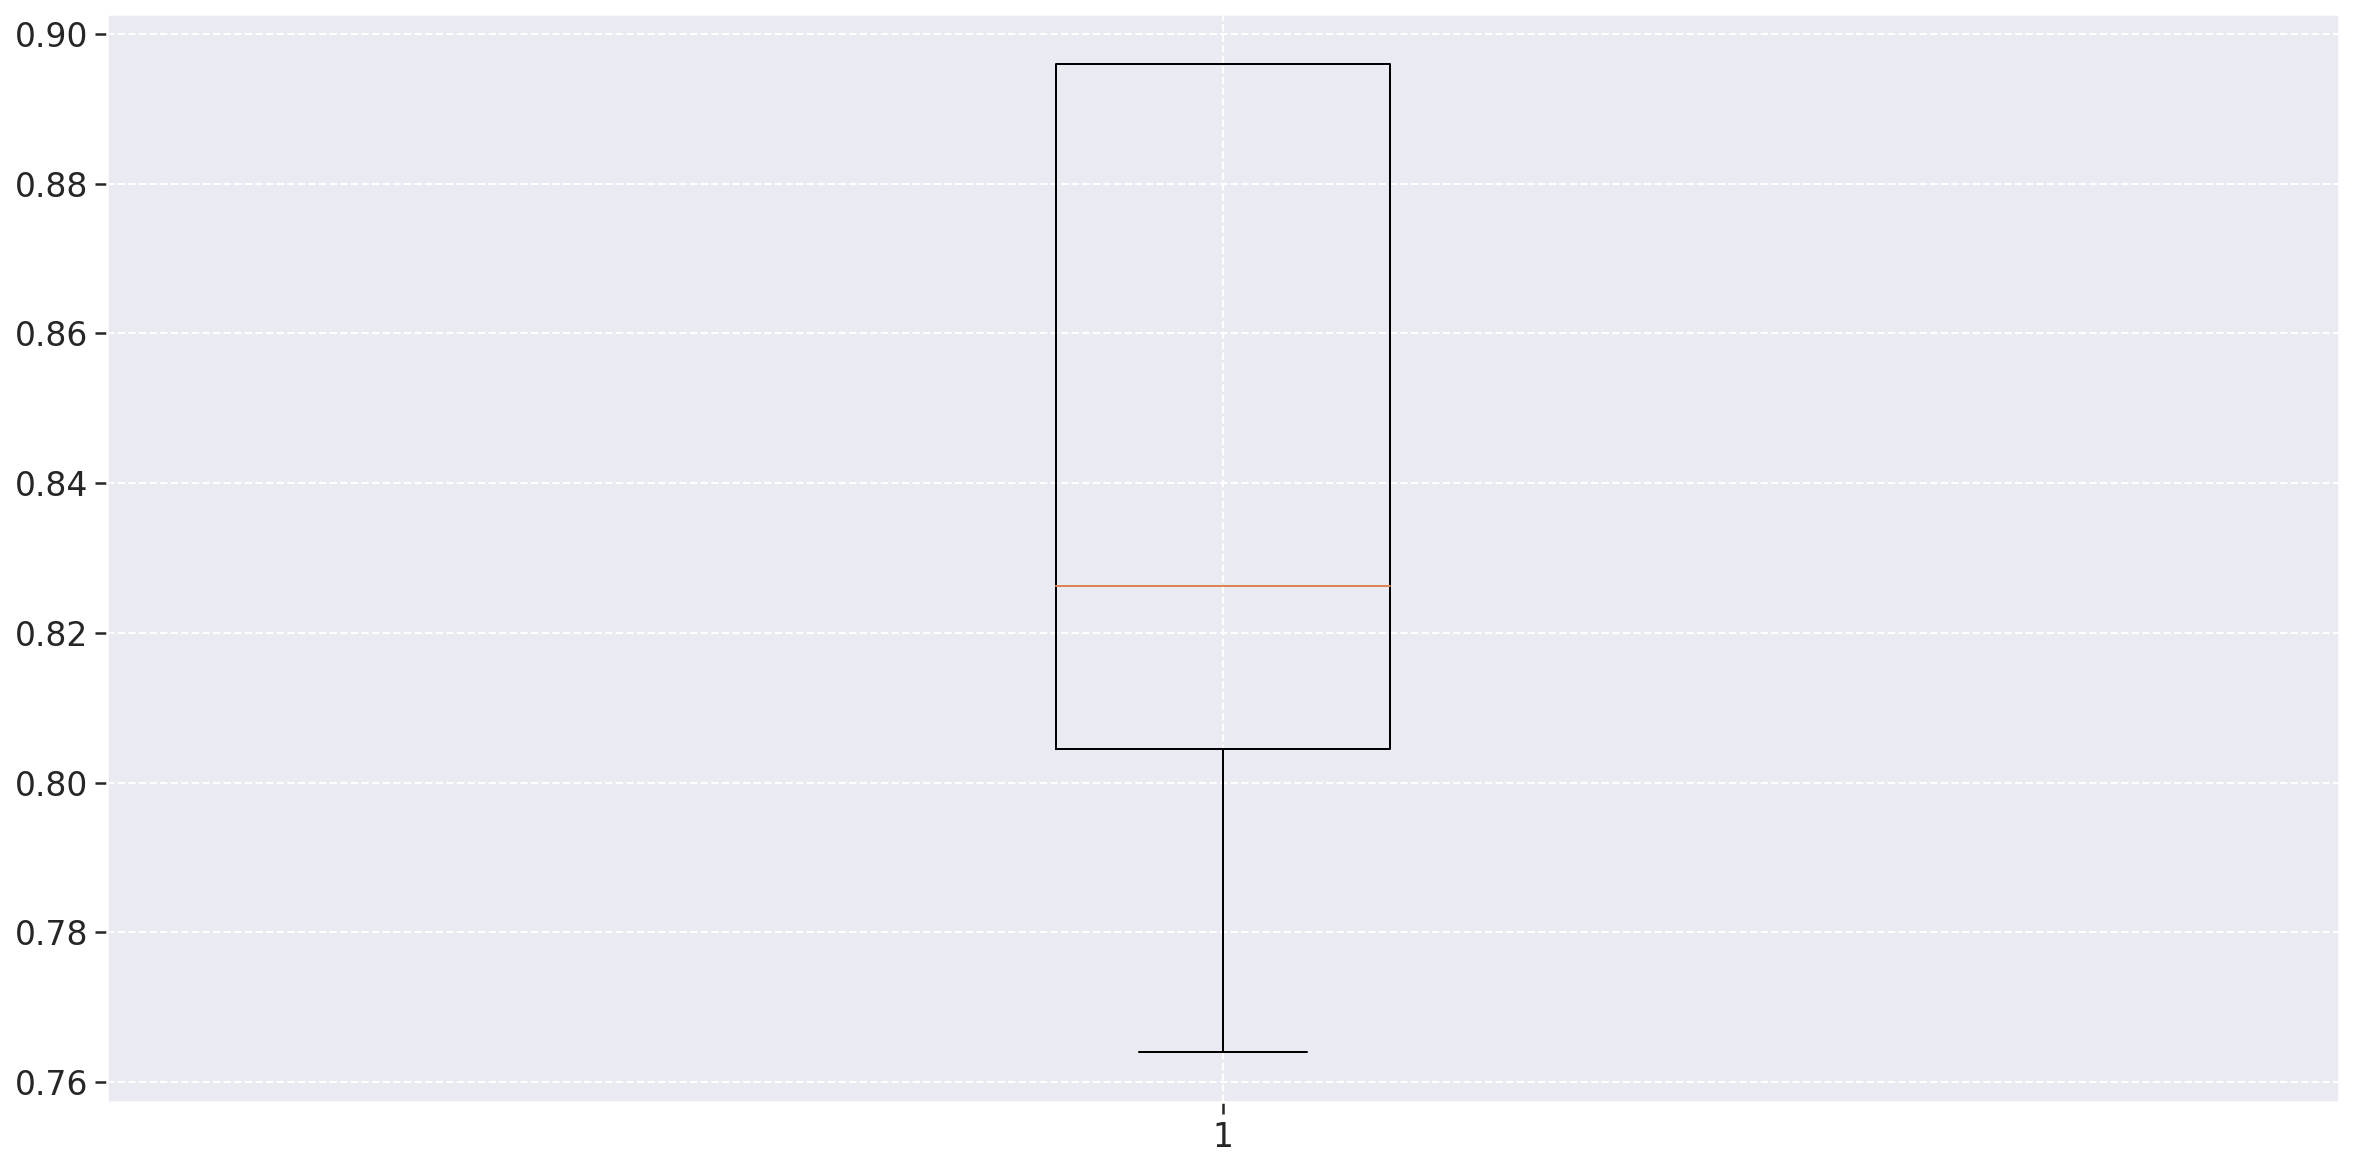

In [62]:
fig = plt.figure(figsize=(20, 10))

plt.boxplot(metrics_df['Total_QR'])

## Scatter

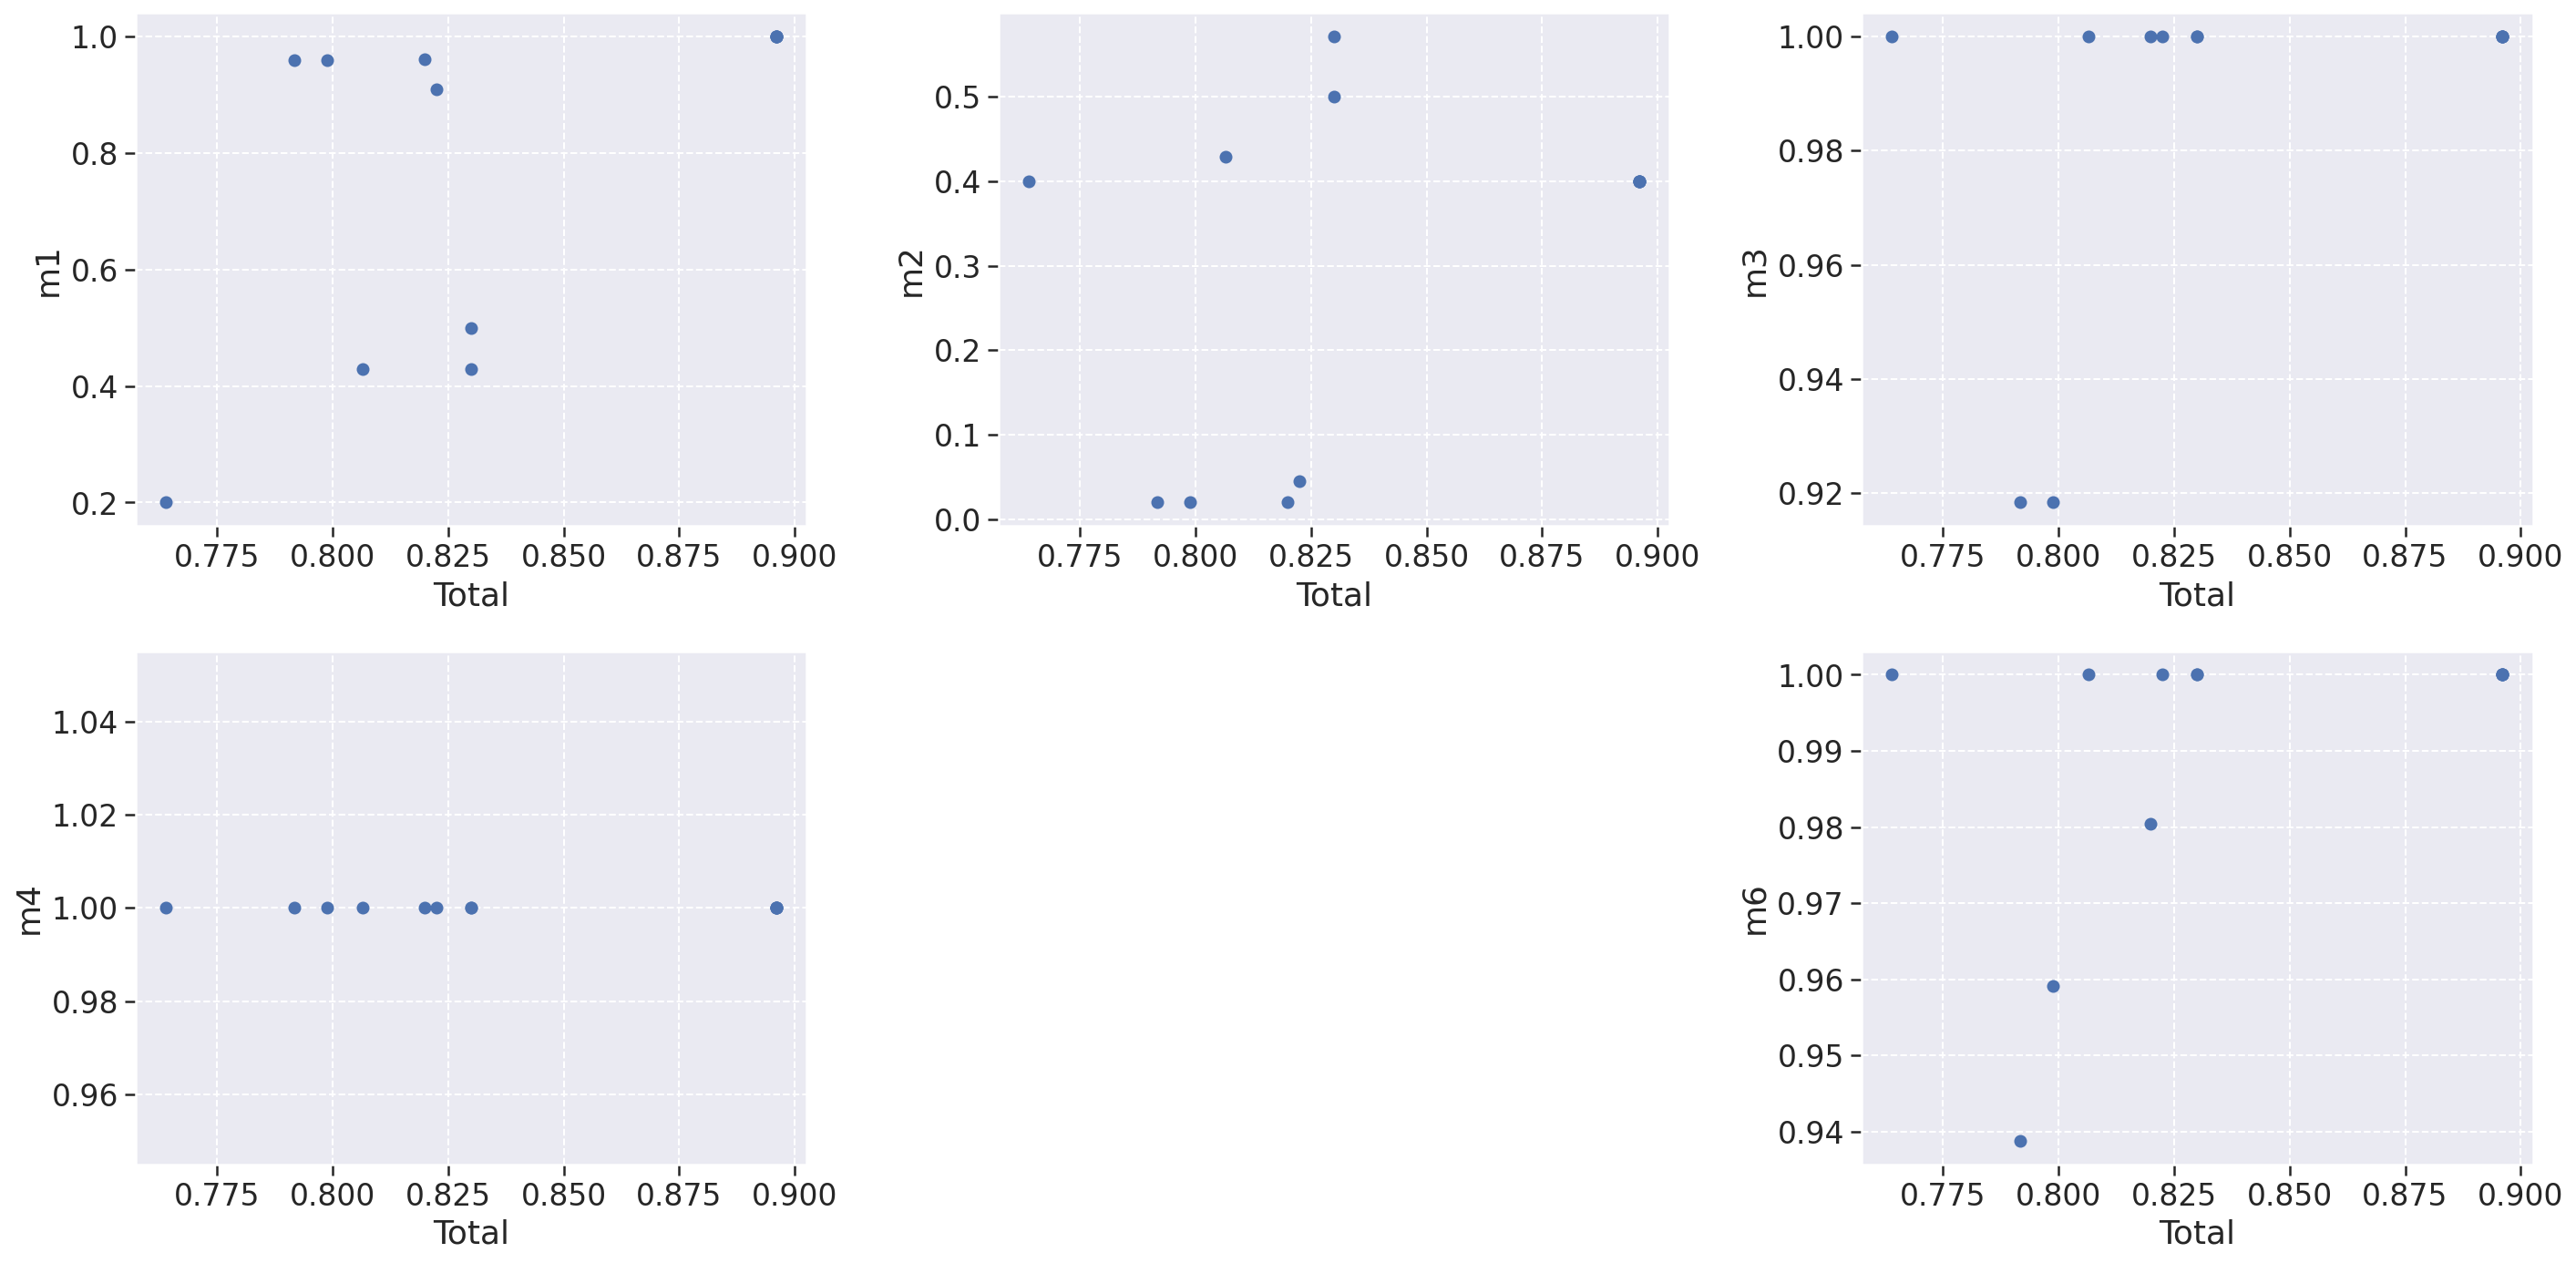

In [63]:
fig = plt.figure(figsize=(20, 10))

columns = 3
rows = 2
i = 1

for i in range(1, columns*rows):
    if i == 5:
        i+=1
        fig.add_subplot(rows, columns, i)
    else:
        fig.add_subplot(rows, columns, i)
    plt.scatter(metrics_df['Total_QR'], metrics_df[f'm{i}'])
    plt.xlabel('Total')
    plt.ylabel(f'm{i}')
    i+=1

plt.tight_layout()
plt.show()

## Analysis

So, overall the total value of the metrics were great, ranging from .79 to almost .9, as we can see in both graphs.

**Histogram**: The values higher than the mean were the same, at .89, almost .9, but the mean was dragged down by the lowest values, two .79 and one .765.

**Boxplot**: The median was closer to the first quartile, and a lot closer to the lower boundary, thats because the majority of the values where lower than the mean, so the mean and median were a little far, by something close to .02.

**Scatter**: We can see that the value that dragged the total down was **M2**, because while some of the metrics where always one or pretty close to one, **M2** was never higher than .6, and **M1** was fluctuating a lot.

**Final Words**: It's easy to see at the dataframe that both of the backend repositories got the higher values and the frontend got the lowest, but this is easy to understand why, just take a look at the number of lines in each repository. The last release lowered the metric value too, 

# Metrics to file

In [250]:
metrics_df.to_excel('./data/fga-eps-mds-2021_1-PC-GO1-TO-DATASET-ANALYSIS_DATE.xlsx', index = False)
metrics_df.to_csv('./data/fga-eps-mds-2021_1-PC-GO1-TO-DATASET-ANALYSIS_DATE.csv', index = False)